In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from collections import Counter

In [2]:
# Load the Marvel dataset
marvel_url = "https://raw.githubusercontent.com/fivethirtyeight/data/master/comic-characters/marvel-wikia-data.csv"
marvel_data = pd.read_csv(marvel_url)

# Load the DC dataset
dc_url = "https://raw.githubusercontent.com/fivethirtyeight/data/master/comic-characters/dc-wikia-data.csv"
dc_data = pd.read_csv(dc_url)

In [3]:
def convert_first_appearance(row):
    if pd.isna(row):  # Handle NaN cases
        return row
    if type(row) == float: # Row has already been converted
        return row
    row = str(row)
    try:
        month_map = {
                        'January': 1, 'February': 2, 'March': 3, 'April': 4,
                        'May': 5, 'June': 6, 'July': 7, 'August': 8,
                        'September': 9, 'October': 10, 'November': 11, 'December': 12,
                        'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4,
                        'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8,
                        'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12,
                        'Holiday': 11.5
                    }
        if "-" in row:  # Marvel date format (e.g., 'Sep-75')
            parts = row.split("-")
            year = int("19" + parts[1] if int(parts[1]) > 30 else "20" + parts[1])
            month_abbrev = parts[0]
            month = month_map.get(month_abbrev)
        else:  # DC date format (e.g., '1999, April')
            parts = row.split(", ")
            if len(parts) == 1:
                year = int(parts[0])
                month = 1
            else:
                year = int(parts[0])
                month_abbrev = parts[1]
                month = month_map.get(month_abbrev)

        return year + (month - 1) / 12  # Normalize month to a fraction of a year
    except:
        print("Error parsing date: " + row)
        raise
    

In [4]:
marvel_data["FIRST APPEARANCE"] = marvel_data["FIRST APPEARANCE"].apply(convert_first_appearance)
dc_data["FIRST APPEARANCE"] = dc_data["FIRST APPEARANCE"].apply(convert_first_appearance)

In [5]:
marvel_data.rename(columns={"Year": "YEAR"}, inplace=True)

In [6]:
# Combine datasets
combined_data = pd.concat([marvel_data, dc_data])

In [7]:
marvel_names = marvel_data["name"]
dc_names = dc_data["name"]
combined_names = combined_data["name"]

In [8]:
marvel_data = marvel_data.drop(["urlslug", "page_id", "name", "YEAR"], axis=1)
dc_data = dc_data.drop(["urlslug", "page_id", "name", "YEAR"], axis=1)
combined_data = combined_data.drop(["urlslug", "page_id", "name", "YEAR"], axis=1)

In [9]:
marvel_dfs = []
for column in marvel_data.columns:
    marvel_dfs.append((column, pd.DataFrame(marvel_data[column].value_counts(dropna=False), columns=[f"count"], index=marvel_data[column].unique())))
for column, df in marvel_dfs:
    print(f"Column: {column}", df, sep="\n", end="\n\n")

Column: ID
                               count
Secret Identity                 6275
Public Identity                 4528
No Dual Identity                1788
Known to Authorities Identity     15
NaN                             3770

Column: ALIGN
                    count
Good Characters      4636
Neutral Characters   2208
Bad Characters       6720
NaN                  2812

Column: EYE
                 count
Hazel Eyes          76
Blue Eyes         1962
Brown Eyes        1924
Green Eyes         613
Grey Eyes           95
Yellow Eyes        256
Gold Eyes           14
Red Eyes           508
Black Eyeballs       3
Amber Eyes          10
Variable Eyes       49
NaN               9767
Black Eyes         555
White Eyes         400
Orange Eyes         25
Silver Eyes         12
Purple Eyes         31
Pink Eyes           21
One Eye             21
Violet Eyes         11
Multiple Eyes        7
Magenta Eyes         2
Yellow Eyeballs      6
No Eyes              7
Compound Eyes        1

Column: HA

In [10]:
dc_dfs = []
for column in dc_data.columns:
    dc_dfs.append((column, pd.DataFrame(dc_data[column].value_counts(dropna=False), columns=[f"count"], index=dc_data[column].unique())))
for column, df in dc_dfs:
    print(f"Column: {column}", df, sep="\n", end="\n\n")

Column: ID
                  count
Secret Identity    2408
Public Identity    2466
NaN                2013
Identity Unknown      9

Column: ALIGN
                    count
Good Characters      2832
Bad Characters       2895
Neutral Characters    565
NaN                   601
Reformed Criminals      3

Column: EYE
                    count
Blue Eyes            1102
Brown Eyes            879
Green Eyes            291
Purple Eyes            14
Black Eyes            412
White Eyes            116
Red Eyes              208
Photocellular Eyes     48
Hazel Eyes             23
Amber Eyes              5
Yellow Eyes            86
NaN                  3628
Grey Eyes              40
Pink Eyes               6
Violet Eyes            12
Gold Eyes               9
Orange Eyes            10
Auburn Hair             7

Column: HAIR
                       count
Black Hair              1574
Brown Hair              1148
White Hair               346
Blond Hair               744
Red Hair                 461
NaN

In [11]:
combined_dfs = []
for column in combined_data.columns:
    combined_dfs.append((column, pd.DataFrame(combined_data[column].value_counts(dropna=False), columns=[f"count"], index=combined_data[column].unique())))
for column, df in combined_dfs:
    print(f"Column: {column}", df, sep="\n", end="\n\n")


Column: ID
                               count
Secret Identity                 8683
Public Identity                 6994
No Dual Identity                1788
Known to Authorities Identity     15
NaN                             5783
Identity Unknown                   9

Column: ALIGN
                    count
Good Characters      7468
Neutral Characters   2773
Bad Characters       9615
NaN                  3413
Reformed Criminals      3

Column: EYE
                    count
Hazel Eyes             99
Blue Eyes            3064
Brown Eyes           2803
Green Eyes            904
Grey Eyes             135
Yellow Eyes           342
Gold Eyes              23
Red Eyes              716
Black Eyeballs          3
Amber Eyes             15
Variable Eyes          49
NaN                 13395
Black Eyes            967
White Eyes            516
Orange Eyes            35
Silver Eyes            12
Purple Eyes            45
Pink Eyes              27
One Eye                21
Violet Eyes            23


In [12]:
# List of target features (exclude "url", "page_id", and "name")
target_features = ["ALIGN", "SEX", "EYE", "HAIR", "GSM", "ALIVE", "ID"]

In [13]:
rf_models_marvel = []
rf_models_dc = []
rf_models_combined = []

In [14]:
for target_feature in target_features:
    #print(f"""Target feature: {target_feature}""")

    # Create dataset with target_feature as the target column for each category
    data_marvel = marvel_data.dropna(subset=[target_feature])
    data_dc = dc_data.dropna(subset=[target_feature])
    data_combined = combined_data.dropna(subset=[target_feature])

    features_marvel = data_marvel.drop(target_feature, axis=1)
    features_dc = data_dc.drop(target_feature, axis=1)
    features_combined = data_combined.drop(target_feature, axis=1)

    targets_marvel = data_marvel[target_feature]
    targets_dc = data_dc[target_feature]
    targets_combined = data_combined[target_feature]

    classes = targets_marvel.unique()
    
    # Encode target feature
    le_marvel = LabelEncoder()
    le_dc = LabelEncoder()
    le_combined = LabelEncoder()
    y_marvel = le_marvel.fit_transform(targets_marvel)
    y_dc = le_dc.fit_transform(targets_dc)
    y_combined = le_combined.fit_transform(targets_combined)

    # One-hot encode features
    columns = [tf for tf in target_features if tf != target_feature]
    onehot_features_marvel = pd.get_dummies(features_marvel, columns=columns)
    onehot_features_dc = pd.get_dummies(features_dc, columns=columns)
    onehot_features_combined = pd.get_dummies(features_combined, columns=columns)

    # Impute missing values
    imputer = SimpleImputer(strategy="mean")
    imputed_onehot_features_marvel = imputer.fit_transform(onehot_features_marvel)
    imputed_onehot_features_dc = imputer.fit_transform(onehot_features_dc)
    imputed_onehot_features_combined = imputer.fit_transform(onehot_features_combined)

    # Final features dataframe
    X_marvel = pd.DataFrame(imputed_onehot_features_marvel, columns=onehot_features_marvel.columns)
    X_dc = pd.DataFrame(imputed_onehot_features_dc, columns=onehot_features_dc.columns)
    X_combined = pd.DataFrame(imputed_onehot_features_combined, columns=onehot_features_combined.columns)

    # Split data into training and testing sets

    X_train_marvel, X_test_marvel, y_train_marvel, y_test_marvel = train_test_split(X_marvel, y_marvel, test_size=0.2, random_state=42)
    X_train_dc, X_test_dc, y_train_dc, y_test_dc = train_test_split(X_dc, y_dc, test_size=0.2, random_state=42)
    X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

    # Create RandomForest classifiers for each category
    rf_classifier_marvel = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier_dc = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier_combined = RandomForestClassifier(n_estimators=100, random_state=42)

    # Get the unique class labels from the original target data
    marvel_unique_class_labels = np.unique(y_marvel)
    print(marvel_unique_class_labels)
    dc_unique_class_labels = np.unique(y_dc)
    combined_unique_class_labels = np.unique(y_combined)

    # Convert the unique class labels to a list
    marvel_class_names = le_marvel.inverse_transform(marvel_unique_class_labels)
    print(marvel_class_names)
    dc_class_names = le_dc.inverse_transform(dc_unique_class_labels)
    combined_class_names = le_combined.inverse_transform(combined_unique_class_labels)
    
    # Store the trained models in the respective lists
    rf_models_marvel.append((rf_classifier_marvel, X_train_marvel, y_train_marvel, X_test_marvel, y_test_marvel, target_feature, marvel_class_names))
    rf_models_dc.append((rf_classifier_dc, X_train_dc, y_train_dc, X_test_dc, y_test_dc, target_feature, dc_class_names))
    rf_models_combined.append((rf_classifier_combined, X_train_combined, y_train_combined, X_test_combined, y_test_combined, target_feature, combined_class_names))

[0 1 2]
['Bad Characters' 'Good Characters' 'Neutral Characters']
[0 1 2 3]
['Agender Characters' 'Female Characters' 'Genderfluid Characters'
 'Male Characters']
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
['Amber Eyes' 'Black Eyeballs' 'Black Eyes' 'Blue Eyes' 'Brown Eyes'
 'Compound Eyes' 'Gold Eyes' 'Green Eyes' 'Grey Eyes' 'Hazel Eyes'
 'Magenta Eyes' 'Multiple Eyes' 'No Eyes' 'One Eye' 'Orange Eyes'
 'Pink Eyes' 'Purple Eyes' 'Red Eyes' 'Silver Eyes' 'Variable Eyes'
 'Violet Eyes' 'White Eyes' 'Yellow Eyeballs' 'Yellow Eyes']
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
['Auburn Hair' 'Bald' 'Black Hair' 'Blond Hair' 'Blue Hair' 'Bronze Hair'
 'Brown Hair' 'Dyed Hair' 'Gold Hair' 'Green Hair' 'Grey Hair'
 'Light Brown Hair' 'Magenta Hair' 'No Hair' 'Orange Hair'
 'Orange-brown Hair' 'Pink Hair' 'Purple Hair' 'Red Hair'
 'Reddish Blond Hair' 'Silver Hair' 'Strawberry Blond Hair'
 'Variable Hair' 'White Hair' 'Yellow Ha

In [15]:
for rf_model, X_train, y_train, X_test, y_test, target_feature, _ in rf_models_marvel:
    try:
        rf_model.fit(X_train, y_train)
        y_pred = rf_model.predict(X_test)
        print(f"""Accuracy score for Marvel {target_feature} predictions: {accuracy_score(y_test, y_pred)}""")
    except:
        print(f"""Not enough data for Marvel {target_feature} predictions""")
        continue


Accuracy score for Marvel ALIGN predictions: 0.5576852193144121
Accuracy score for Marvel SEX predictions: 0.7314009661835749
Accuracy score for Marvel EYE predictions: 0.4122541603630862
Accuracy score for Marvel HAIR predictions: 0.3033429632686752
Accuracy score for Marvel GSM predictions: 0.8333333333333334
Accuracy score for Marvel ALIVE predictions: 0.7312977099236642
Accuracy score for Marvel ID predictions: 0.5452022204599524


In [16]:
for rf_model, X_train, y_train, X_test, y_test, target_feature, _ in rf_models_dc:
    try:
        rf_model.fit(X_train, y_train)
        y_pred = rf_model.predict(X_test)
        print(f"""Accuracy score for DC {target_feature} predictions: {accuracy_score(y_test, y_pred)}""")
    except:
        print(f"""Not enough data for DC {target_feature} predictions""")
        continue

Accuracy score for DC ALIGN predictions: 0.5972994440031771
Accuracy score for DC SEX predictions: 0.6937269372693727
Accuracy score for DC EYE predictions: 0.42813455657492355
Accuracy score for DC HAIR predictions: 0.2972972972972973
Accuracy score for DC GSM predictions: 0.8461538461538461
Accuracy score for DC ALIVE predictions: 0.7251631617113851
Accuracy score for DC ID predictions: 0.6264073694984647


In [17]:
for rf_model, X_train, y_train, X_test, y_test, target_feature, _ in rf_models_combined:
    try:
        rf_model.fit(X_train, y_train)
        y_pred = rf_model.predict(X_test)
        print(f"""Accuracy score for combined {target_feature} predictions: {accuracy_score(y_test, y_pred)}""")
    except:
        print(f"""Not enough data for combined {target_feature} predictions""")
        continue

Accuracy score for combined ALIGN predictions: 0.5662134944612286
Accuracy score for combined SEX predictions: 0.7151827764072662
Accuracy score for combined EYE predictions: 0.40384615384615385
Accuracy score for combined HAIR predictions: 0.2954884971616373
Accuracy score for combined GSM predictions: 0.7741935483870968
Accuracy score for combined ALIVE predictions: 0.7367855608079071
Accuracy score for combined ID predictions: 0.5465980560320183


In [18]:
import shap

shap.initjs()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [19]:
shap_models_marvel = []

for rf_model, X_train, y_train, X_test, y_test, target_feature, class_names in rf_models_marvel:
    print(f"""Creating SHAP values for Marvel {target_feature} predictions with {len(X_test)} samples""")
    subset_size = min((int(len(X_test) * 0.1) if len(X_test) > 250 else len(X_test)), 10)
    print(f"""Subset size: {subset_size}""")

    explainer = shap.TreeExplainer(rf_model)
    shap_values = explainer.shap_values(X_test[:subset_size])
    shap_models_marvel.append((explainer, shap_values, X_test[:subset_size], target_feature, class_names))
    print(f"""SHAP values for Marvel {target_feature} predictions created""")

print("Marvel SHAP values created")

Creating SHAP values for Marvel ALIGN predictions with 2713 samples
Subset size: 10
SHAP values for Marvel ALIGN predictions created
Creating SHAP values for Marvel SEX predictions with 3105 samples
Subset size: 10
SHAP values for Marvel SEX predictions created
Creating SHAP values for Marvel EYE predictions with 1322 samples
Subset size: 10
SHAP values for Marvel EYE predictions created
Creating SHAP values for Marvel HAIR predictions with 2423 samples
Subset size: 10
SHAP values for Marvel HAIR predictions created
Creating SHAP values for Marvel GSM predictions with 18 samples
Subset size: 10
SHAP values for Marvel GSM predictions created
Creating SHAP values for Marvel ALIVE predictions with 3275 samples
Subset size: 10
SHAP values for Marvel ALIVE predictions created
Creating SHAP values for Marvel ID predictions with 2522 samples
Subset size: 10
SHAP values for Marvel ID predictions created
Marvel SHAP values created


In [20]:
# Create SHAP values for DC

shap_models_dc = []

for rf_model, X_train, y_train, X_test, y_test, target_feature, class_names in rf_models_dc:
    print(f"""Creating SHAP values for DC {target_feature} predictions with {len(X_test)} samples""")
    subset_size = min((int(len(X_test) * 0.1) if len(X_test) > 250 else len(X_test)), 10)
    print(f"""Subset size: {subset_size}""")

    explainer = shap.TreeExplainer(rf_model)
    shap_values = explainer.shap_values(X_test[:subset_size])
    shap_models_dc.append((explainer, shap_values, X_test[:subset_size], target_feature, class_names))
    print(f"""SHAP values for DC {target_feature} predictions created""")

print("DC SHAP values created")

Creating SHAP values for DC ALIGN predictions with 1259 samples
Subset size: 10
SHAP values for DC ALIGN predictions created
Creating SHAP values for DC SEX predictions with 1355 samples
Subset size: 10
SHAP values for DC SEX predictions created
Creating SHAP values for DC EYE predictions with 654 samples
Subset size: 10
SHAP values for DC EYE predictions created
Creating SHAP values for DC HAIR predictions with 925 samples
Subset size: 10
SHAP values for DC HAIR predictions created
Creating SHAP values for DC GSM predictions with 13 samples
Subset size: 10
SHAP values for DC GSM predictions created
Creating SHAP values for DC ALIVE predictions with 1379 samples
Subset size: 10
SHAP values for DC ALIVE predictions created
Creating SHAP values for DC ID predictions with 977 samples
Subset size: 10
SHAP values for DC ID predictions created
DC SHAP values created


In [21]:
# Create SHAP values for combined

shap_models_combined = []

for rf_model, X_train, y_train, X_test, y_test, target_feature, class_names in rf_models_combined:
    print(f"""Creating SHAP values for combined {target_feature} predictions with {len(X_test)} samples""")
    subset_size = min((int(len(X_test) * 0.1) if len(X_test) > 250 else len(X_test)), 10)
    print(f"""Subset size: {subset_size}""")

    explainer = shap.TreeExplainer(rf_model)
    shap_values = explainer.shap_values(X_test[:subset_size])
    shap_models_combined.append((explainer, shap_values, X_test[:subset_size], target_feature, class_names))
    print(f"""SHAP values for combined {target_feature} predictions created""")

print("Combined SHAP values created")

Creating SHAP values for combined ALIGN predictions with 3972 samples
Subset size: 10
SHAP values for combined ALIGN predictions created
Creating SHAP values for combined SEX predictions with 4459 samples
Subset size: 10
SHAP values for combined SEX predictions created
Creating SHAP values for combined EYE predictions with 1976 samples
Subset size: 10
SHAP values for combined EYE predictions created
Creating SHAP values for combined HAIR predictions with 3347 samples
Subset size: 10
SHAP values for combined HAIR predictions created
Creating SHAP values for combined GSM predictions with 31 samples
Subset size: 10
SHAP values for combined GSM predictions created
Creating SHAP values for combined ALIVE predictions with 4654 samples
Subset size: 10
SHAP values for combined ALIVE predictions created
Creating SHAP values for combined ID predictions with 3498 samples
Subset size: 10
SHAP values for combined ID predictions created
Combined SHAP values created


In [22]:
import random
import matplotlib.pyplot as plt

Creating Summary plot for Marvel ALIGN predictions


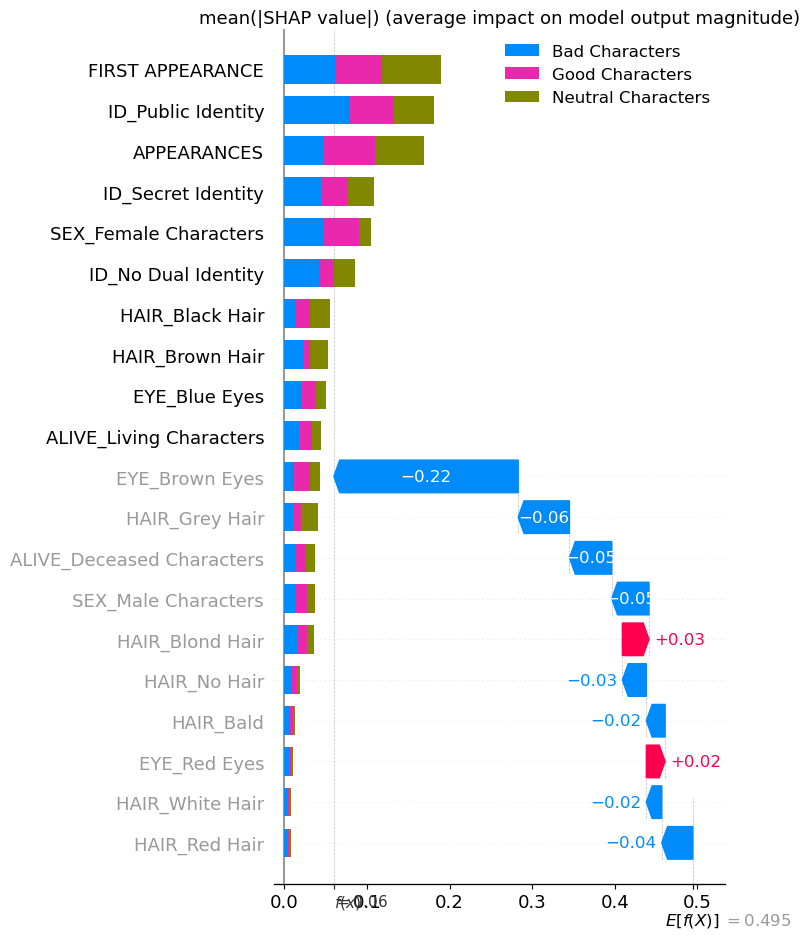

Created Summary plot for Marvel ALIGN predictions
Creating Waterfall plot for Marvel ALIGN predictions


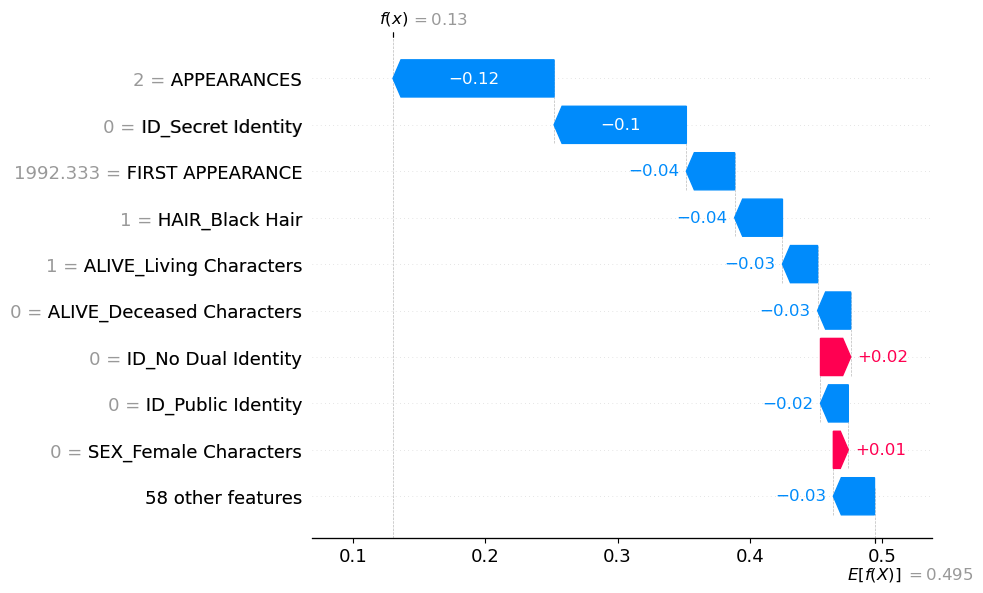

Created Waterfall plot for Marvel ALIGN predictions
Creating Summary plot for Marvel SEX predictions


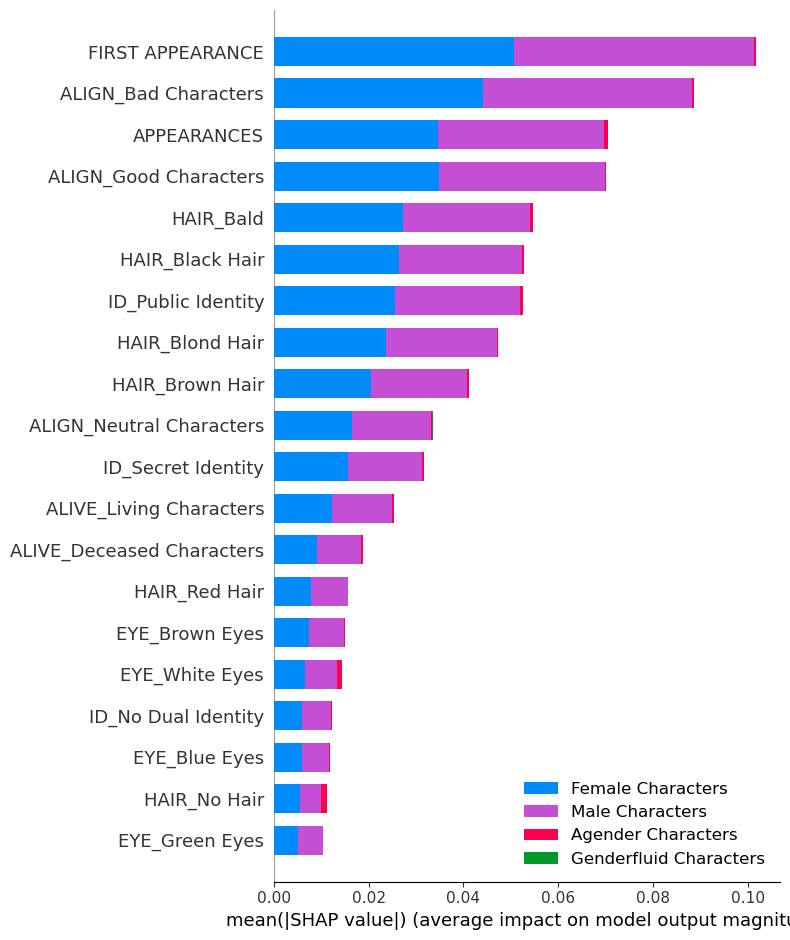

Created Summary plot for Marvel SEX predictions
Creating Waterfall plot for Marvel SEX predictions


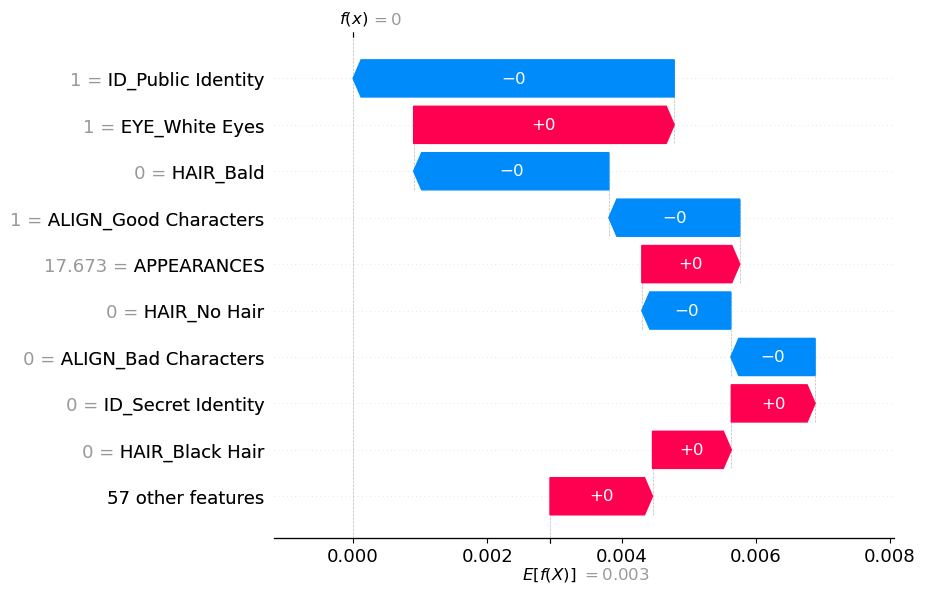

Created Waterfall plot for Marvel SEX predictions
Creating Summary plot for Marvel EYE predictions


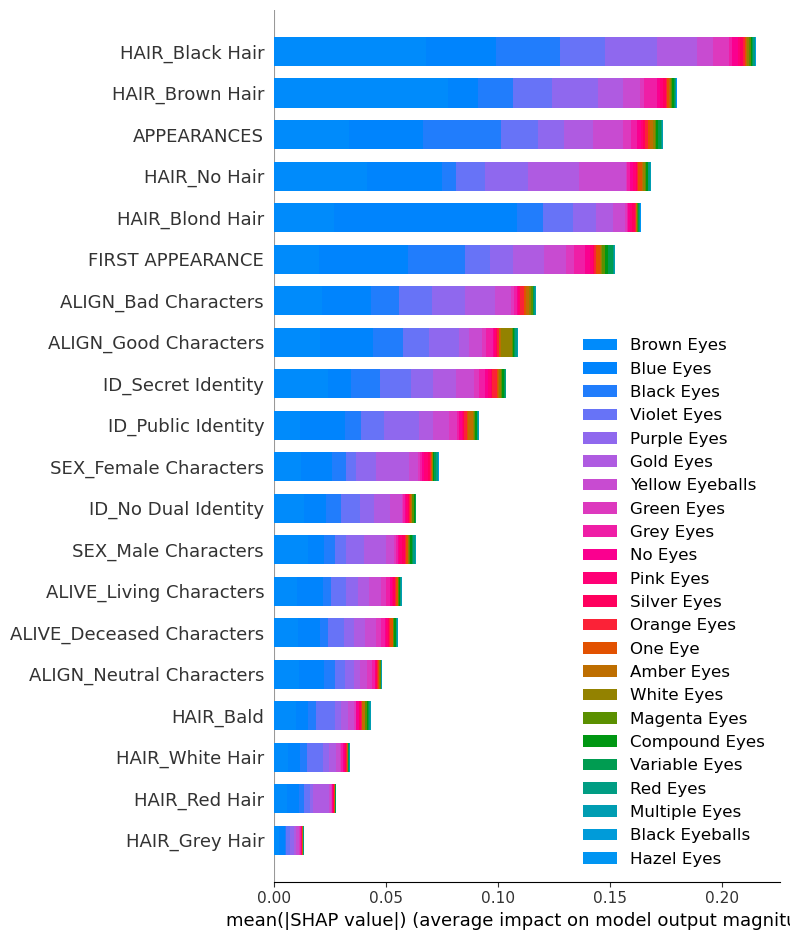

Created Summary plot for Marvel EYE predictions
Creating Waterfall plot for Marvel EYE predictions


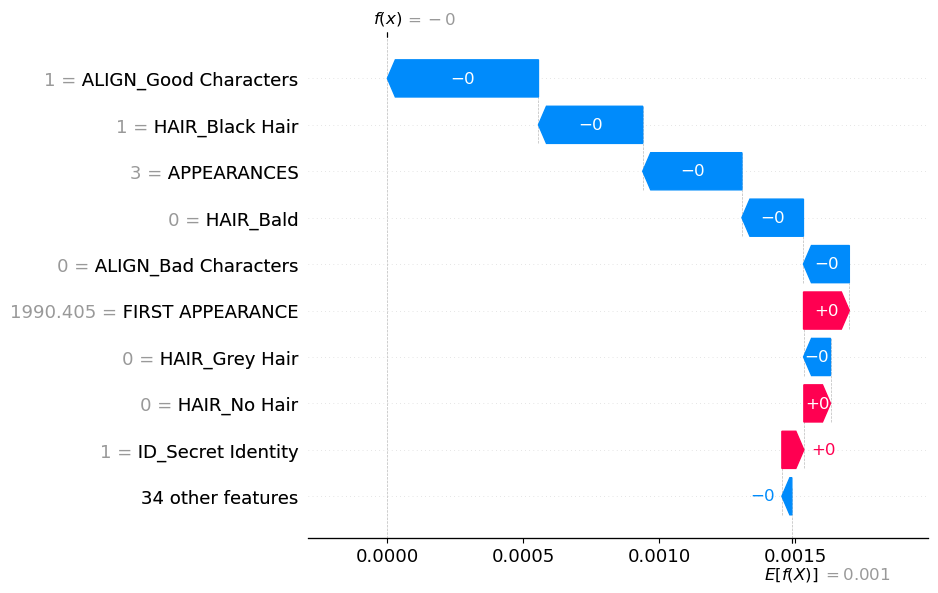

Created Waterfall plot for Marvel EYE predictions
Creating Summary plot for Marvel HAIR predictions


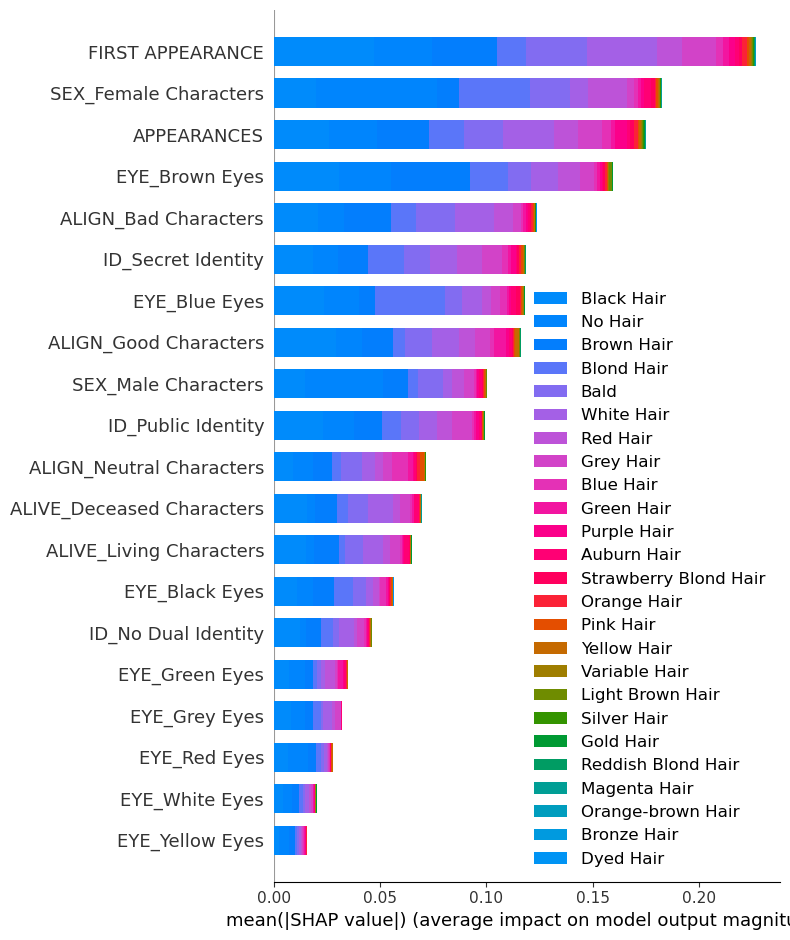

Created Summary plot for Marvel HAIR predictions
Creating Waterfall plot for Marvel HAIR predictions


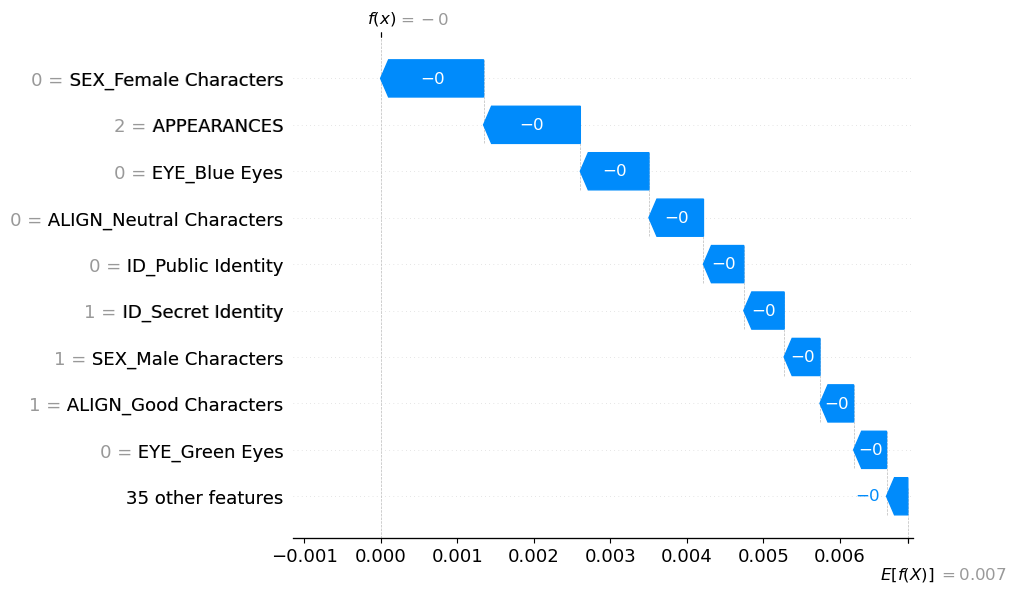

Created Waterfall plot for Marvel HAIR predictions
Creating Summary plot for Marvel GSM predictions


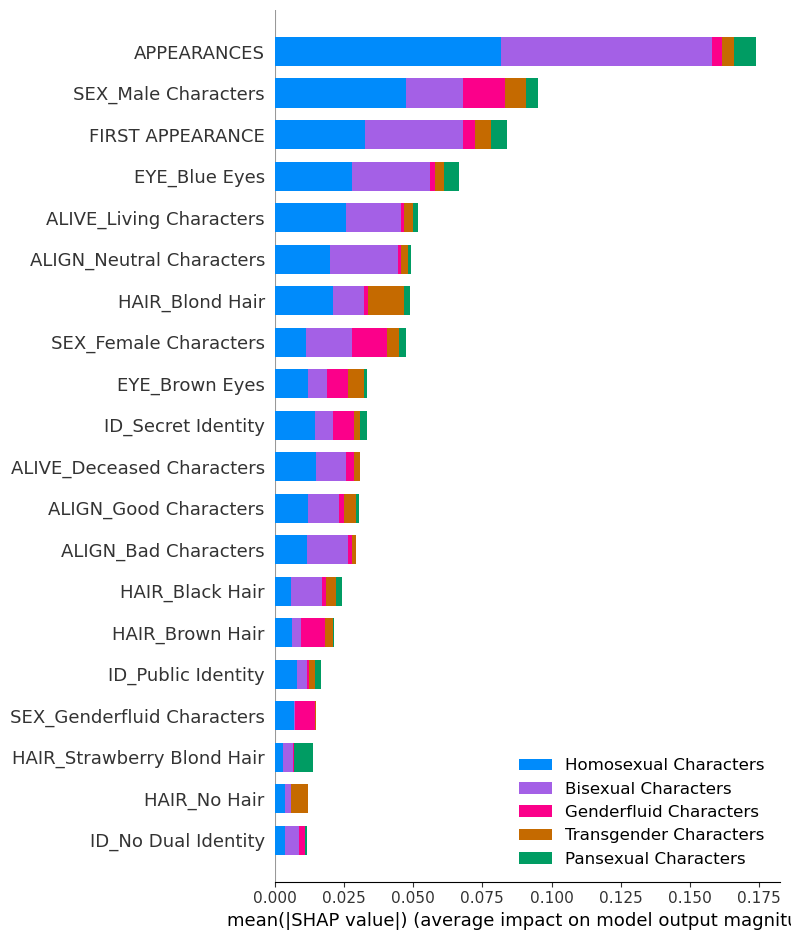

Created Summary plot for Marvel GSM predictions
Creating Waterfall plot for Marvel GSM predictions


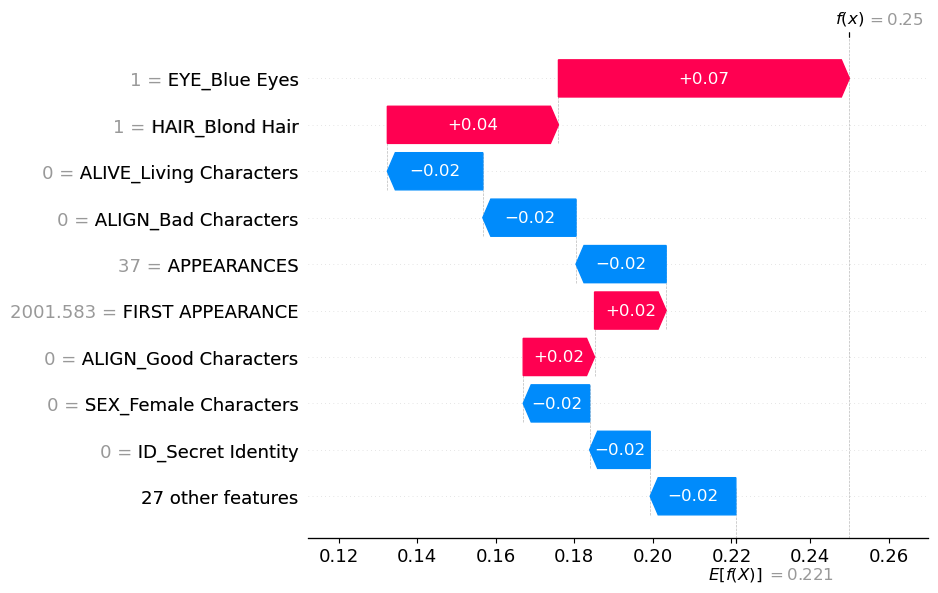

Created Waterfall plot for Marvel GSM predictions
Creating Summary plot for Marvel ALIVE predictions


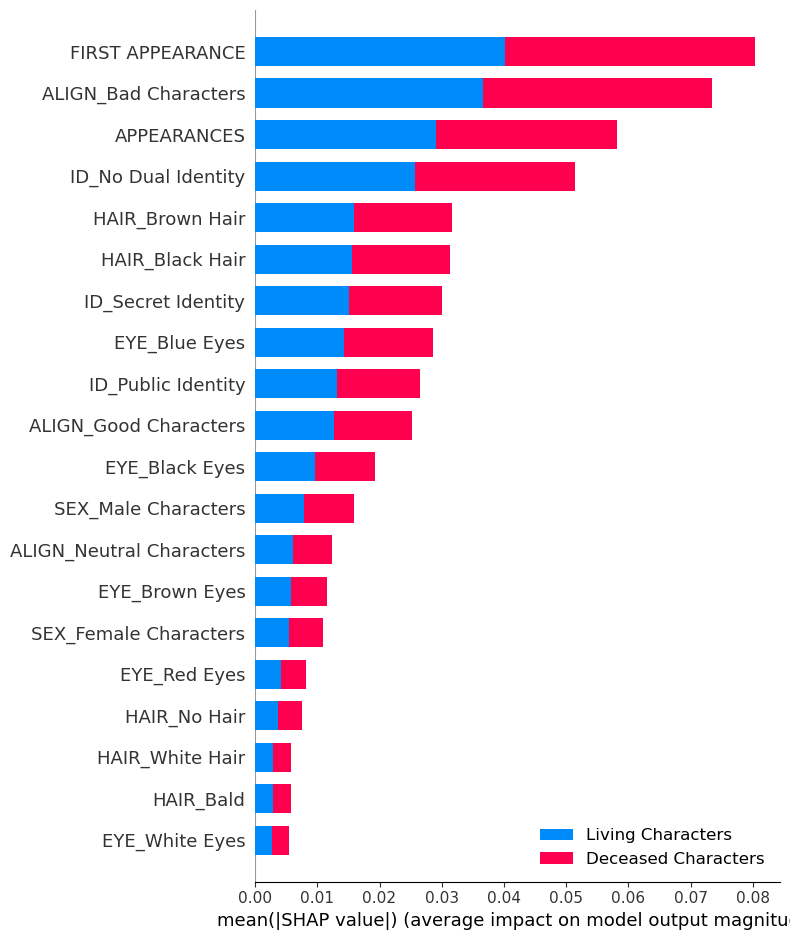

Created Summary plot for Marvel ALIVE predictions
Creating Waterfall plot for Marvel ALIVE predictions


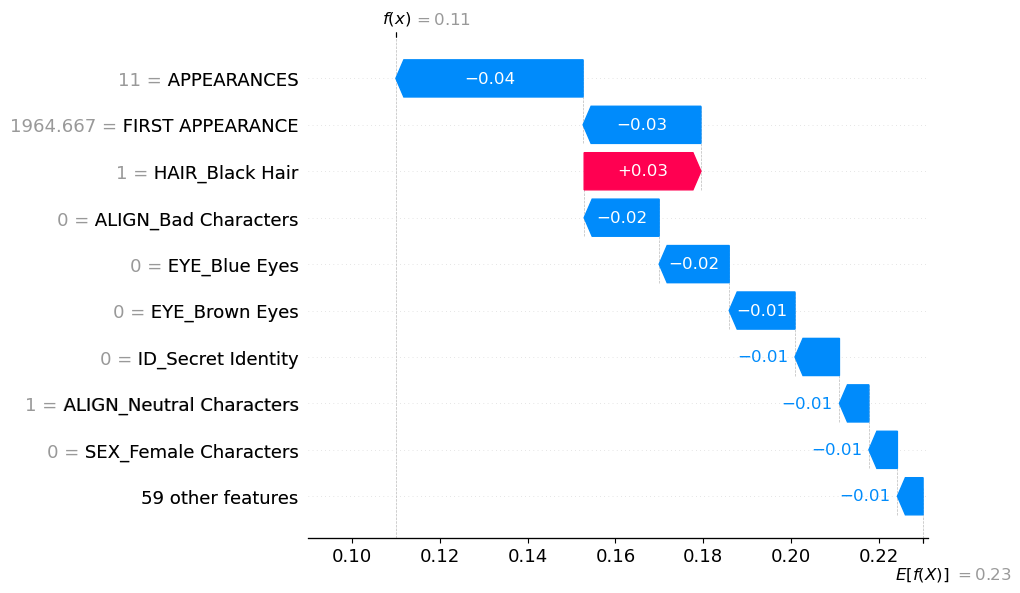

Created Waterfall plot for Marvel ALIVE predictions
Creating Summary plot for Marvel ID predictions


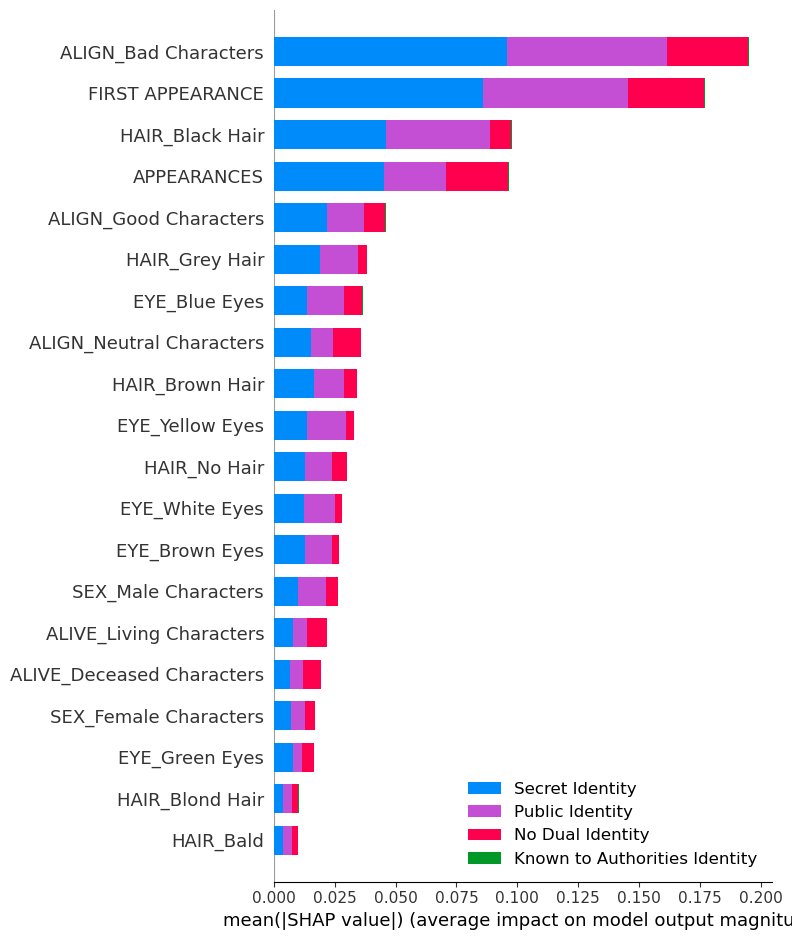

Created Summary plot for Marvel ID predictions
Creating Waterfall plot for Marvel ID predictions


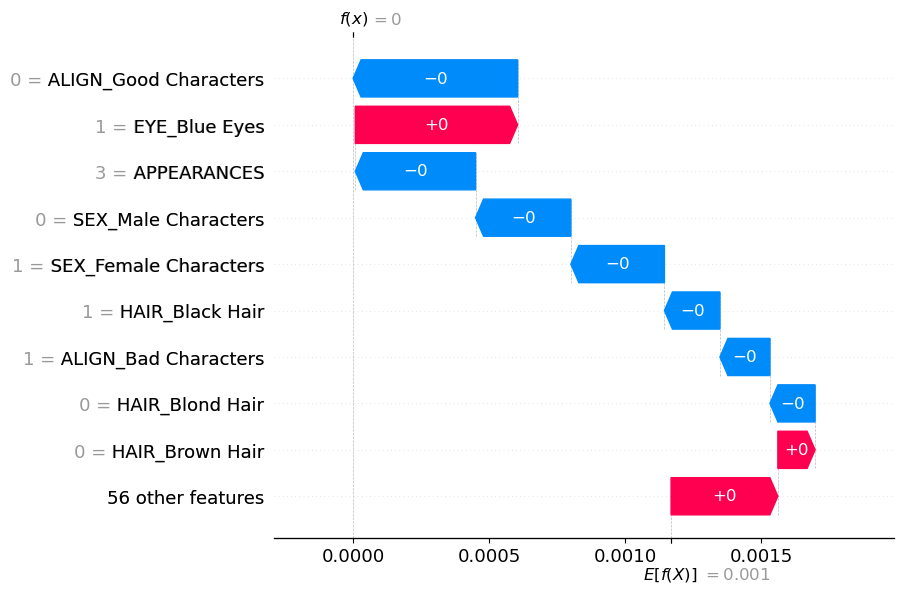

Created Waterfall plot for Marvel ID predictions
Marvel plots created


In [25]:
# Create plots for Marvel

for explainer, shap_values, feature_subset, target_feature, class_names in shap_models_marvel:
    num_samples = len(feature_subset)
    sample_index = random.randint(0, num_samples - 1)  # Generate a random index within the valid range

    print(f"Creating Summary plot for Marvel {target_feature} predictions")
    shap.summary_plot(shap_values, feature_subset, feature_names=feature_subset.columns, show=False, class_names=class_names)
    plt.savefig(f"figs/summary/Marvel_{target_feature}_summary.png")
    plt.show()
    print(f"Created Summary plot for Marvel {target_feature} predictions")

    print(f"Creating Waterfall plot for Marvel {target_feature} predictions")
    shap.plots.waterfall(shap.Explanation(values=shap_values[0][sample_index], base_values=explainer.expected_value[0], data=feature_subset.iloc[sample_index]), max_display=10, show=False)
    plt.savefig(f"figs/waterfall/Marvel_{target_feature}_{sample_index}_waterfall.png")
    plt.show()
    print(f"Created Waterfall plot for Marvel {target_feature} predictions")


print("Marvel plots created")
    

Creating Summary plot for DC ALIGN predictions


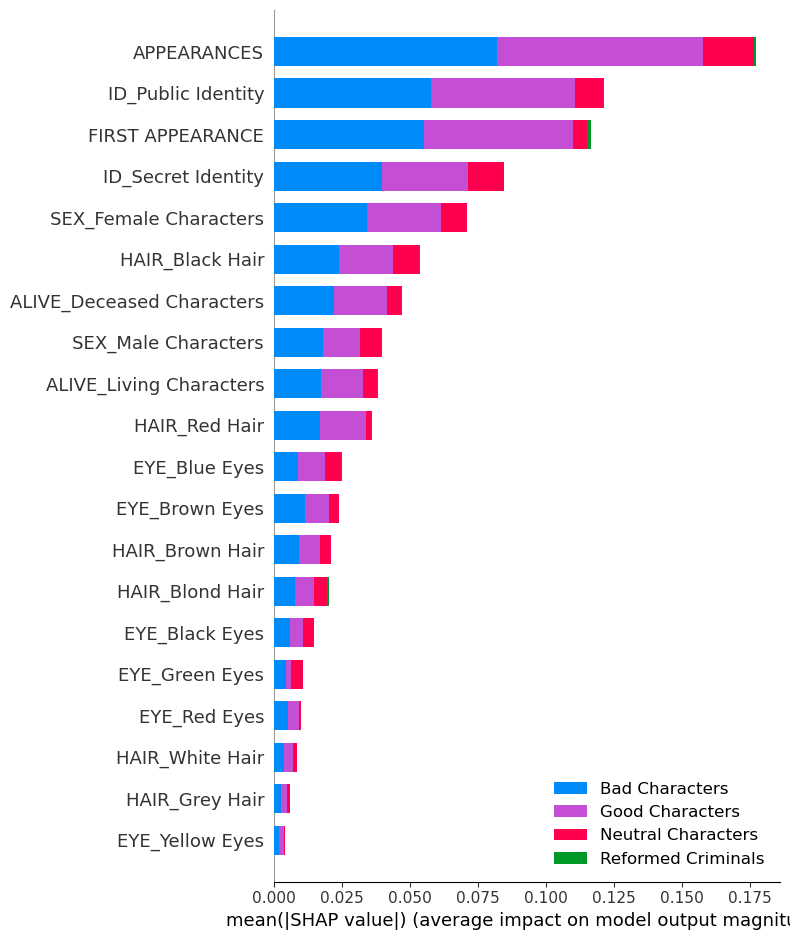

Created Summary plot for DC ALIGN predictions
Creating Waterfall plot for DC ALIGN predictions


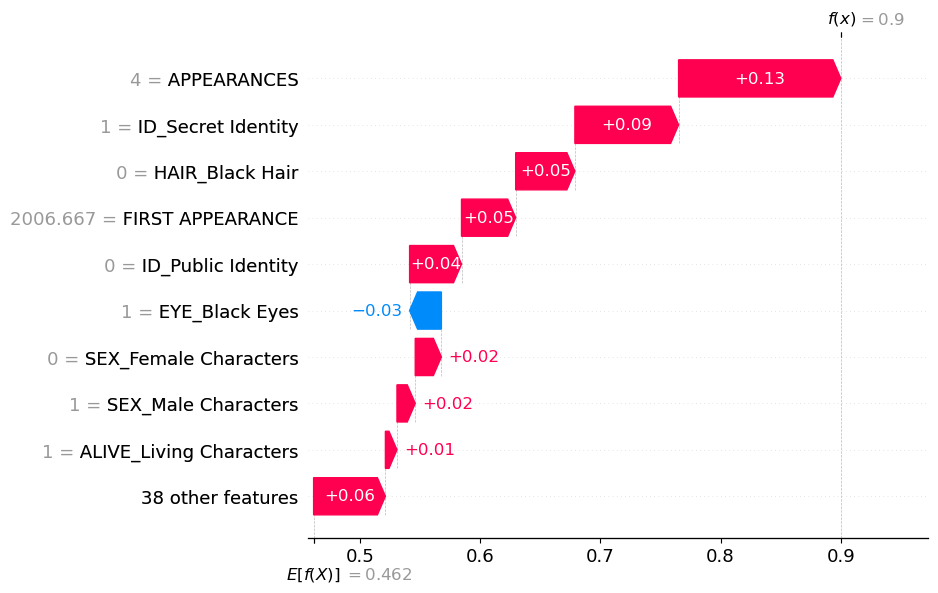

Created Waterfall plot for DC ALIGN predictions
Creating Summary plot for DC SEX predictions


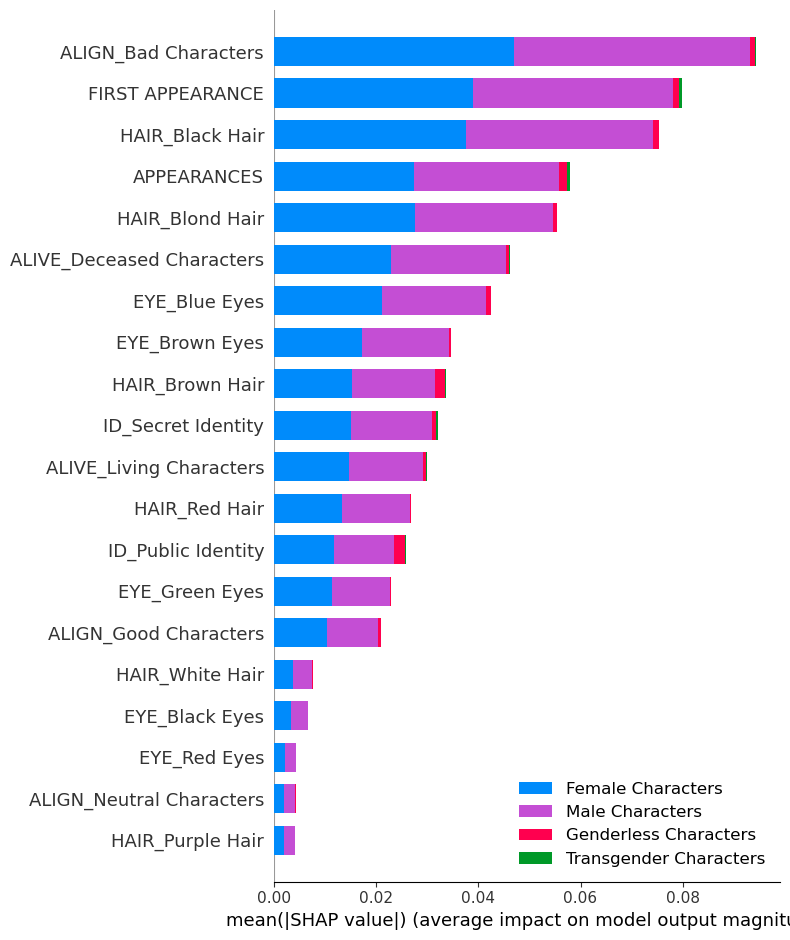

Created Summary plot for DC SEX predictions
Creating Waterfall plot for DC SEX predictions


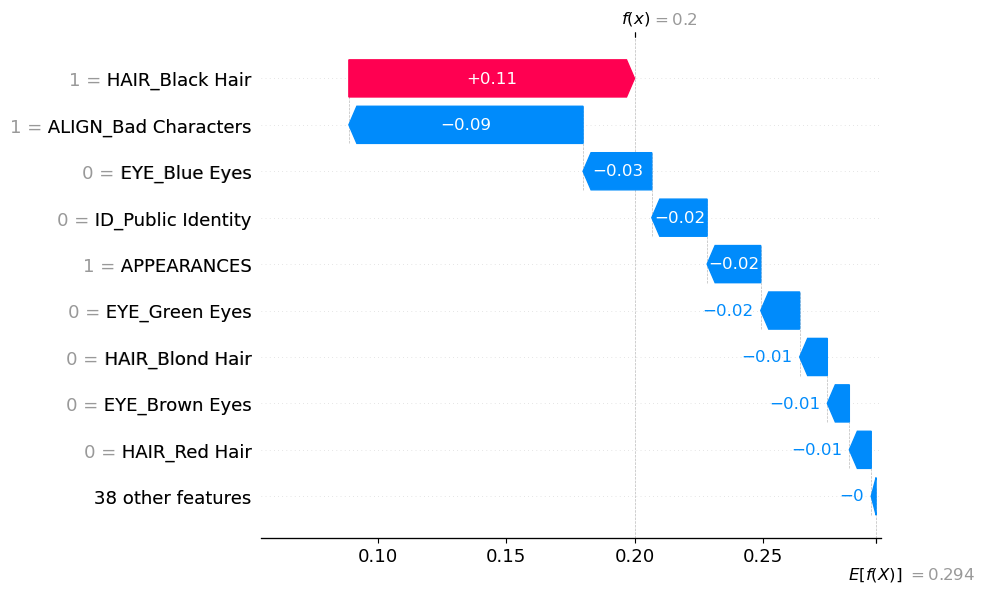

Created Waterfall plot for DC SEX predictions
Creating Summary plot for DC EYE predictions


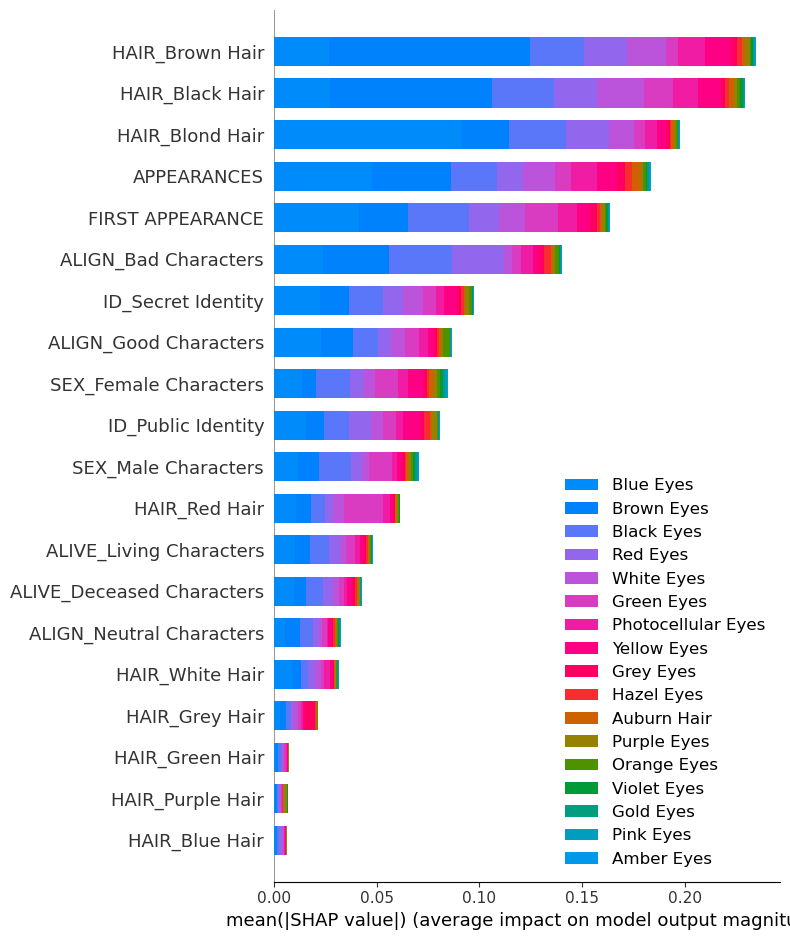

Created Summary plot for DC EYE predictions
Creating Waterfall plot for DC EYE predictions


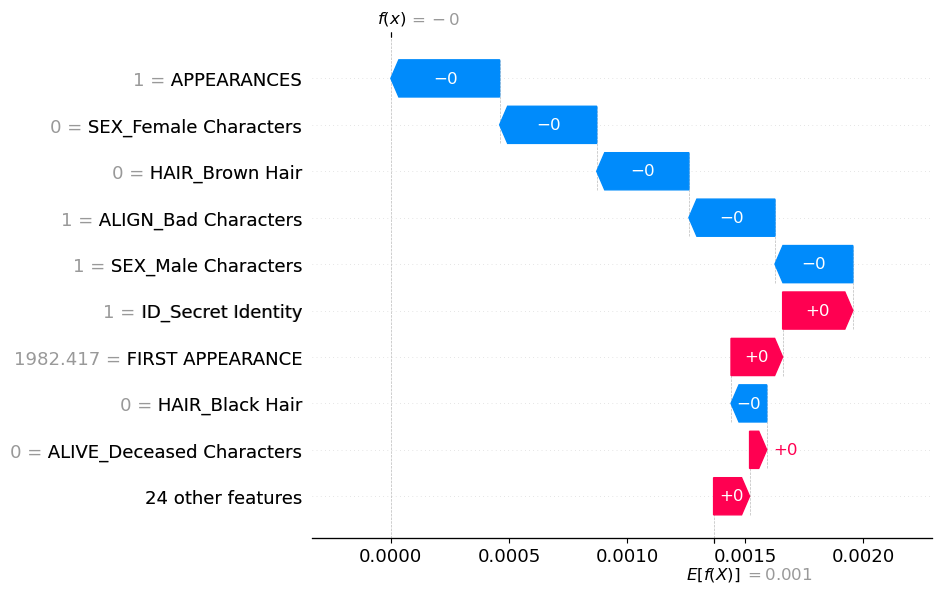

Created Waterfall plot for DC EYE predictions
Creating Summary plot for DC HAIR predictions


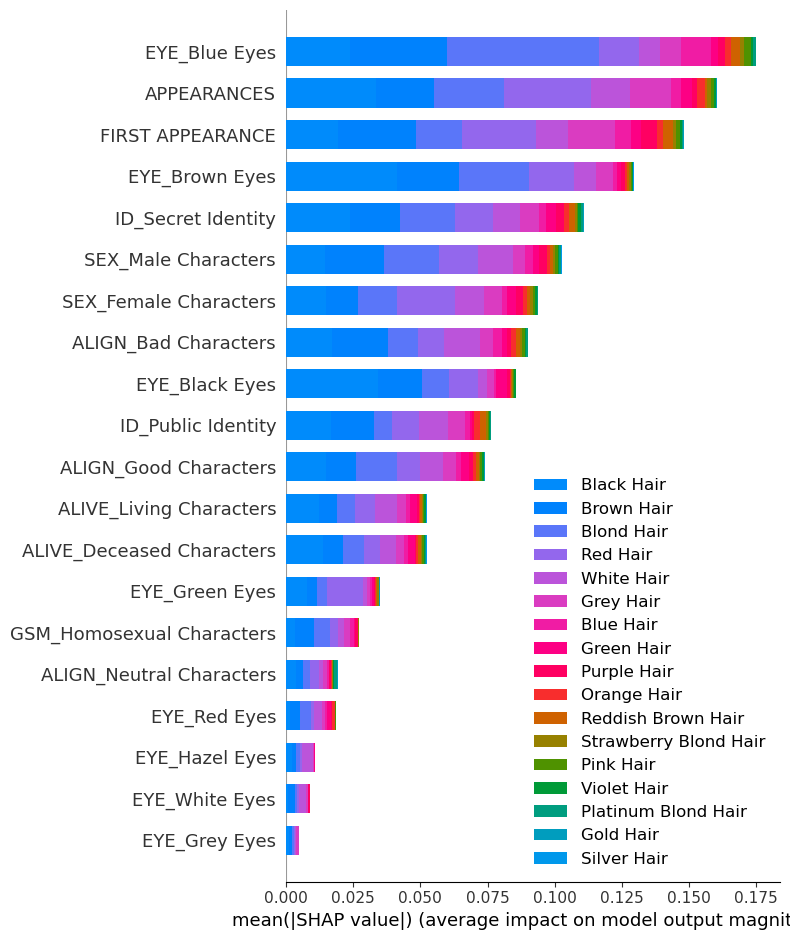

Created Summary plot for DC HAIR predictions
Creating Waterfall plot for DC HAIR predictions


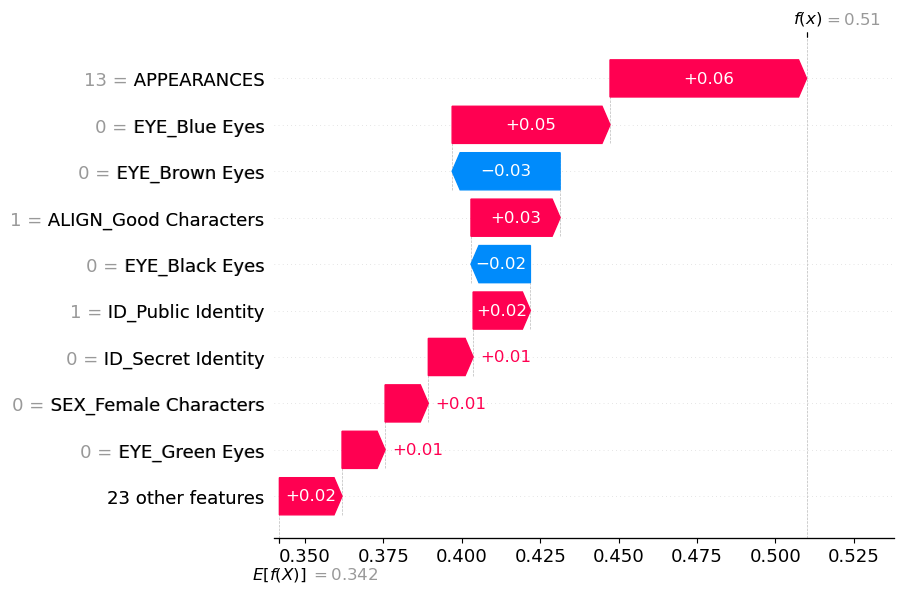

Created Waterfall plot for DC HAIR predictions
Creating Summary plot for DC GSM predictions


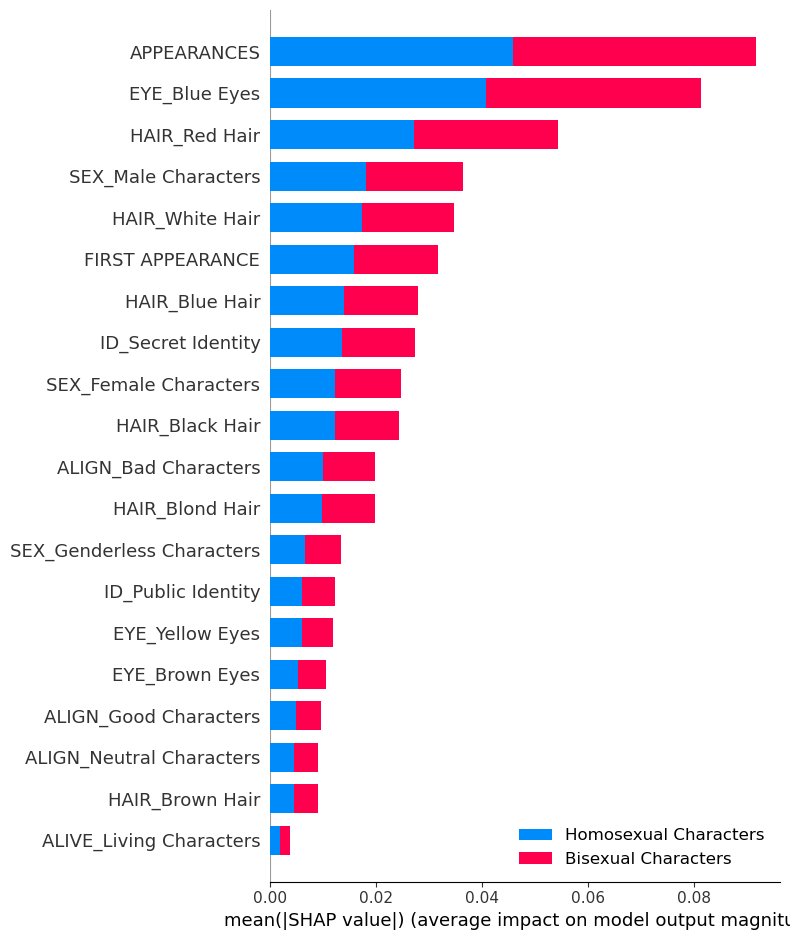

Created Summary plot for DC GSM predictions
Creating Waterfall plot for DC GSM predictions


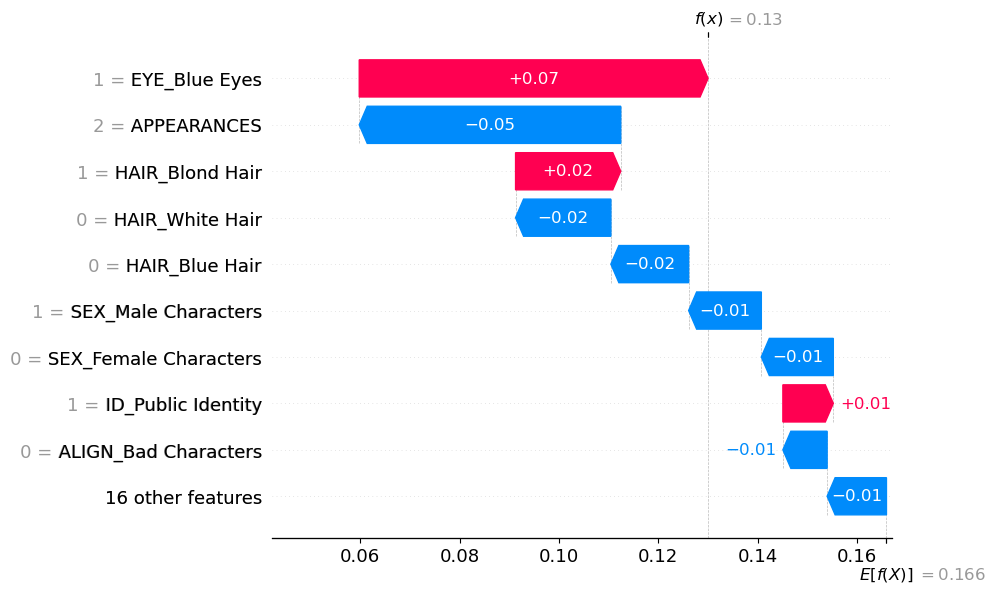

Created Waterfall plot for DC GSM predictions
Creating Summary plot for DC ALIVE predictions


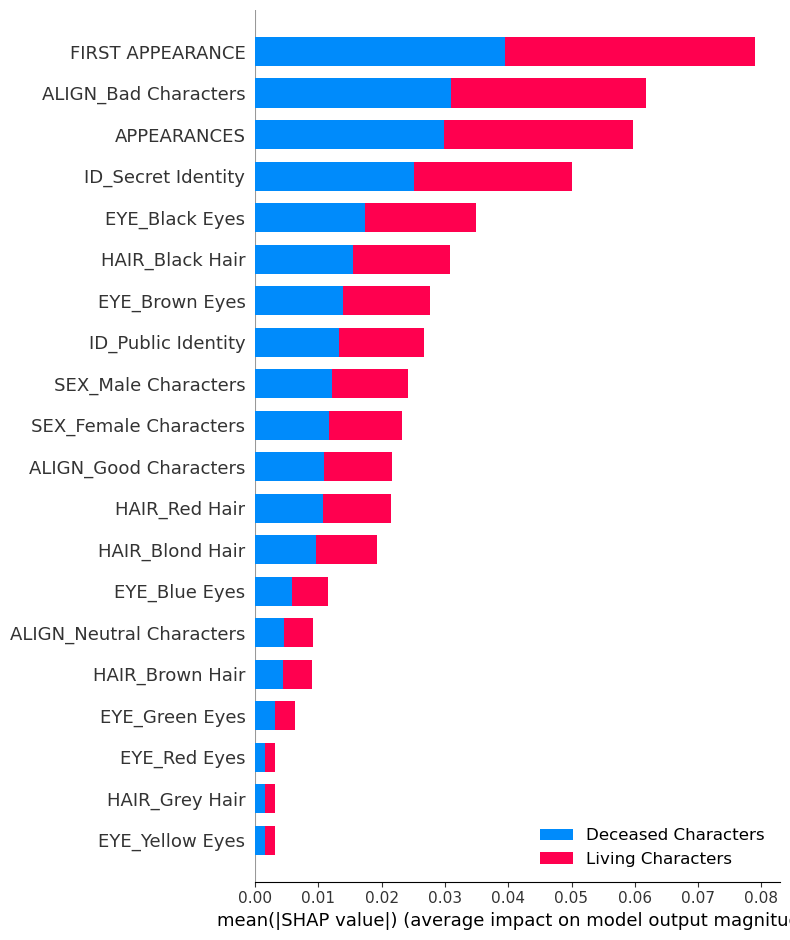

Created Summary plot for DC ALIVE predictions
Creating Waterfall plot for DC ALIVE predictions


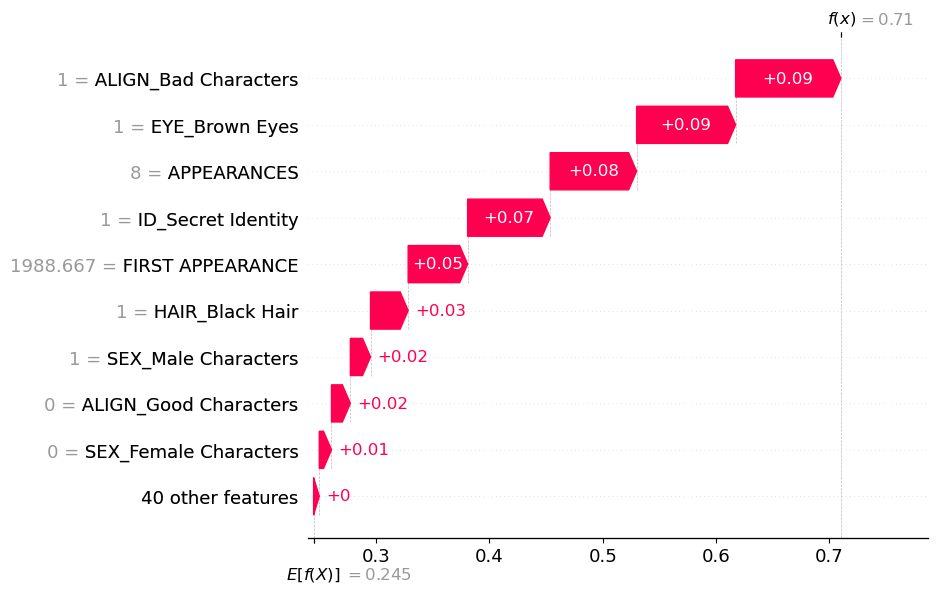

Created Waterfall plot for DC ALIVE predictions
Creating Summary plot for DC ID predictions


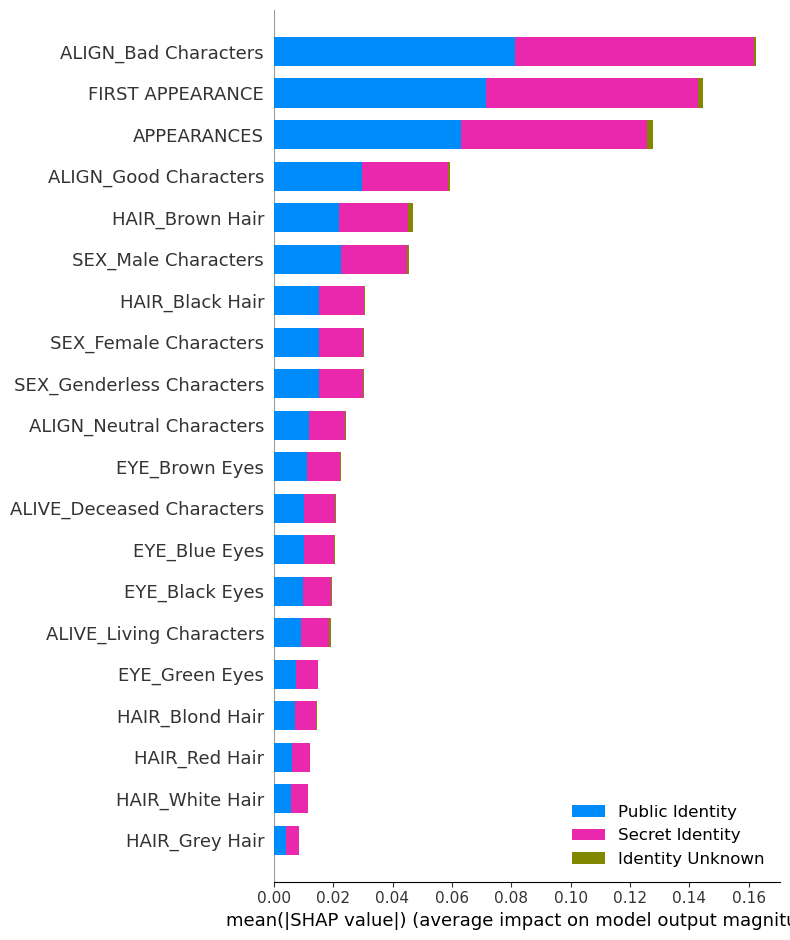

Created Summary plot for DC ID predictions
Creating Waterfall plot for DC ID predictions


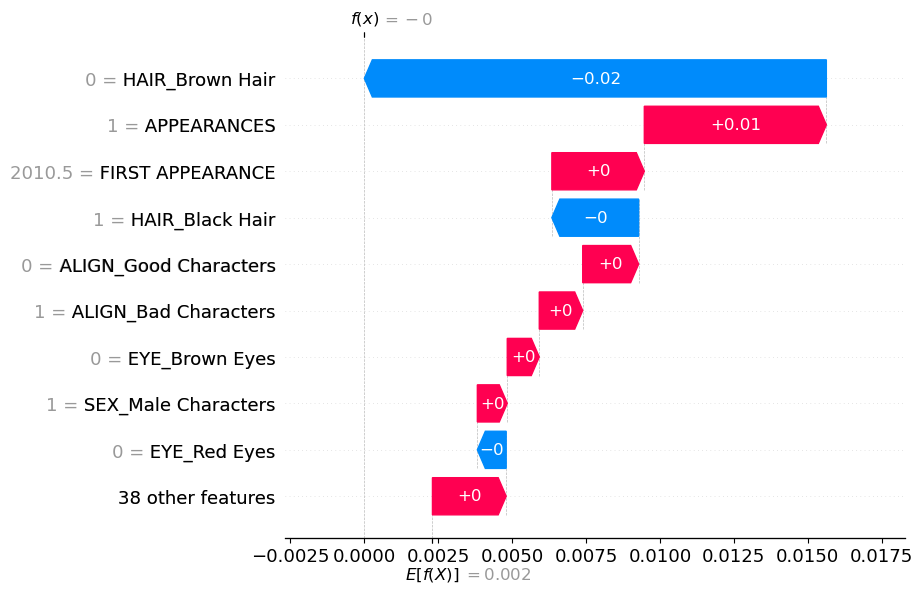

Created Waterfall plot for DC ID predictions
DC plots created


In [27]:
# Create plots for DC

for explainer, shap_values, feature_subset, target_feature, class_names in shap_models_dc:
    sample_index = random.randint(0, len(feature_subset) - 1)

    print(f"""Creating Summary plot for DC {target_feature} predictions""")
    shap.summary_plot(shap_values, feature_subset, feature_names=feature_subset.columns, show=False, class_names=class_names)
    plt.savefig(f"""figs/summary/DC_{target_feature}_summary.png""")
    plt.show()
    print(f"""Created Summary plot for DC {target_feature} predictions""")

    print(f"Creating Waterfall plot for DC {target_feature} predictions")
    shap.plots.waterfall(shap.Explanation(values=shap_values[0][sample_index], base_values=explainer.expected_value[0], data=feature_subset.iloc[sample_index]), max_display=10, show=False)
    plt.savefig(f"figs/waterfall/DC_{target_feature}_{sample_index}_waterfall.png")
    plt.show()
    print(f"Created Waterfall plot for DC {target_feature} predictions")


print("DC plots created")

Creating Summary plot for Combined ALIGN predictions


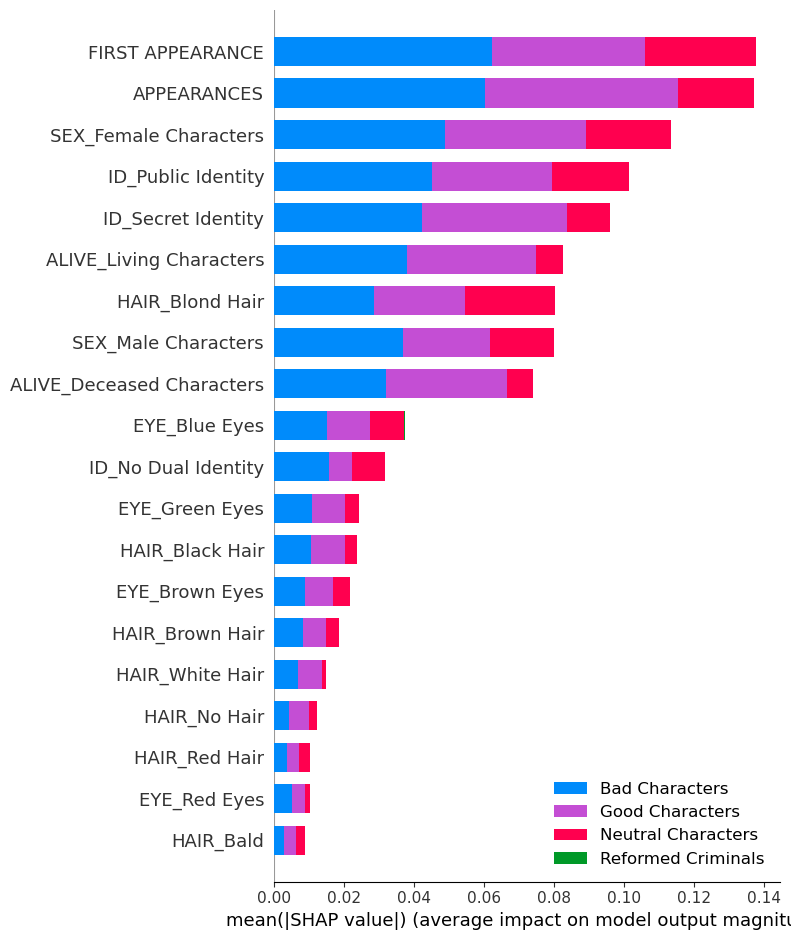

Created Summary plot for Combined ALIGN predictions
Creating Waterfall plot for Combined ALIGN predictions


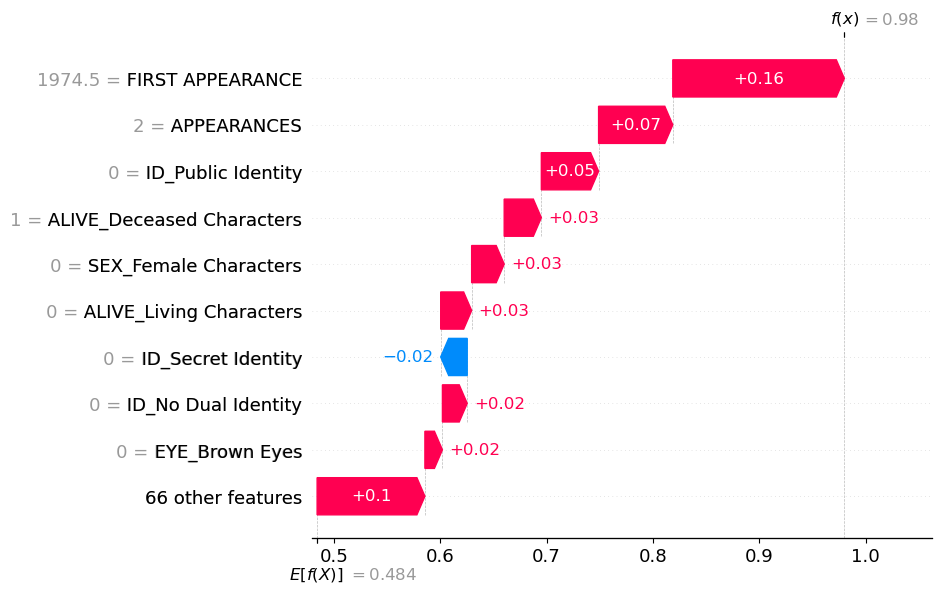

Created Waterfall plot for Combined ALIGN predictions
Creating Summary plot for Combined SEX predictions


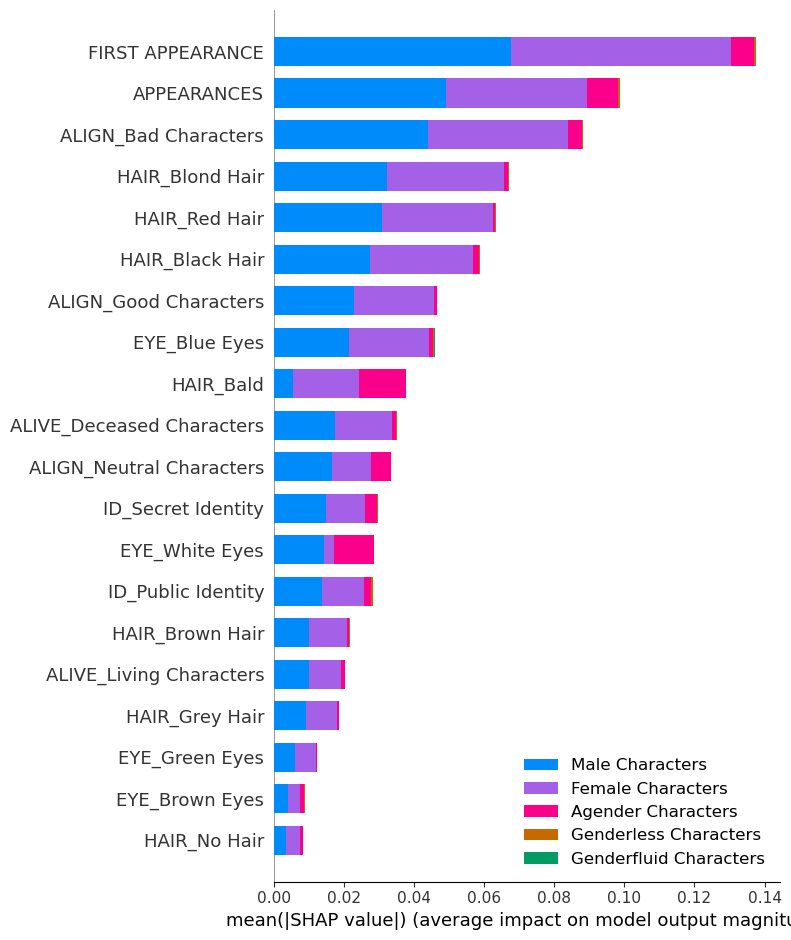

Created Summary plot for Combined SEX predictions
Creating Waterfall plot for Combined SEX predictions


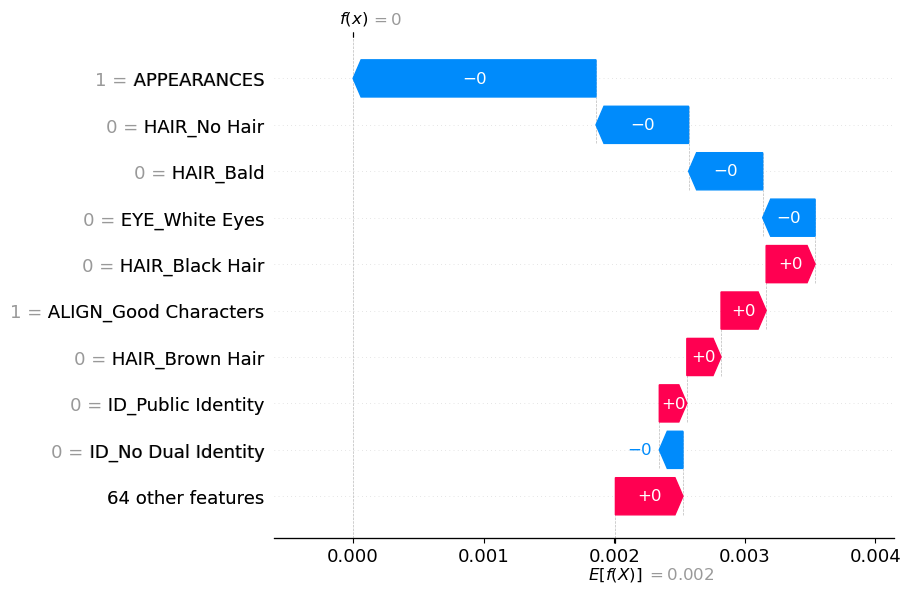

Created Waterfall plot for Combined SEX predictions
Creating Summary plot for Combined EYE predictions


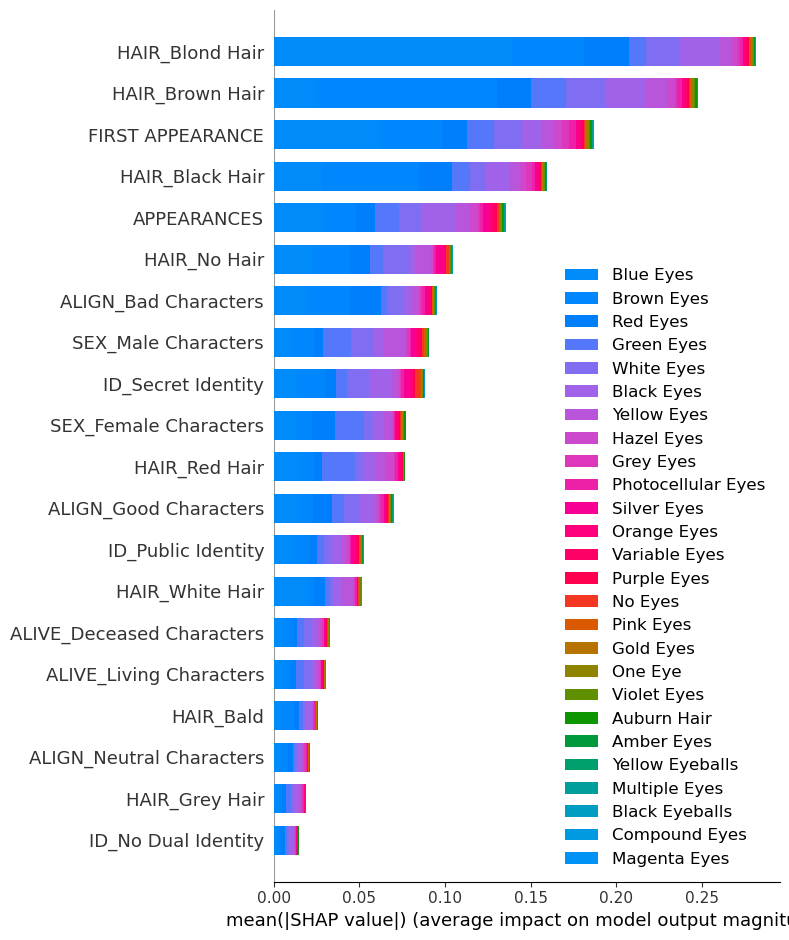

Created Summary plot for Combined EYE predictions
Creating Waterfall plot for Combined EYE predictions


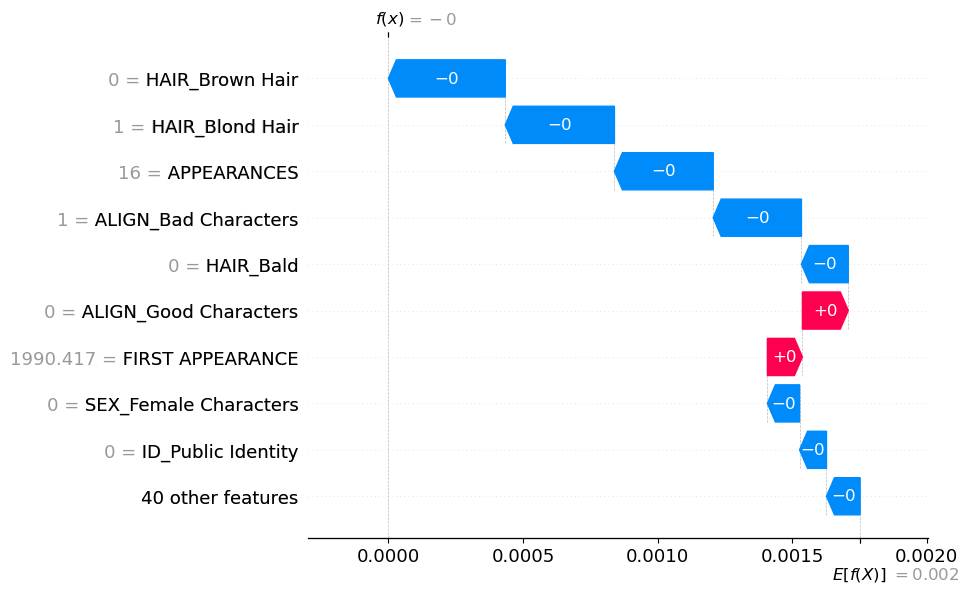

Created Waterfall plot for Combined EYE predictions
Creating Summary plot for Combined HAIR predictions


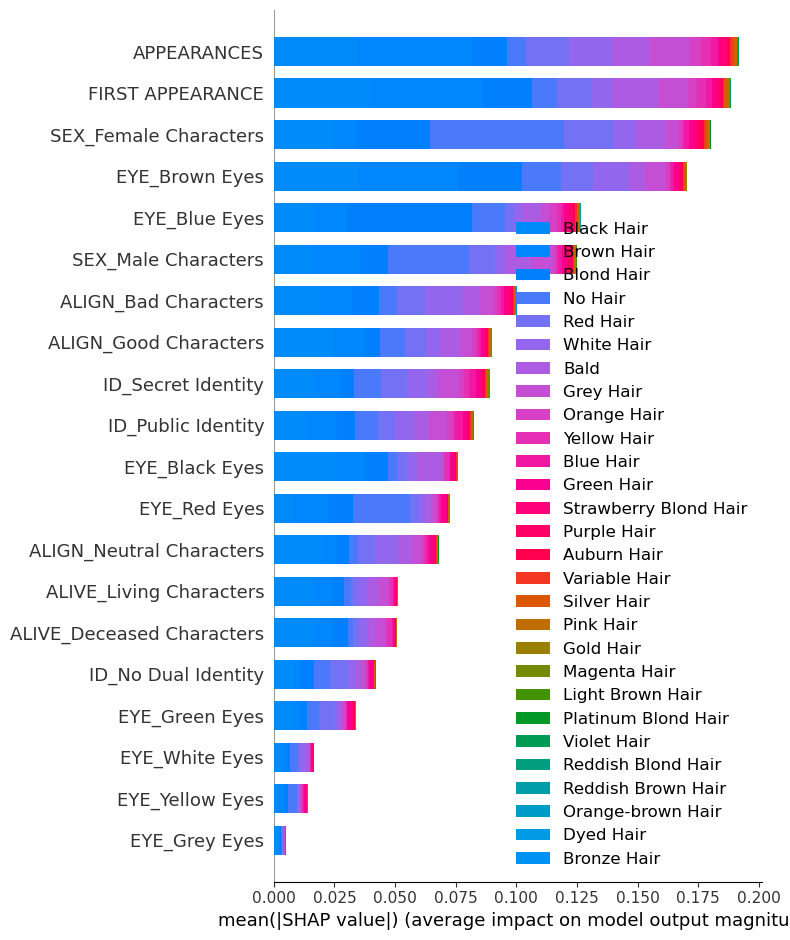

Created Summary plot for Combined HAIR predictions
Creating Waterfall plot for Combined HAIR predictions


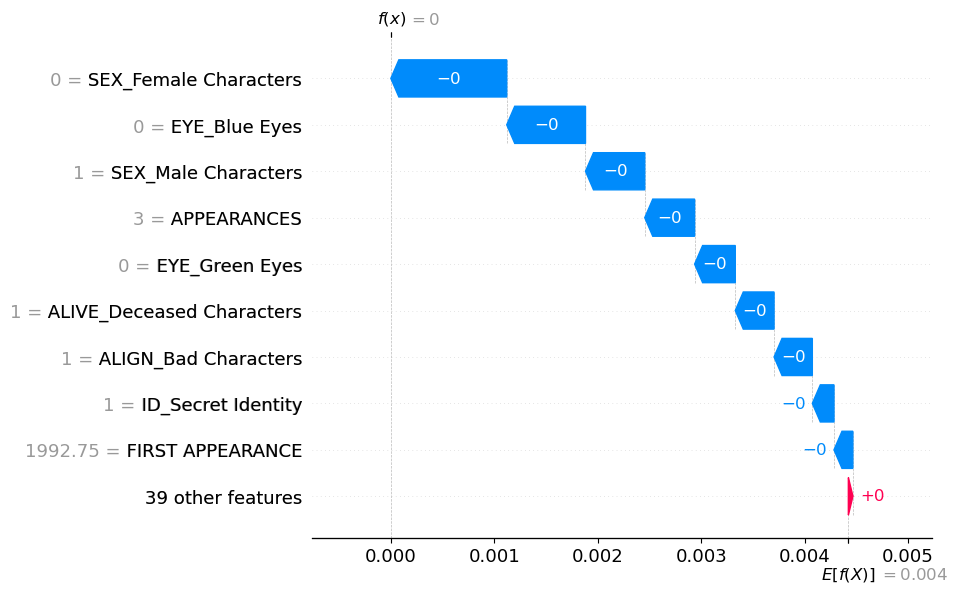

Created Waterfall plot for Combined HAIR predictions
Creating Summary plot for Combined GSM predictions


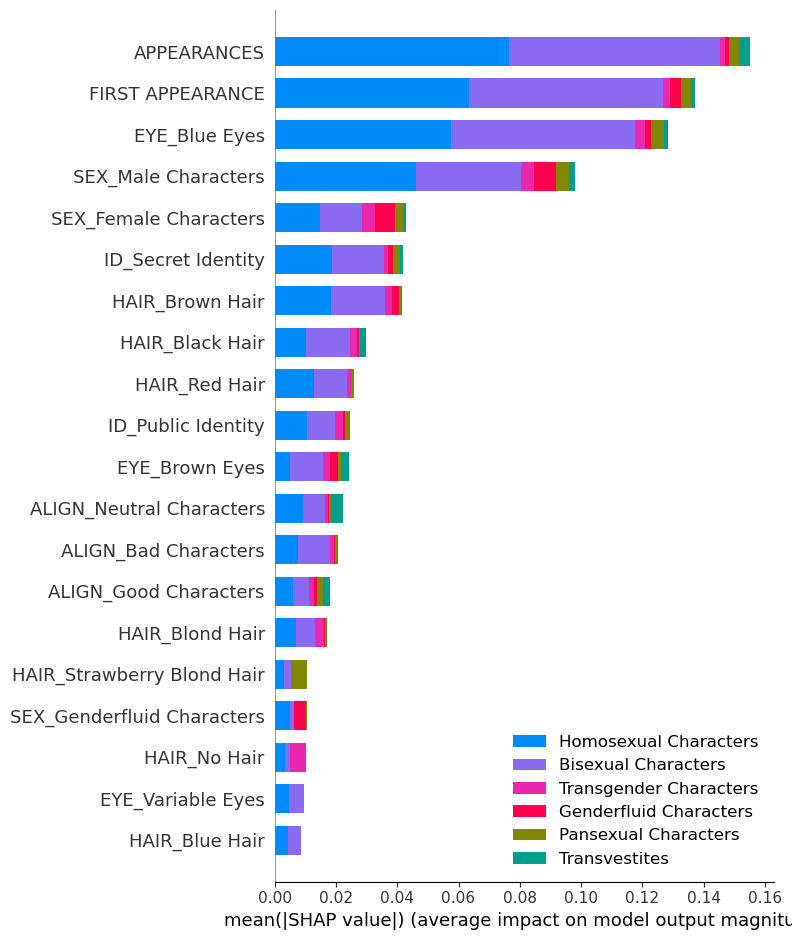

Created Summary plot for Combined GSM predictions
Creating Waterfall plot for Combined GSM predictions


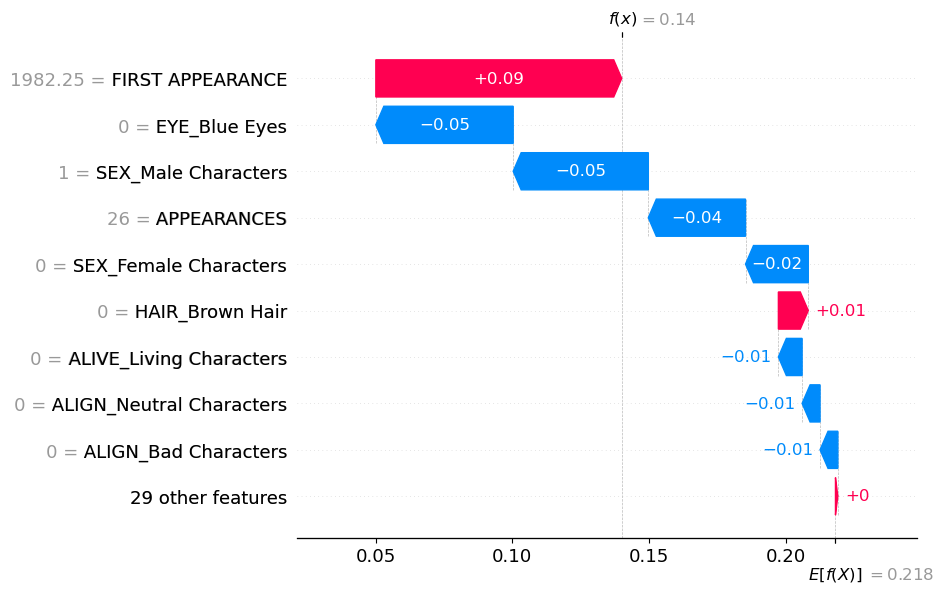

Created Waterfall plot for Combined GSM predictions
Creating Summary plot for Combined ALIVE predictions


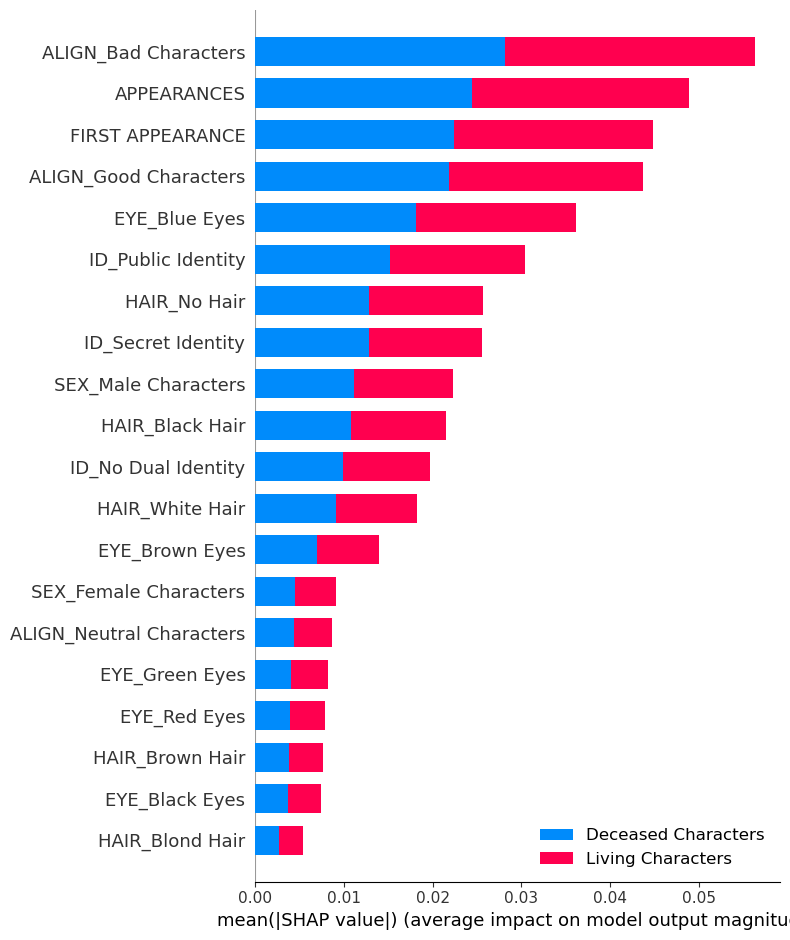

Created Summary plot for Combined ALIVE predictions
Creating Waterfall plot for Combined ALIVE predictions


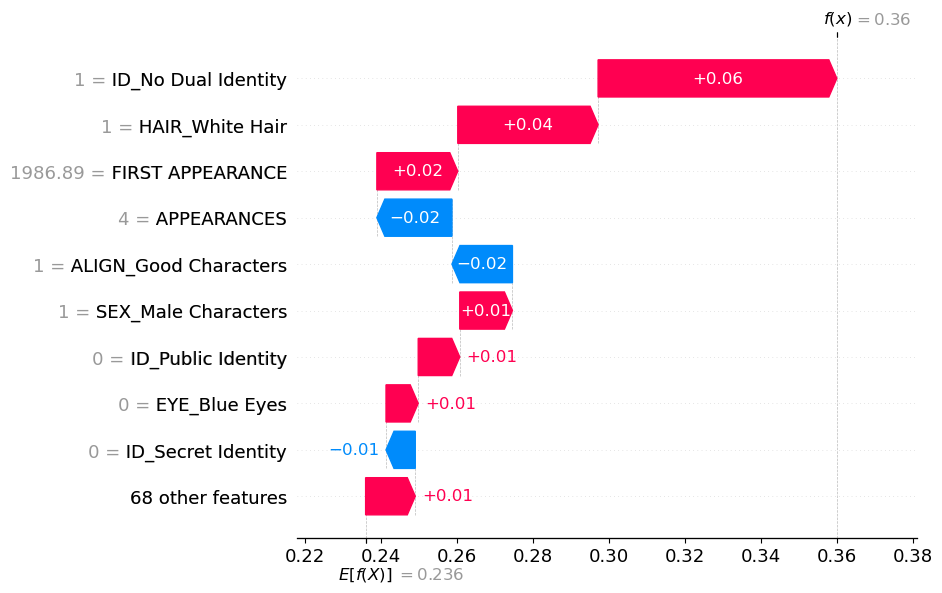

Created Waterfall plot for Combined ALIVE predictions
Creating Summary plot for Combined ID predictions


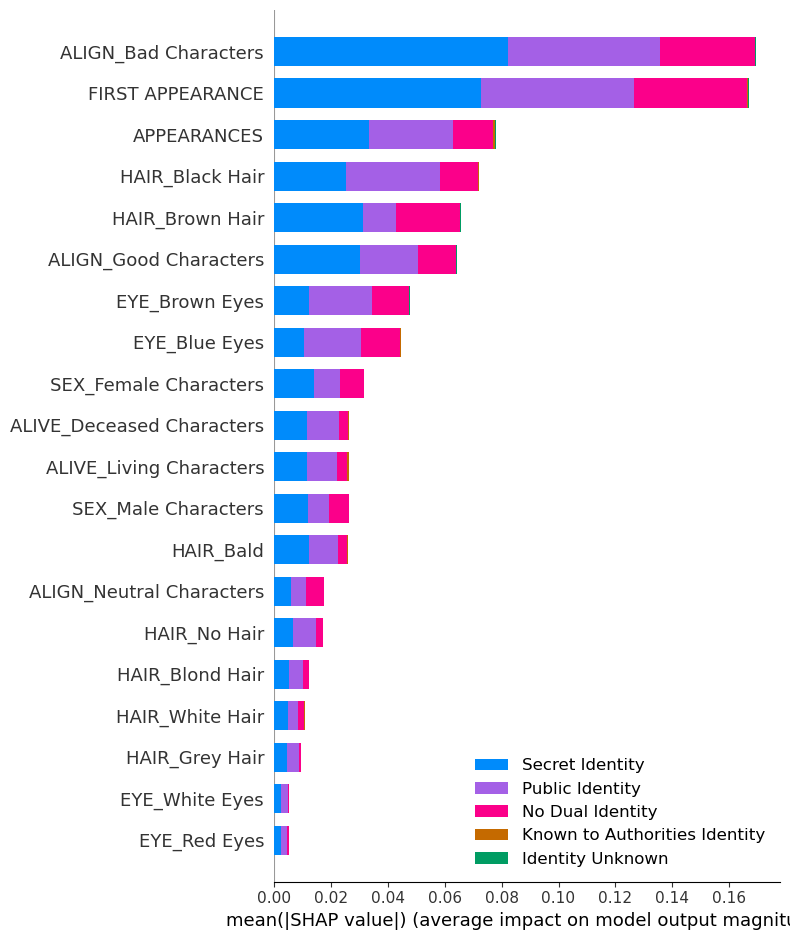

Created Summary plot for Combined ID predictions
Creating Waterfall plot for Combined ID predictions


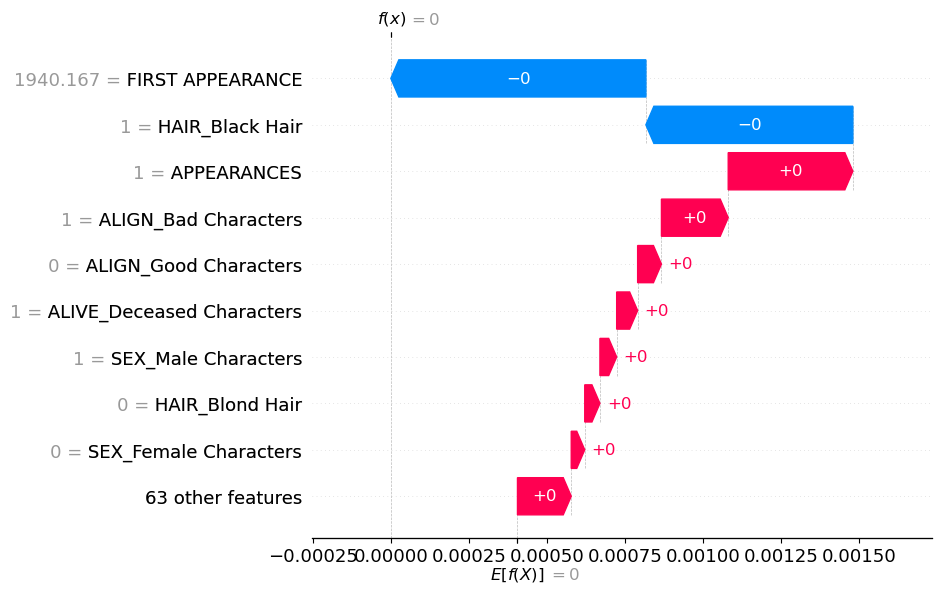

Created Waterfall plot for Combined ID predictions
Combined plots created


In [28]:
# Create plots for Combined

for explainer, shap_values, feature_subset, target_feature, class_names in shap_models_combined:
    sample_index = random.randint(0, len(feature_subset) - 1)

    print(f"""Creating Summary plot for Combined {target_feature} predictions""")
    shap.summary_plot(shap_values, feature_subset, feature_names=feature_subset.columns, show=False, class_names=class_names)
    plt.savefig(f"""figs/summary/Combined_{target_feature}_summary.png""")
    plt.show()
    print(f"""Created Summary plot for Combined {target_feature} predictions""")

    print(f"Creating Waterfall plot for Combined {target_feature} predictions")
    shap.plots.waterfall(shap.Explanation(values=shap_values[0][sample_index], base_values=explainer.expected_value[0], data=feature_subset.iloc[sample_index]), max_display=10, show=False)
    plt.savefig(f"figs/waterfall/Combined_{target_feature}_{sample_index}_waterfall.png")
    plt.show()
    print(f"Created Waterfall plot for Combined {target_feature} predictions")

print("Combined plots created")

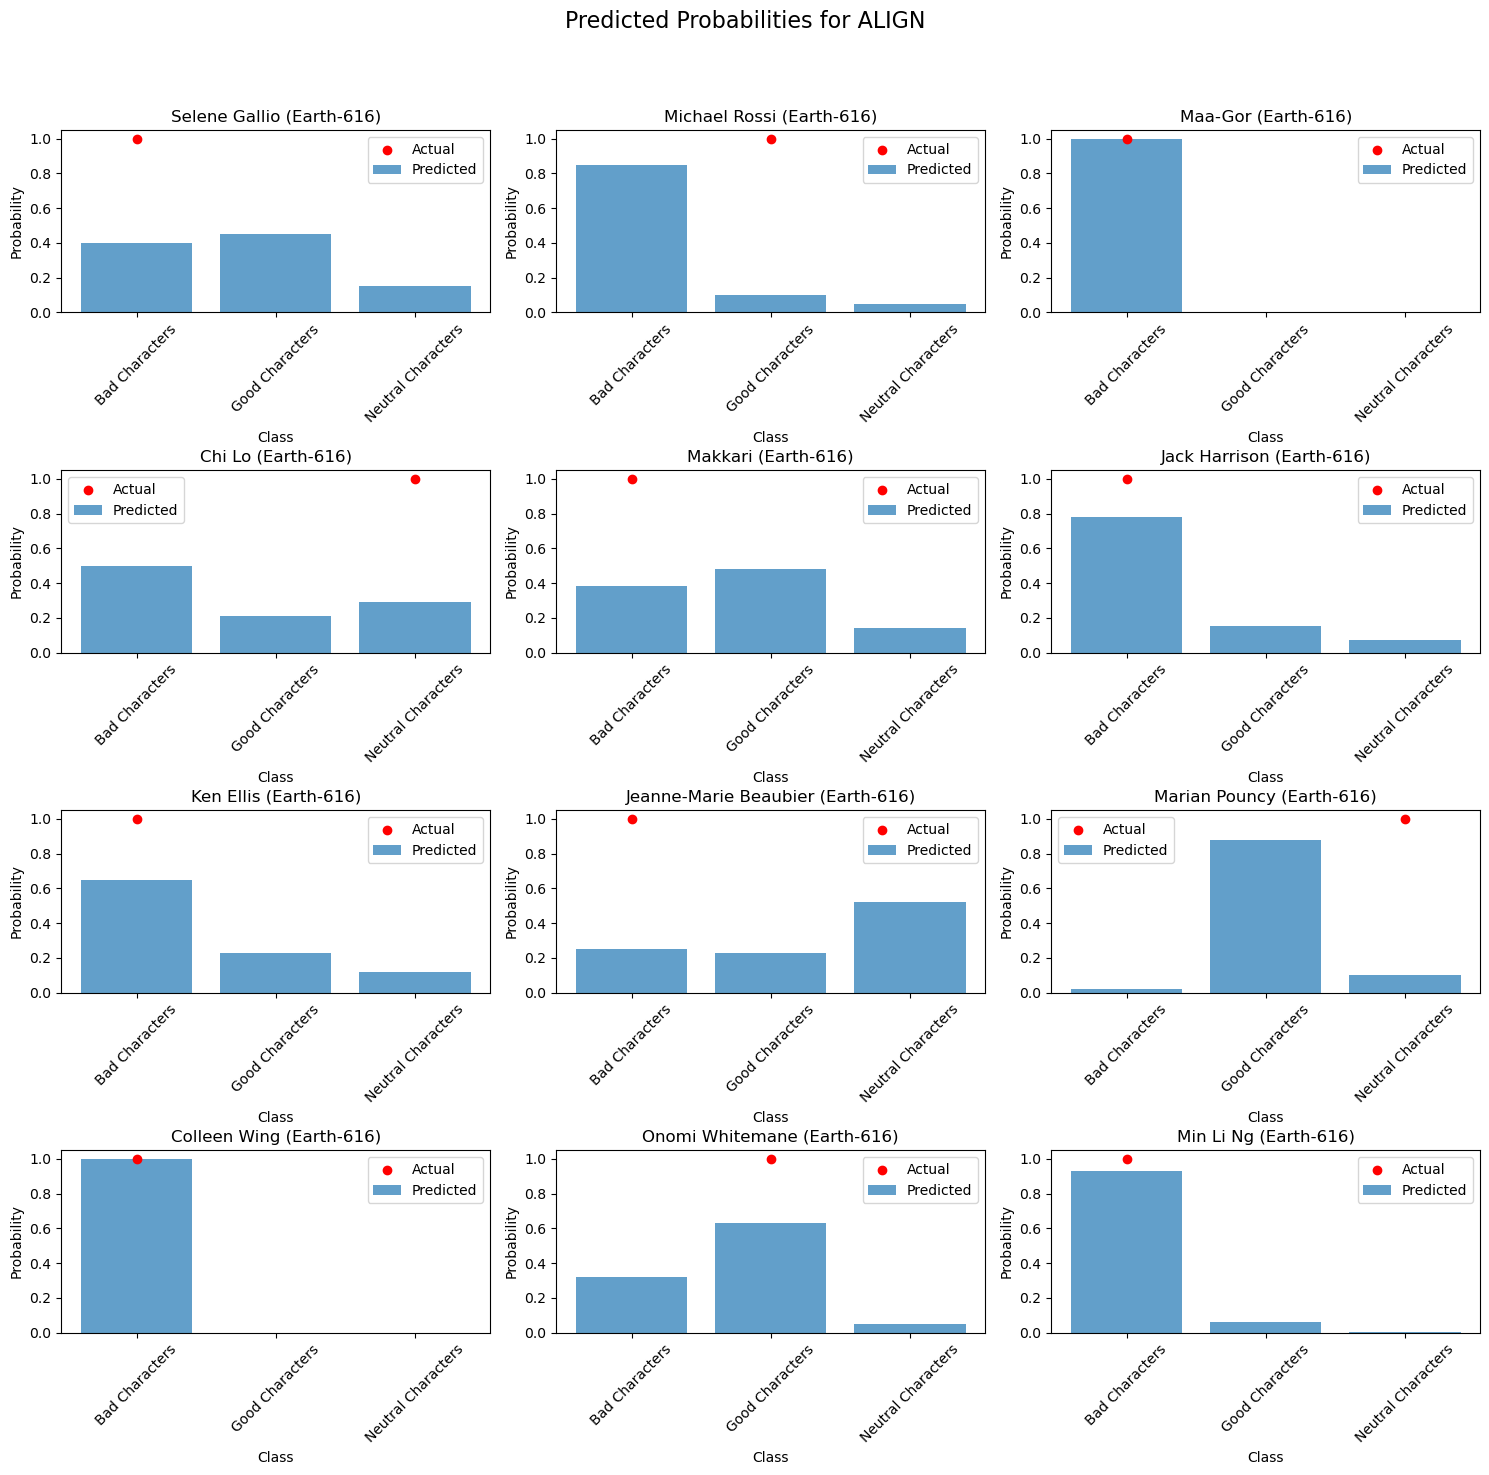

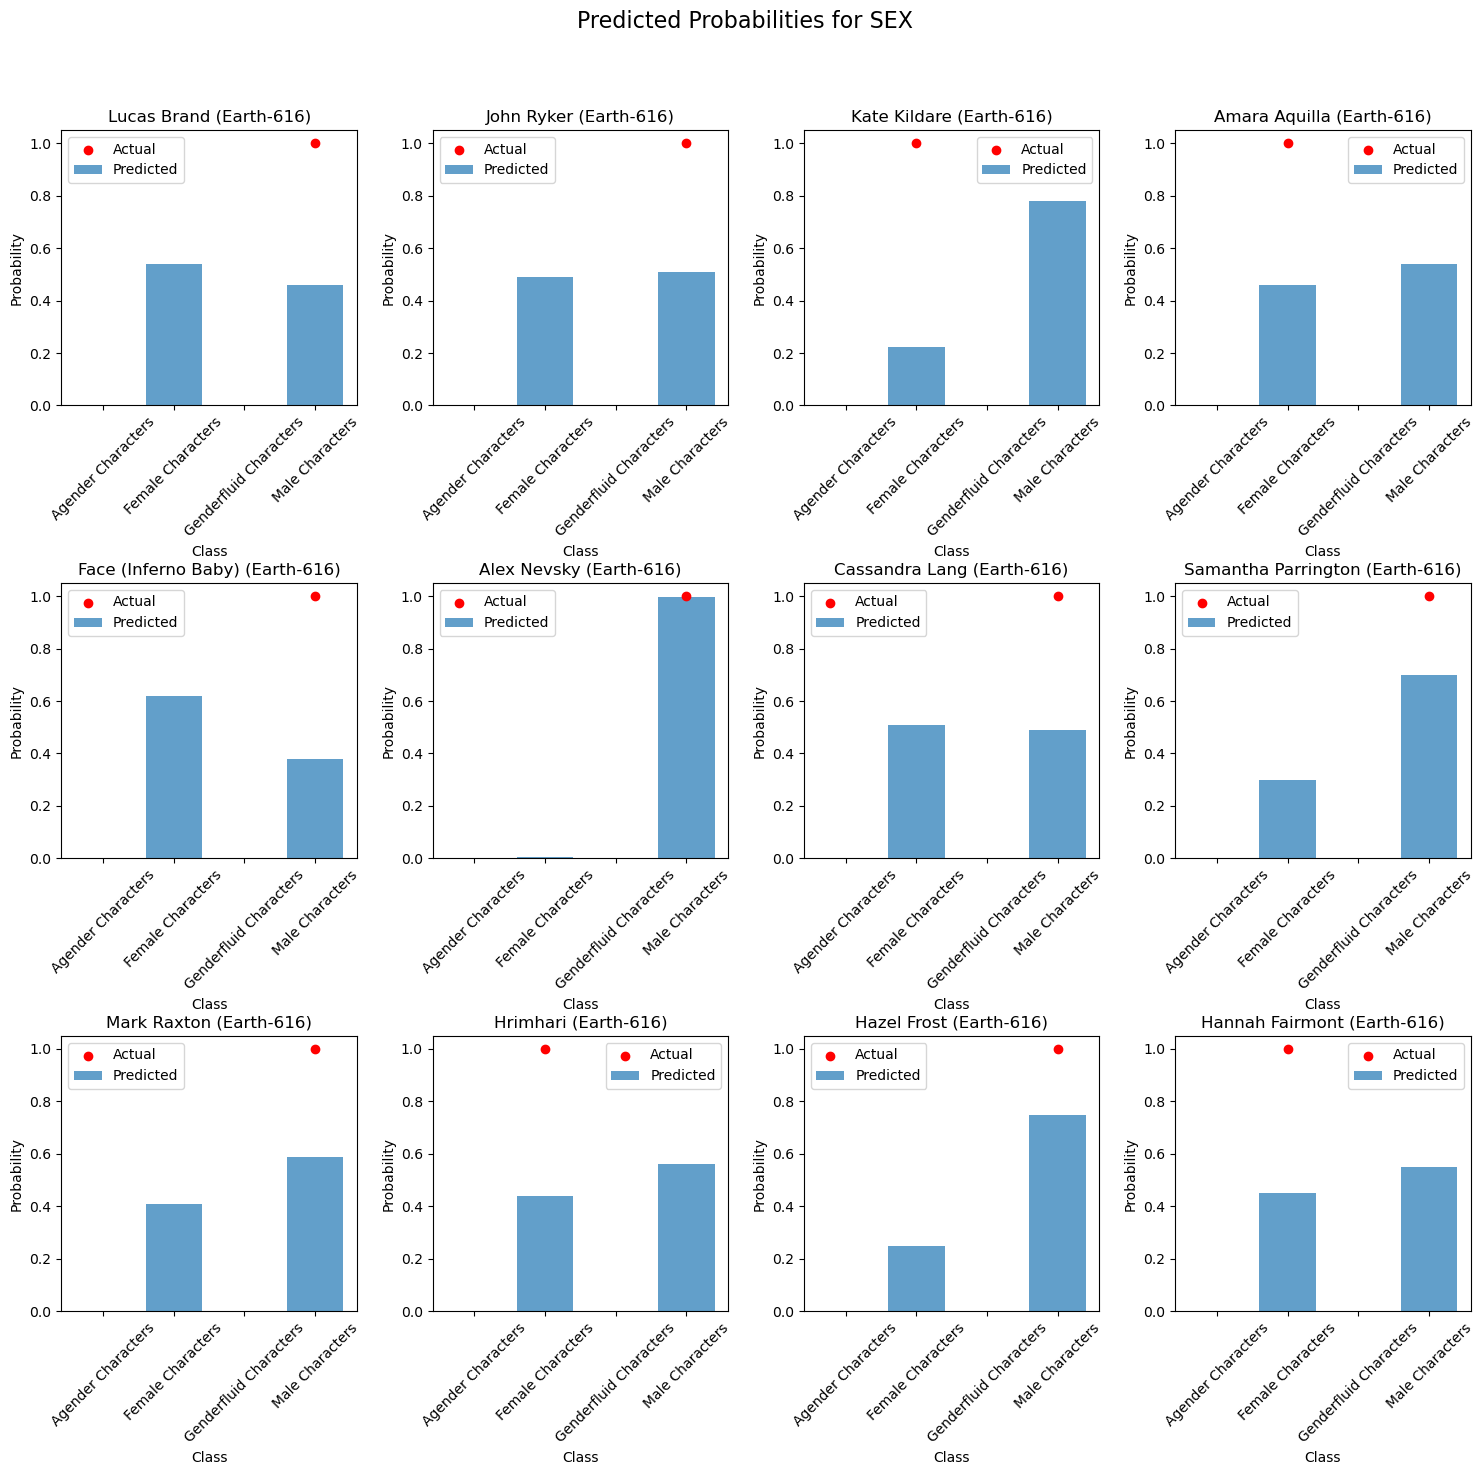

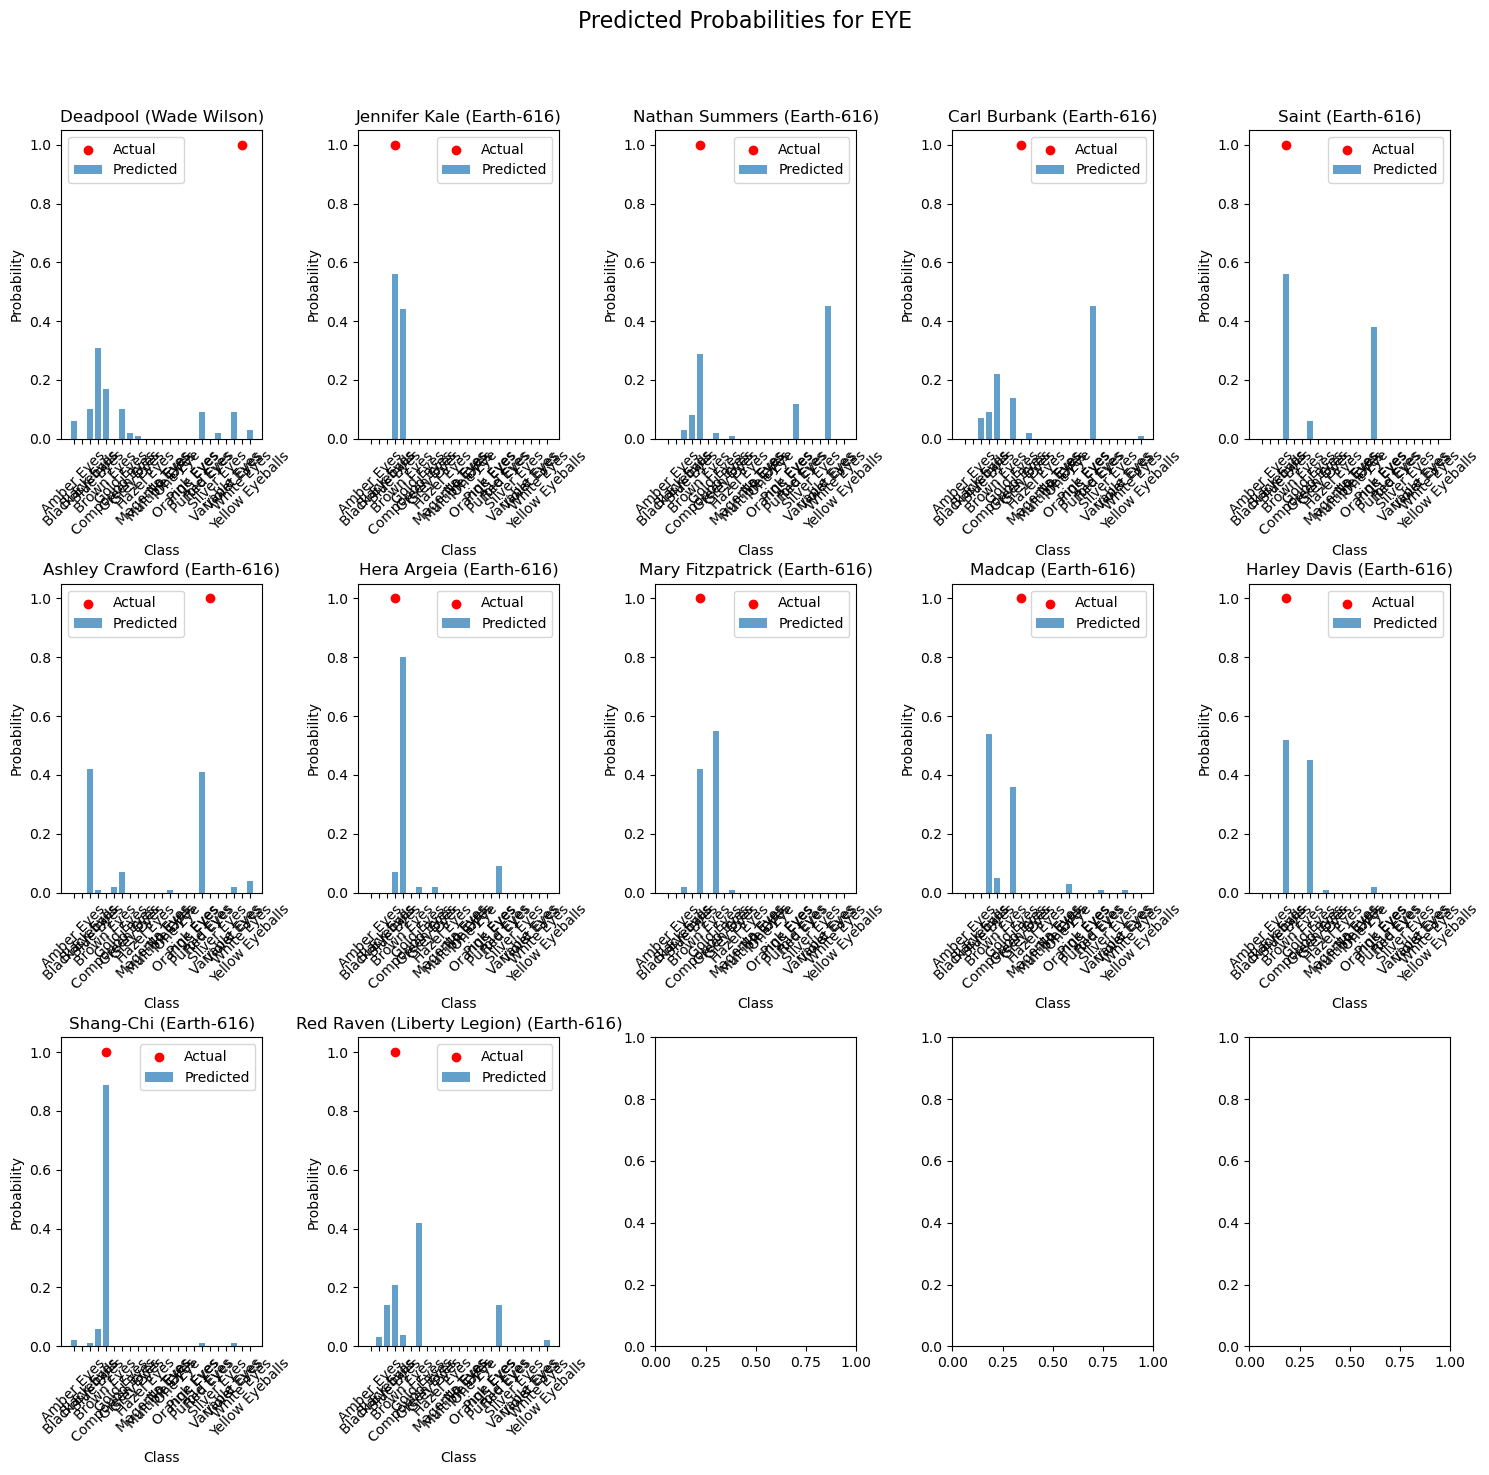

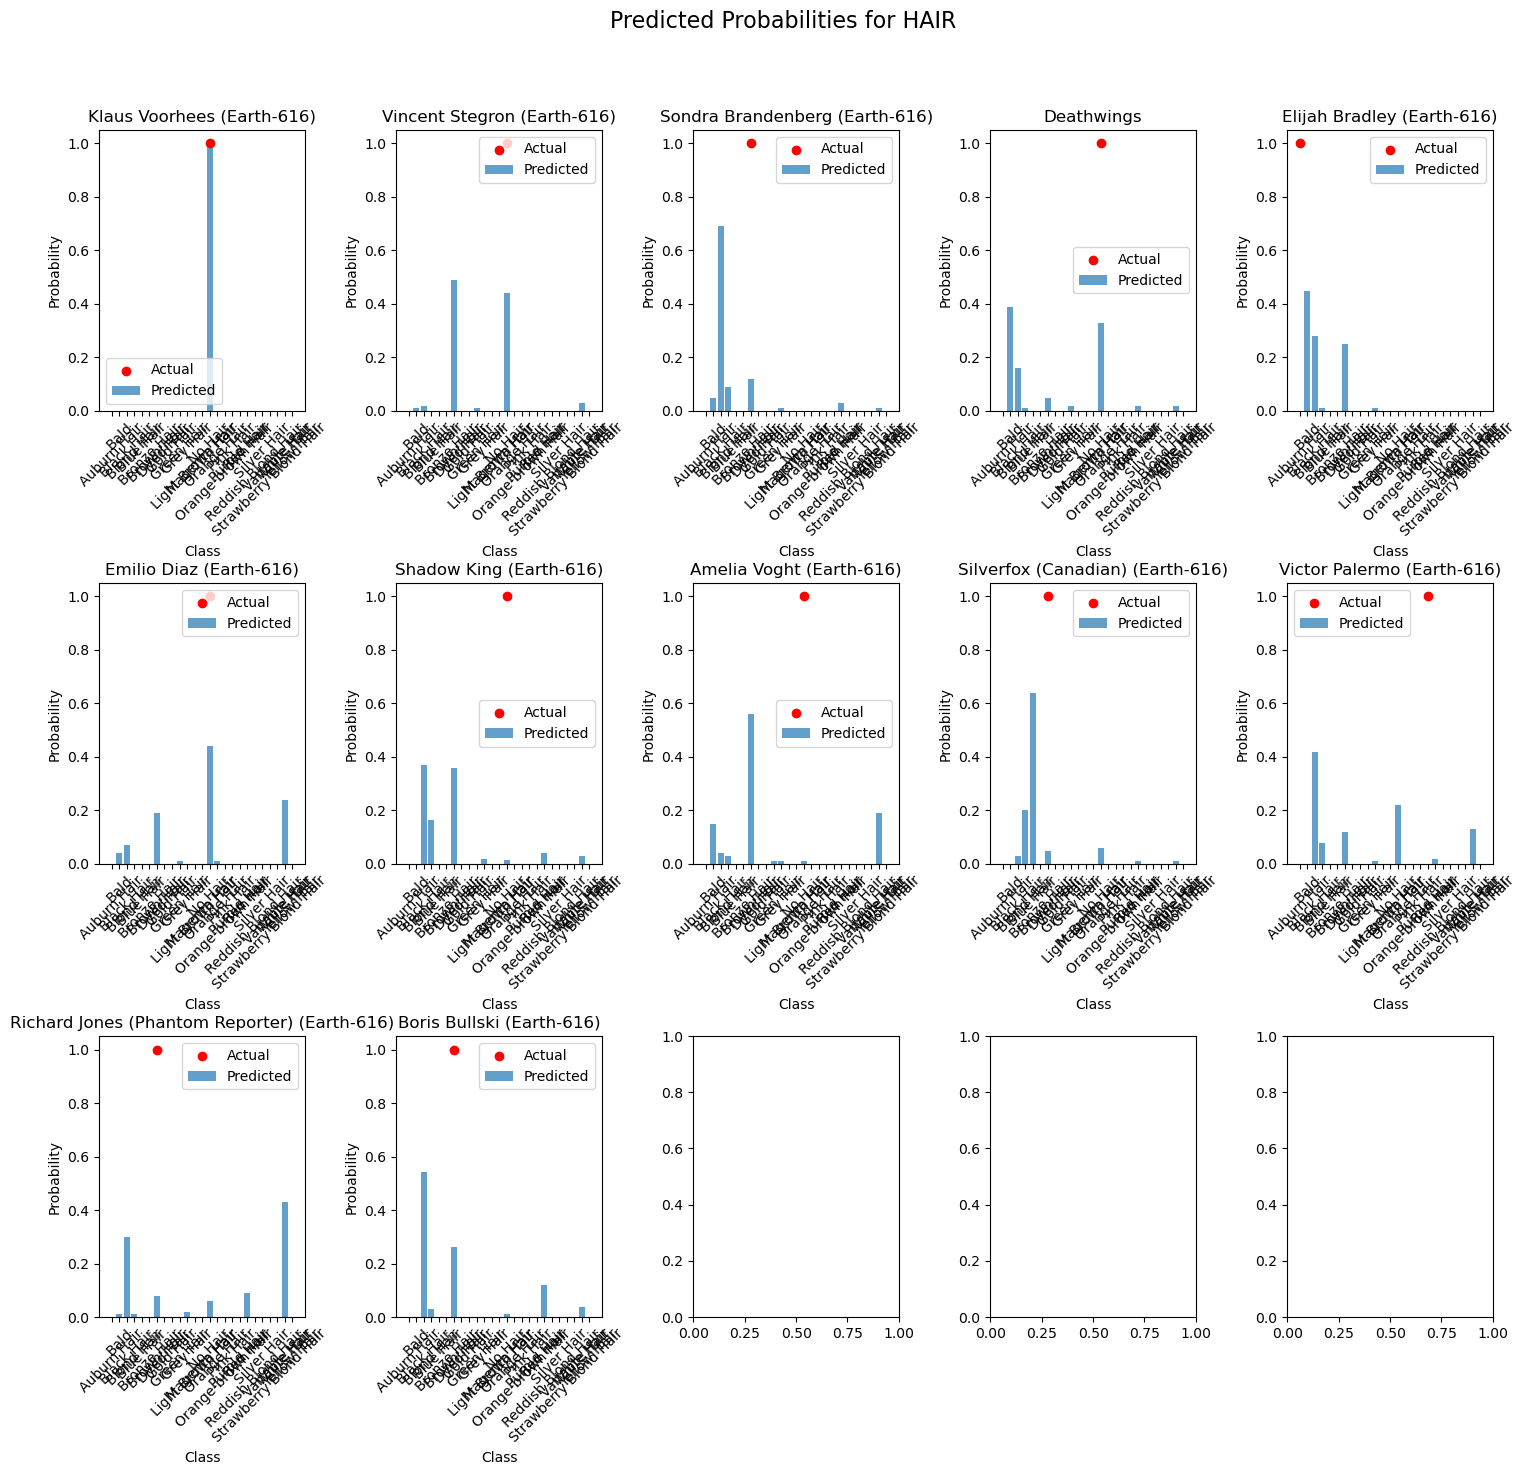

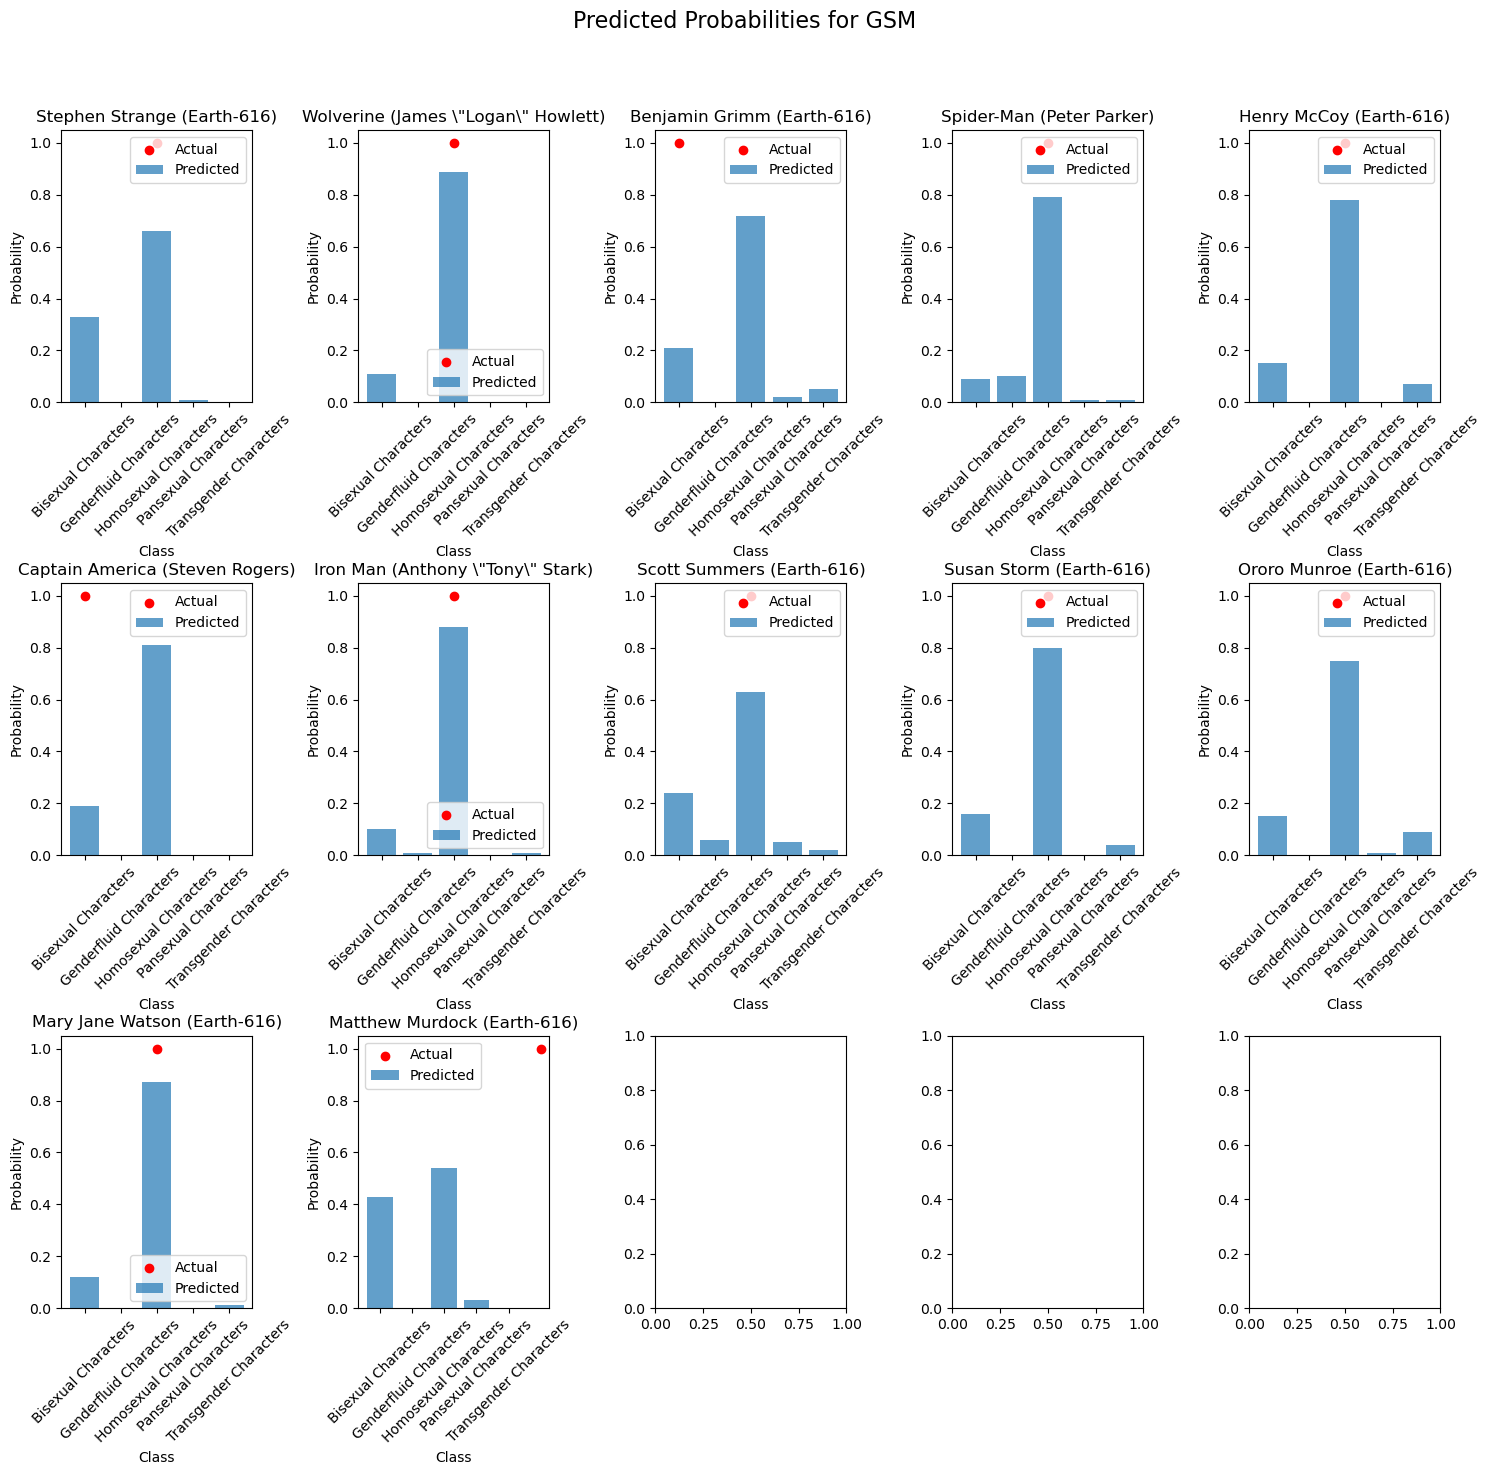

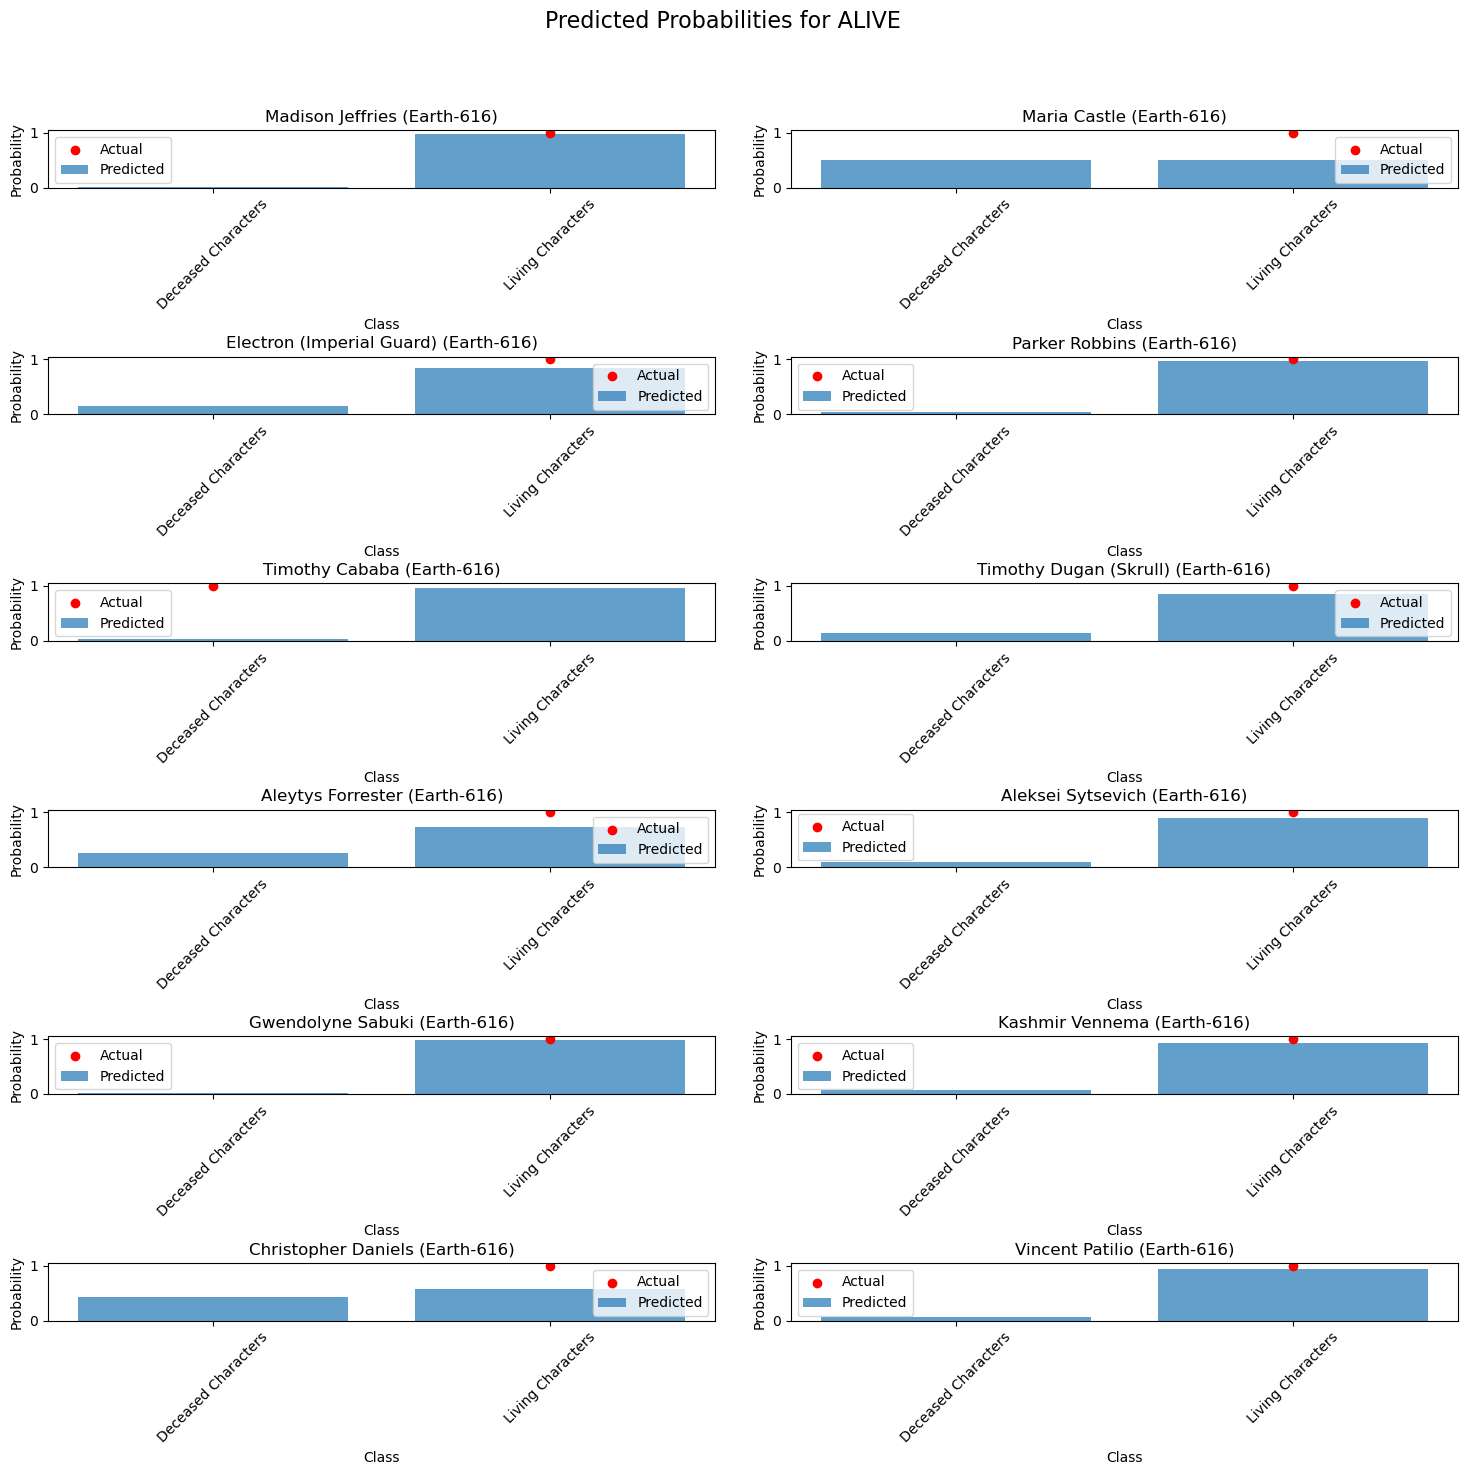

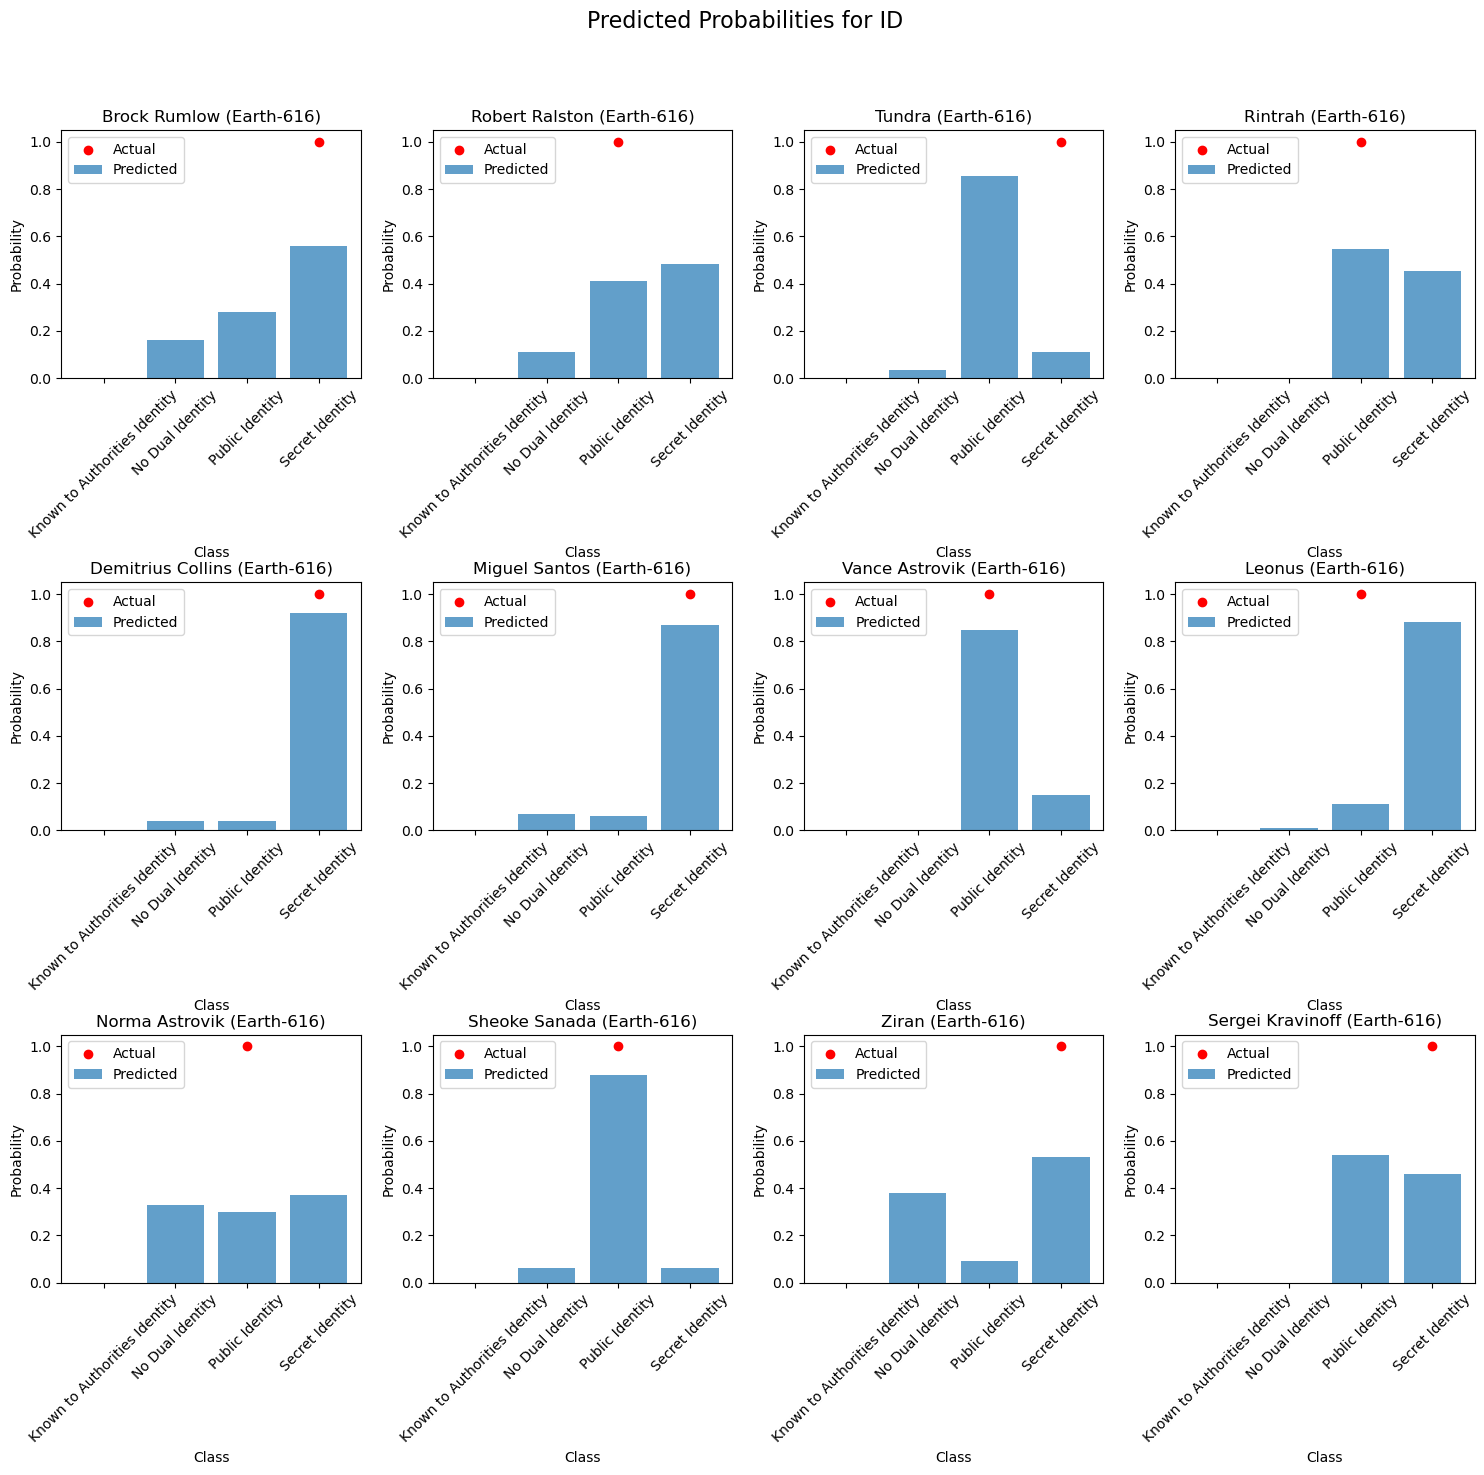

In [29]:
import math

# Loop through each dataset
for rf_model, X_train, y_train, X_test, y_test, target_feature, class_names in rf_models_marvel:
    # Select a random subset of instances from the test data
    num_instances = min((int(len(X_test) * 0.1) if len(X_test) > 250 else len(X_test)), 12)
    selected_indices = np.random.choice(len(X_test), num_instances, replace=False)
    X_test_subset = X_test.iloc[selected_indices]
    y_test_subset = y_test[selected_indices]
    
    # Get the predicted probabilities for the selected instances in the test data
    predicted_probabilities = rf_model.predict_proba(X_test_subset)

    # Get the subset of class names corresponding to the number of classes
    subset_class_names = class_names[:predicted_probabilities.shape[1]]

    # Calculate the number of rows and columns for subplots
    num_instances_subset, num_classes = predicted_probabilities.shape
    num_columns = min(num_classes, 5)  # Limit the number of columns to avoid too many subplots
    num_rows = math.ceil(num_instances_subset / num_columns)

    # Create a larger plot with subplots
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 15))
    fig.suptitle(f"Predicted Probabilities for {target_feature}", fontsize=16)

    # Loop through each instance and its corresponding predicted probabilities
    for i, (probs, ax) in enumerate(zip(predicted_probabilities, axes.flatten())):
        character_name = str(marvel_names[selected_indices[i]])  # Convert to string
        actual_class = y_test_subset[i]  # Get the actual class value
        
        # Plot the predicted probabilities as a bar chart
        ax.bar(subset_class_names, probs, label="Predicted", alpha=0.7)
        
        # Plot the actual class value as a point on top of the predicted probabilities
        ax.scatter(actual_class, 1, color="red", label="Actual")
        
        ax.set_title(character_name)  # Set character name as the title
        ax.set_xlabel("Class")
        ax.set_ylabel("Probability")
        ax.set_xticks(range(len(subset_class_names)))  # Set tick positions
        ax.set_xticklabels(subset_class_names, rotation=45)  # Set tick labels
        ax.legend()  # Show legend
        
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.savefig(f"""figs/prob_charts/Marvel_{target_feature}_{selected_indices}_probabilities.png""")
    plt.show()


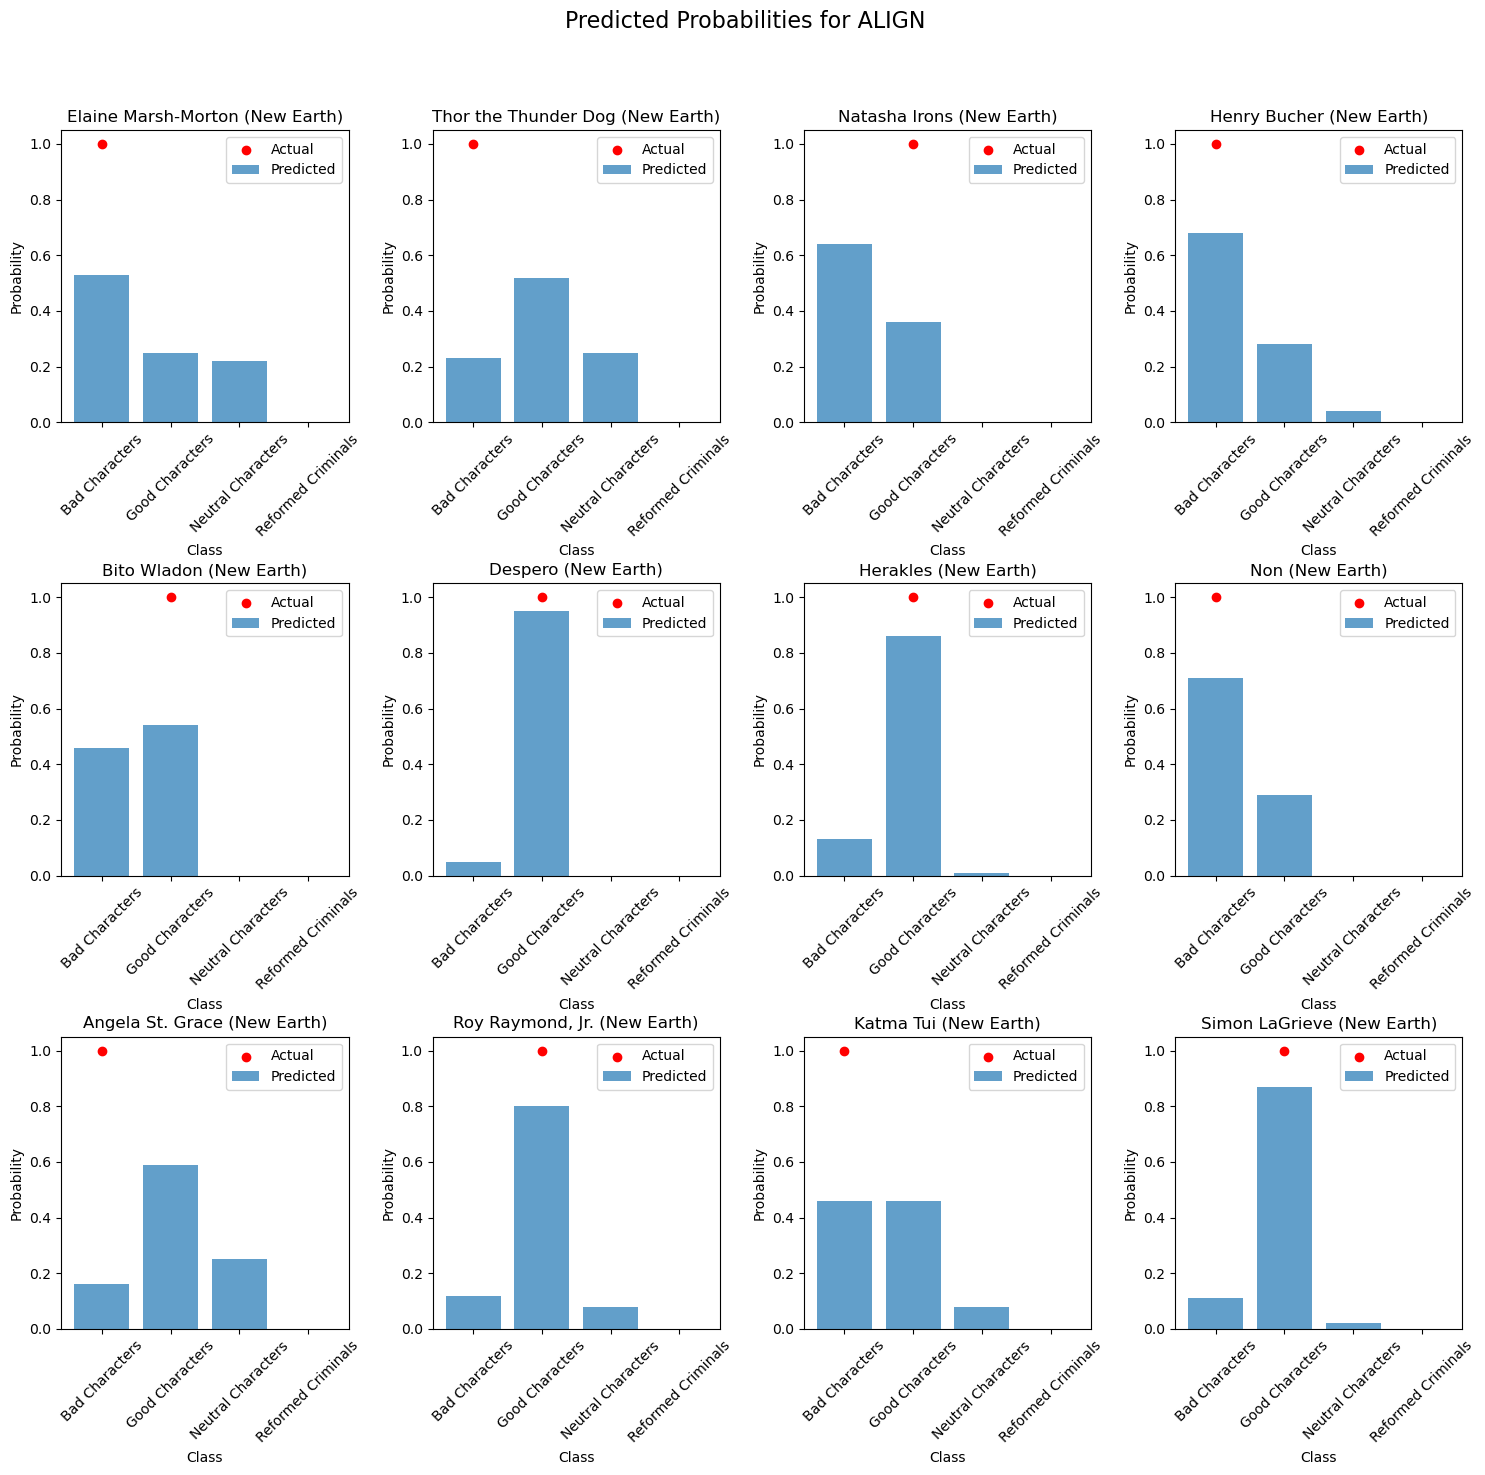

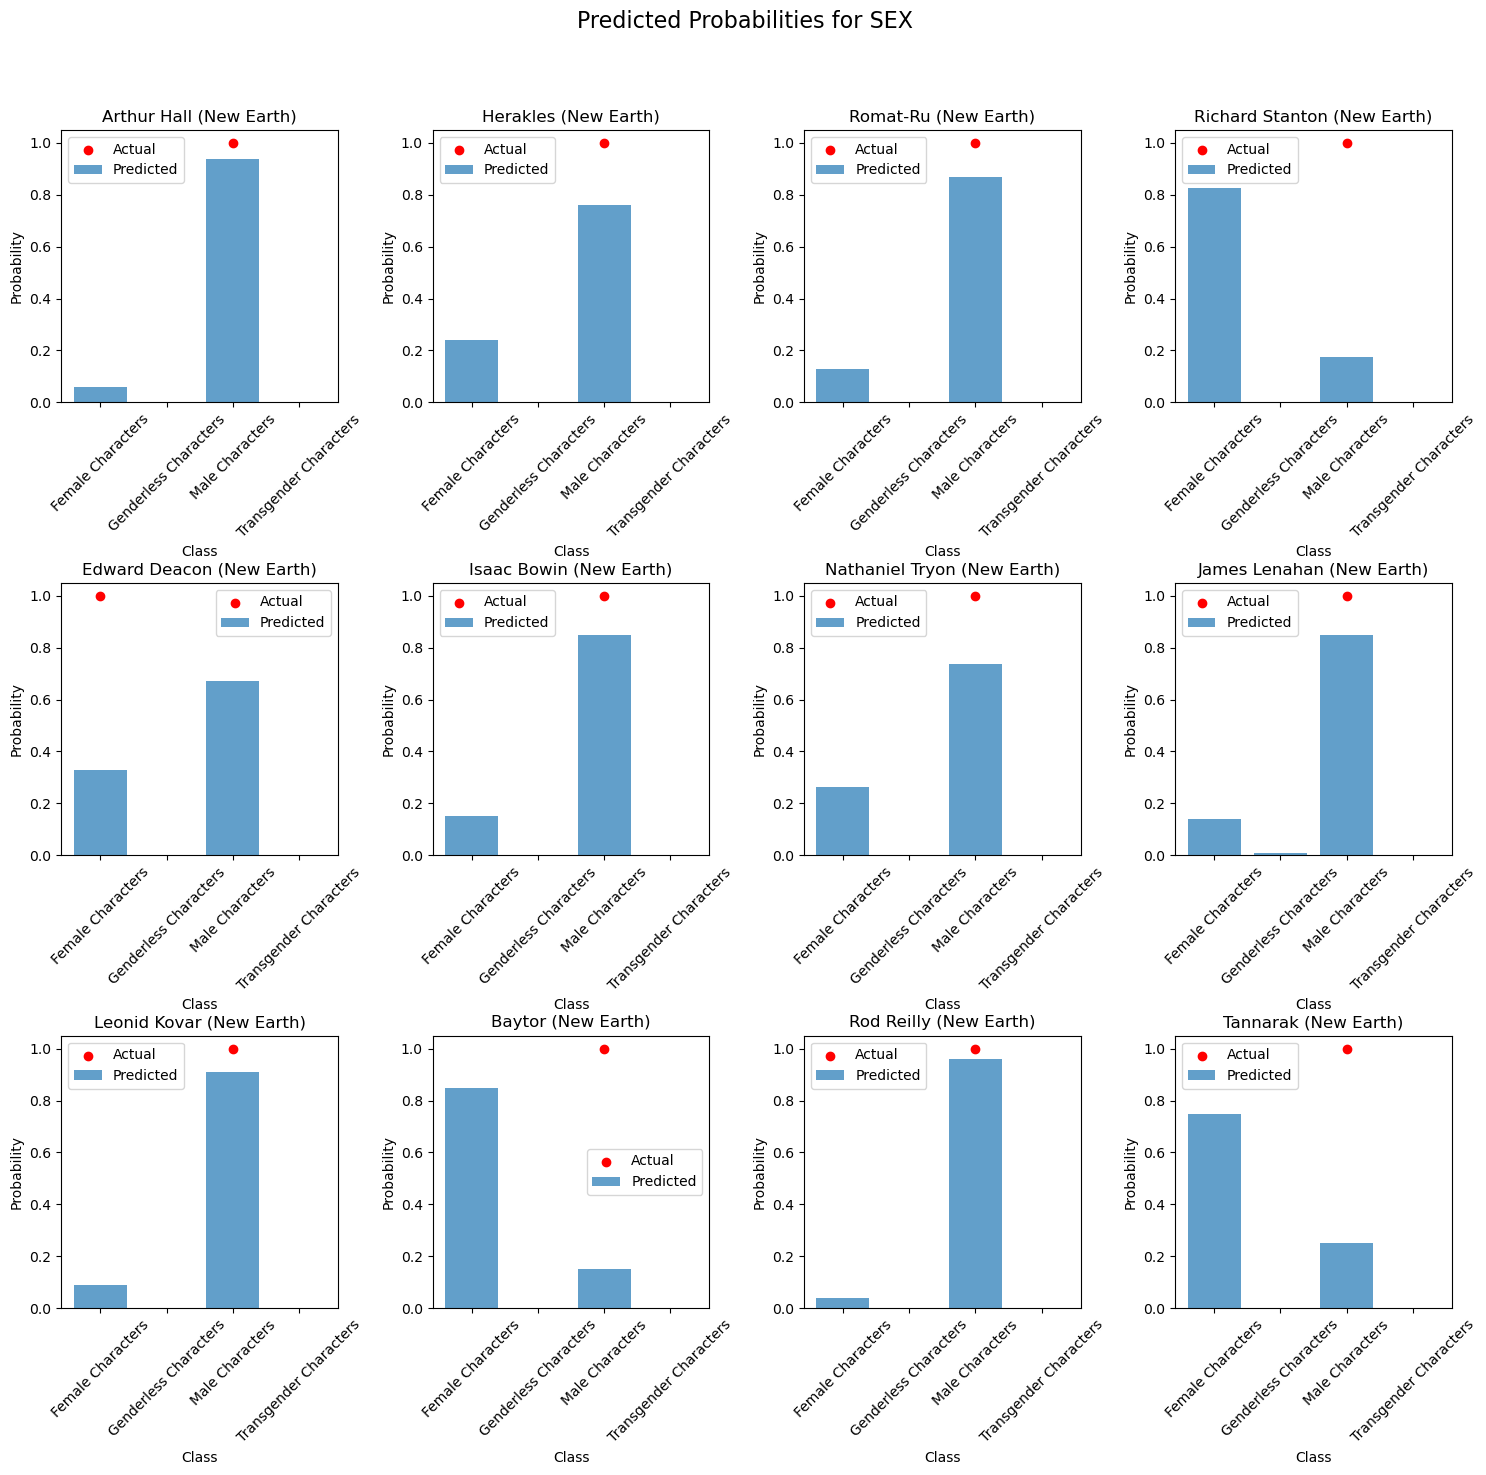

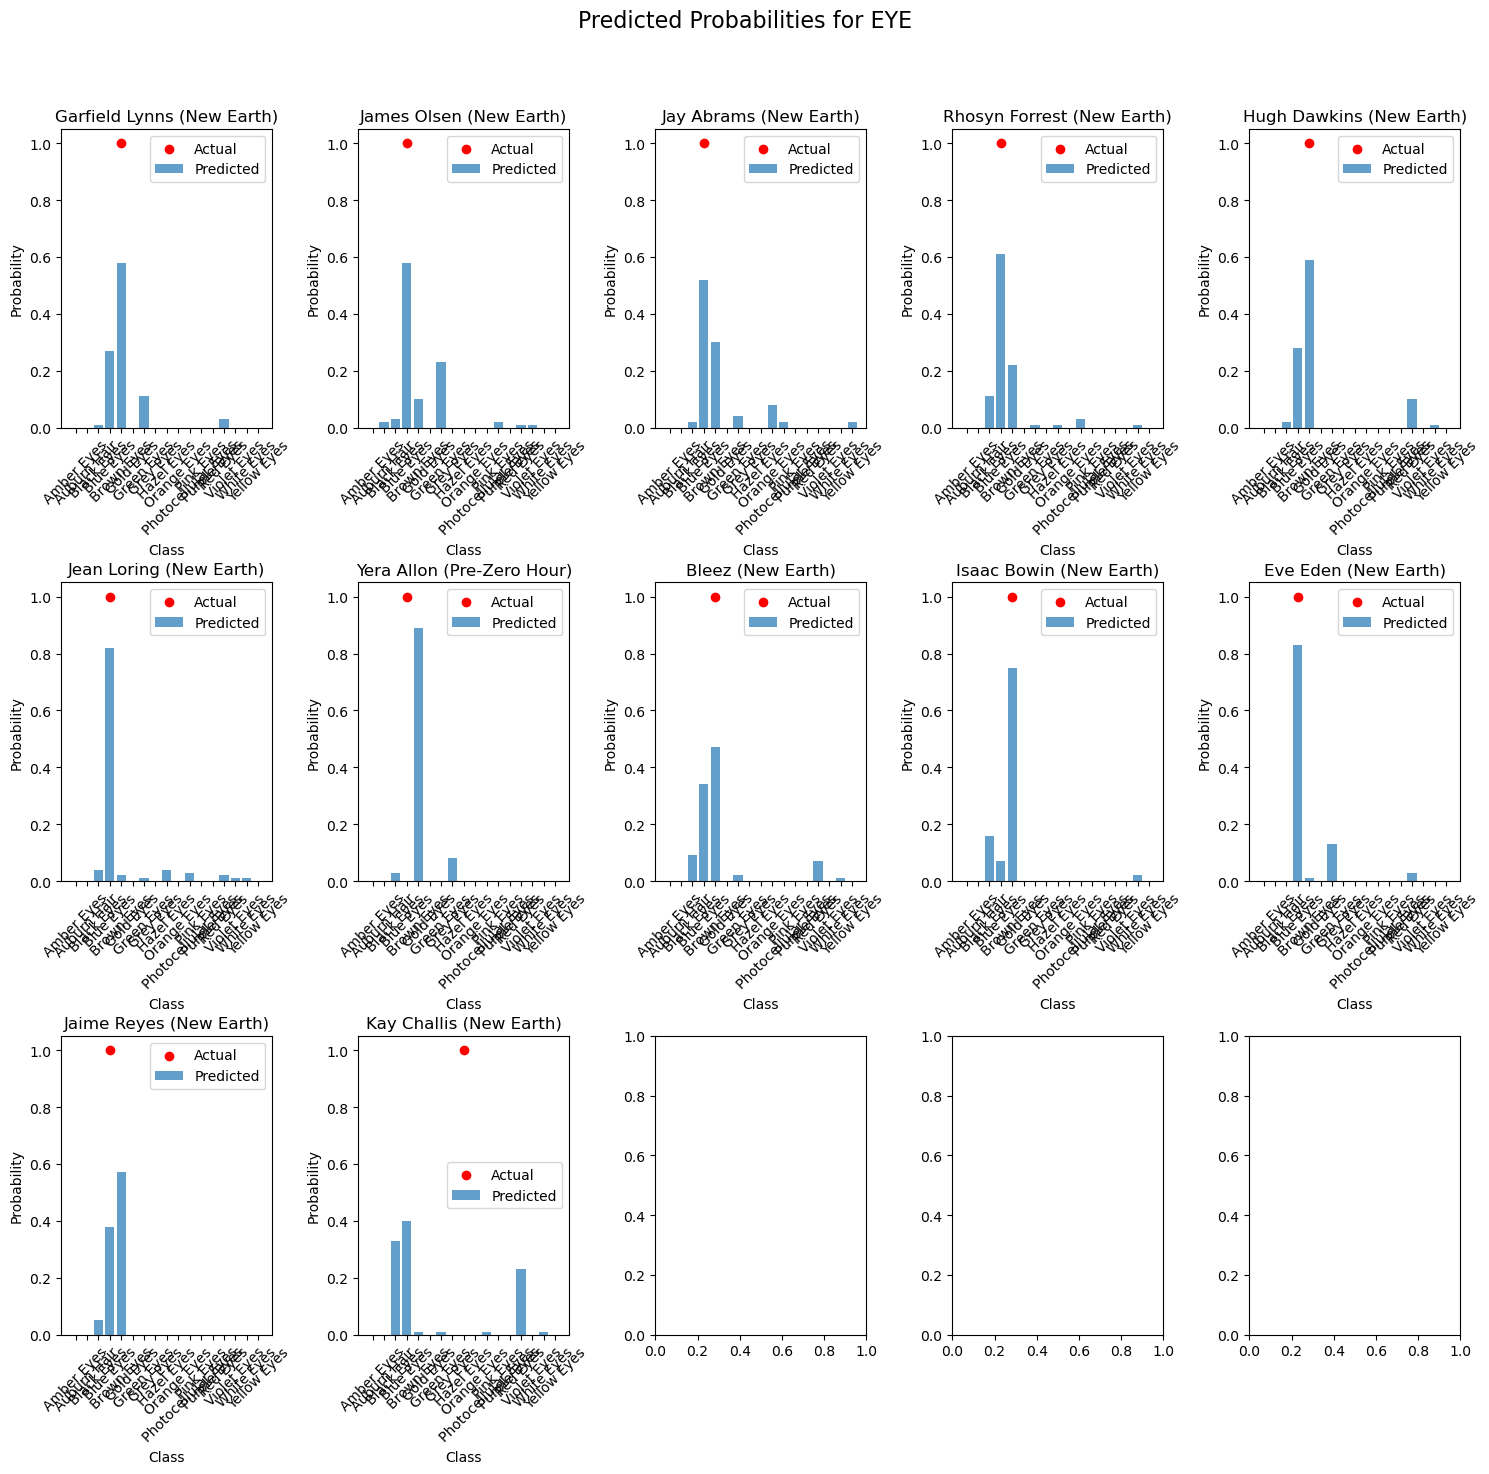

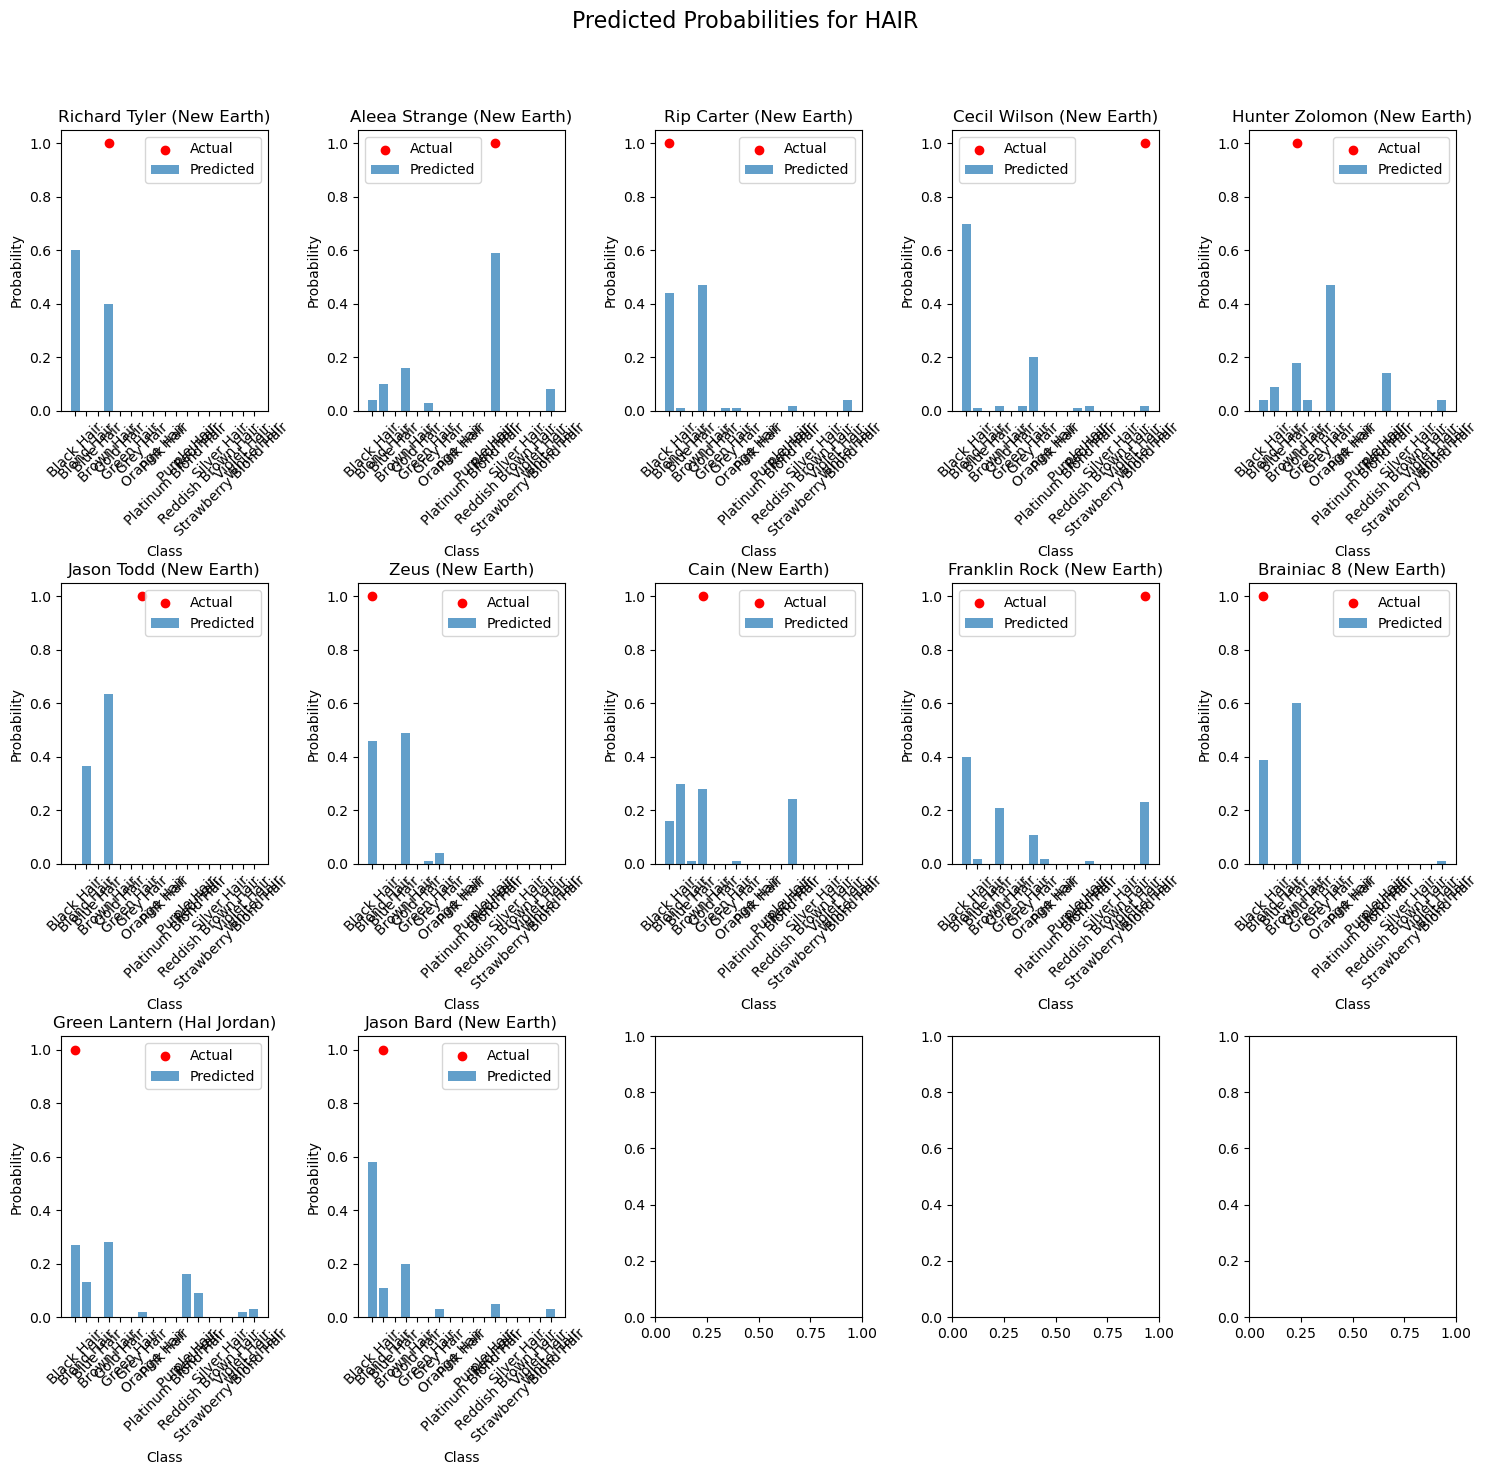

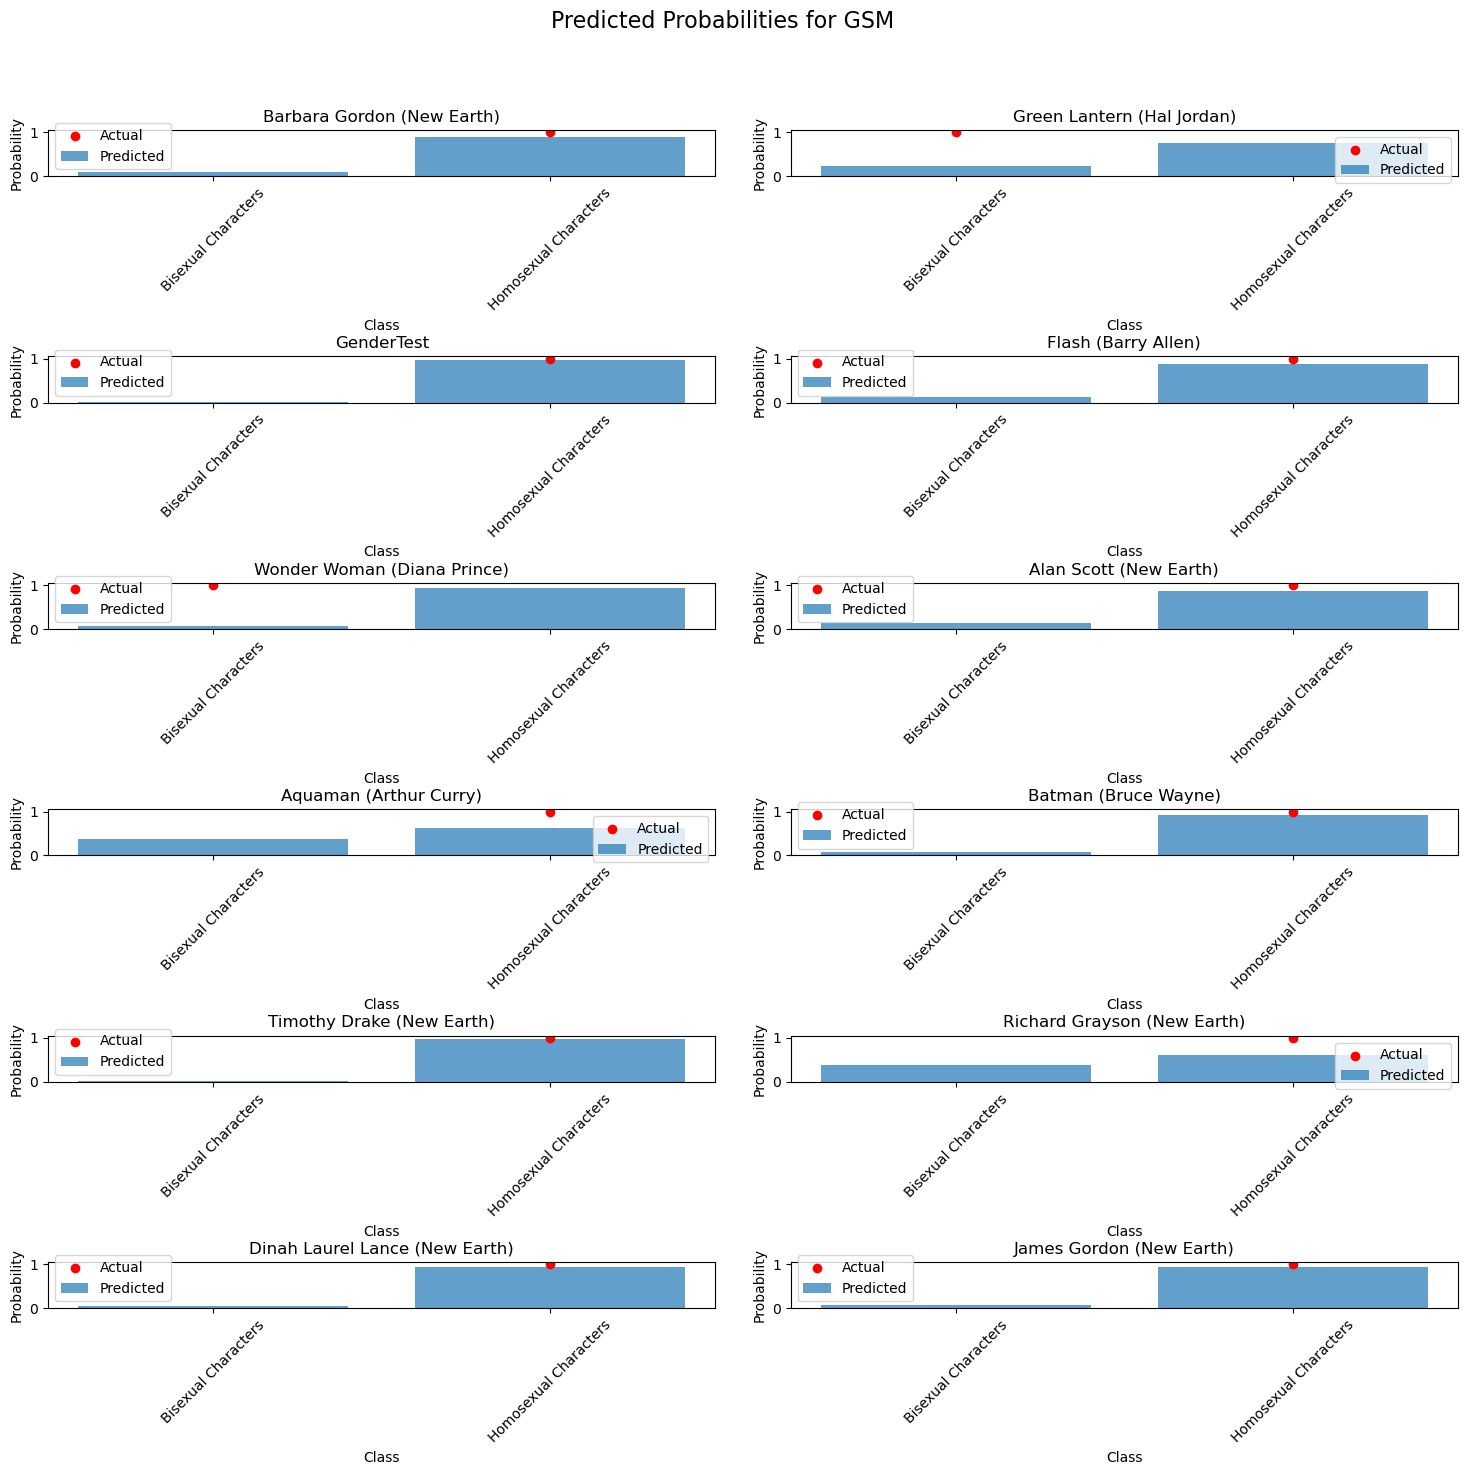

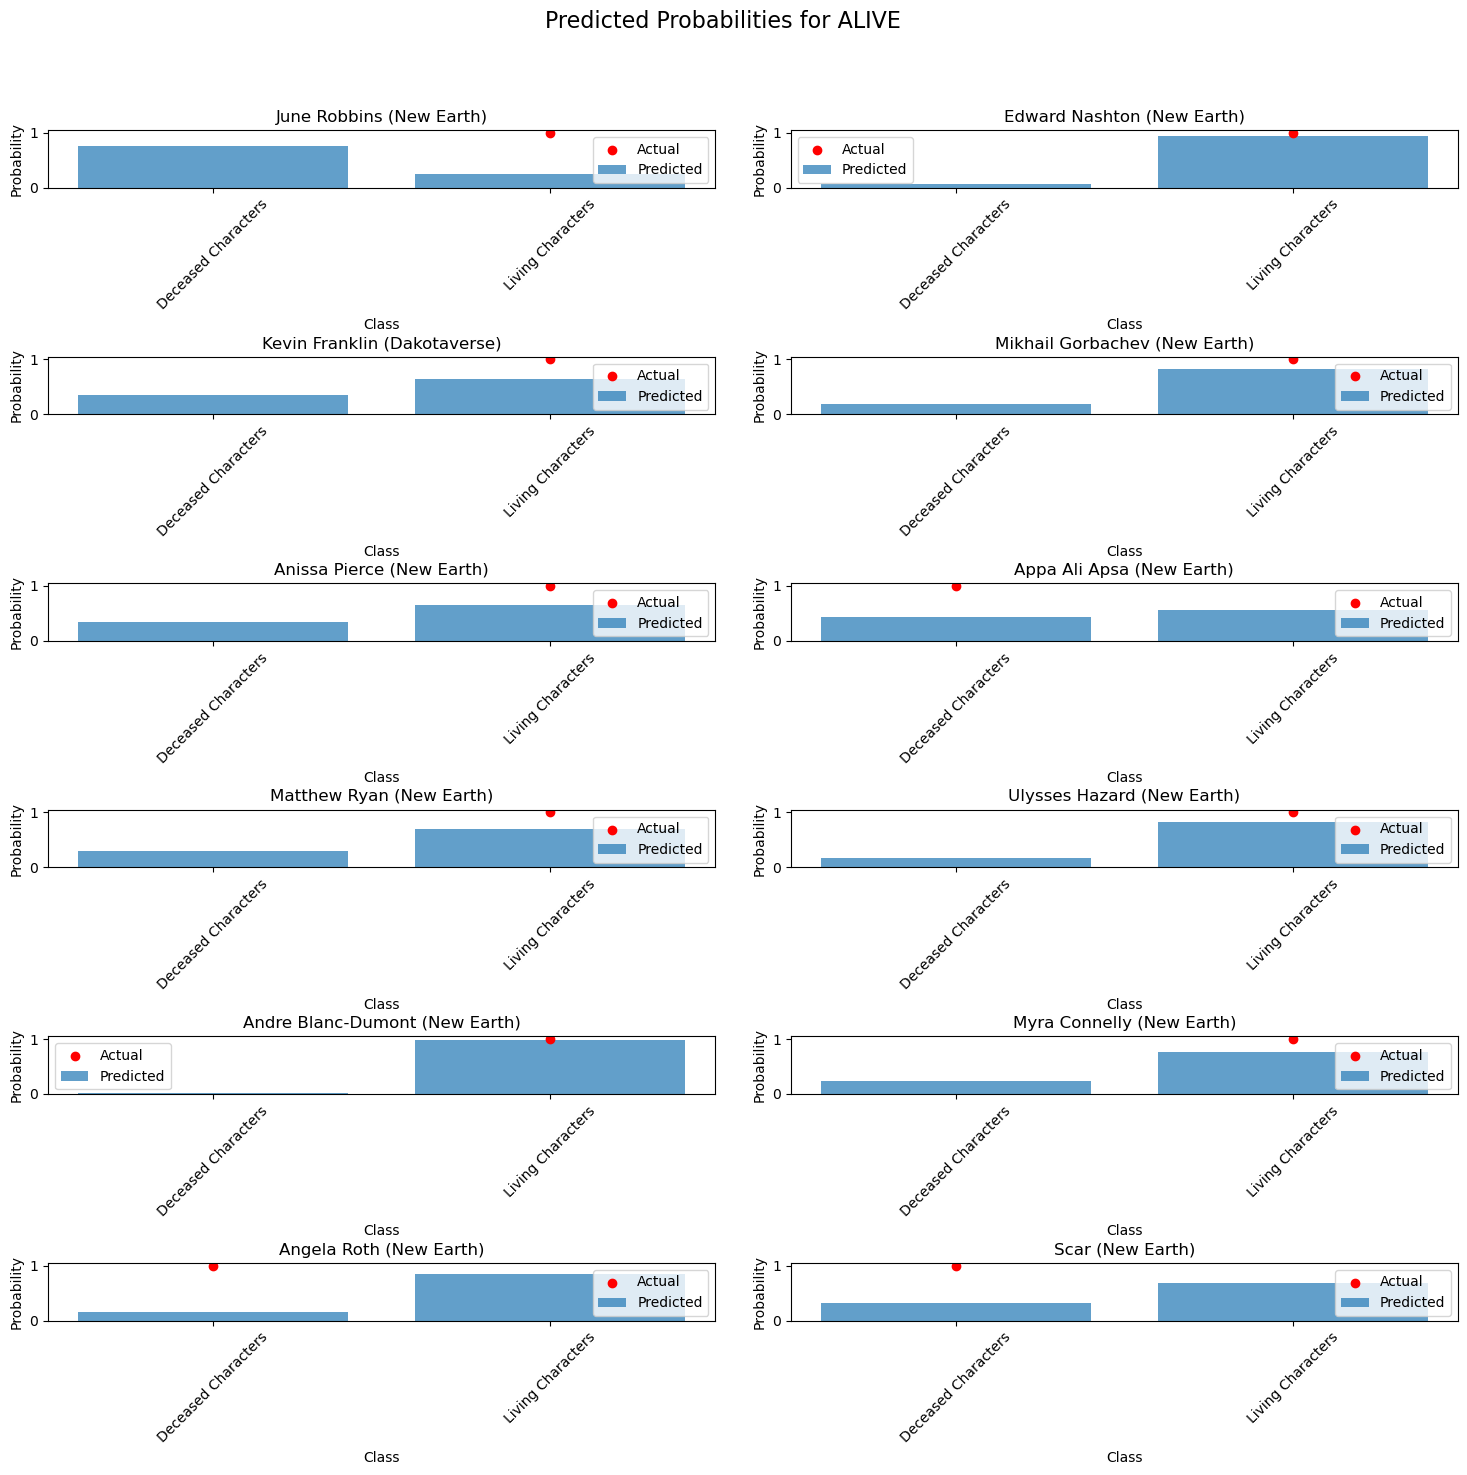

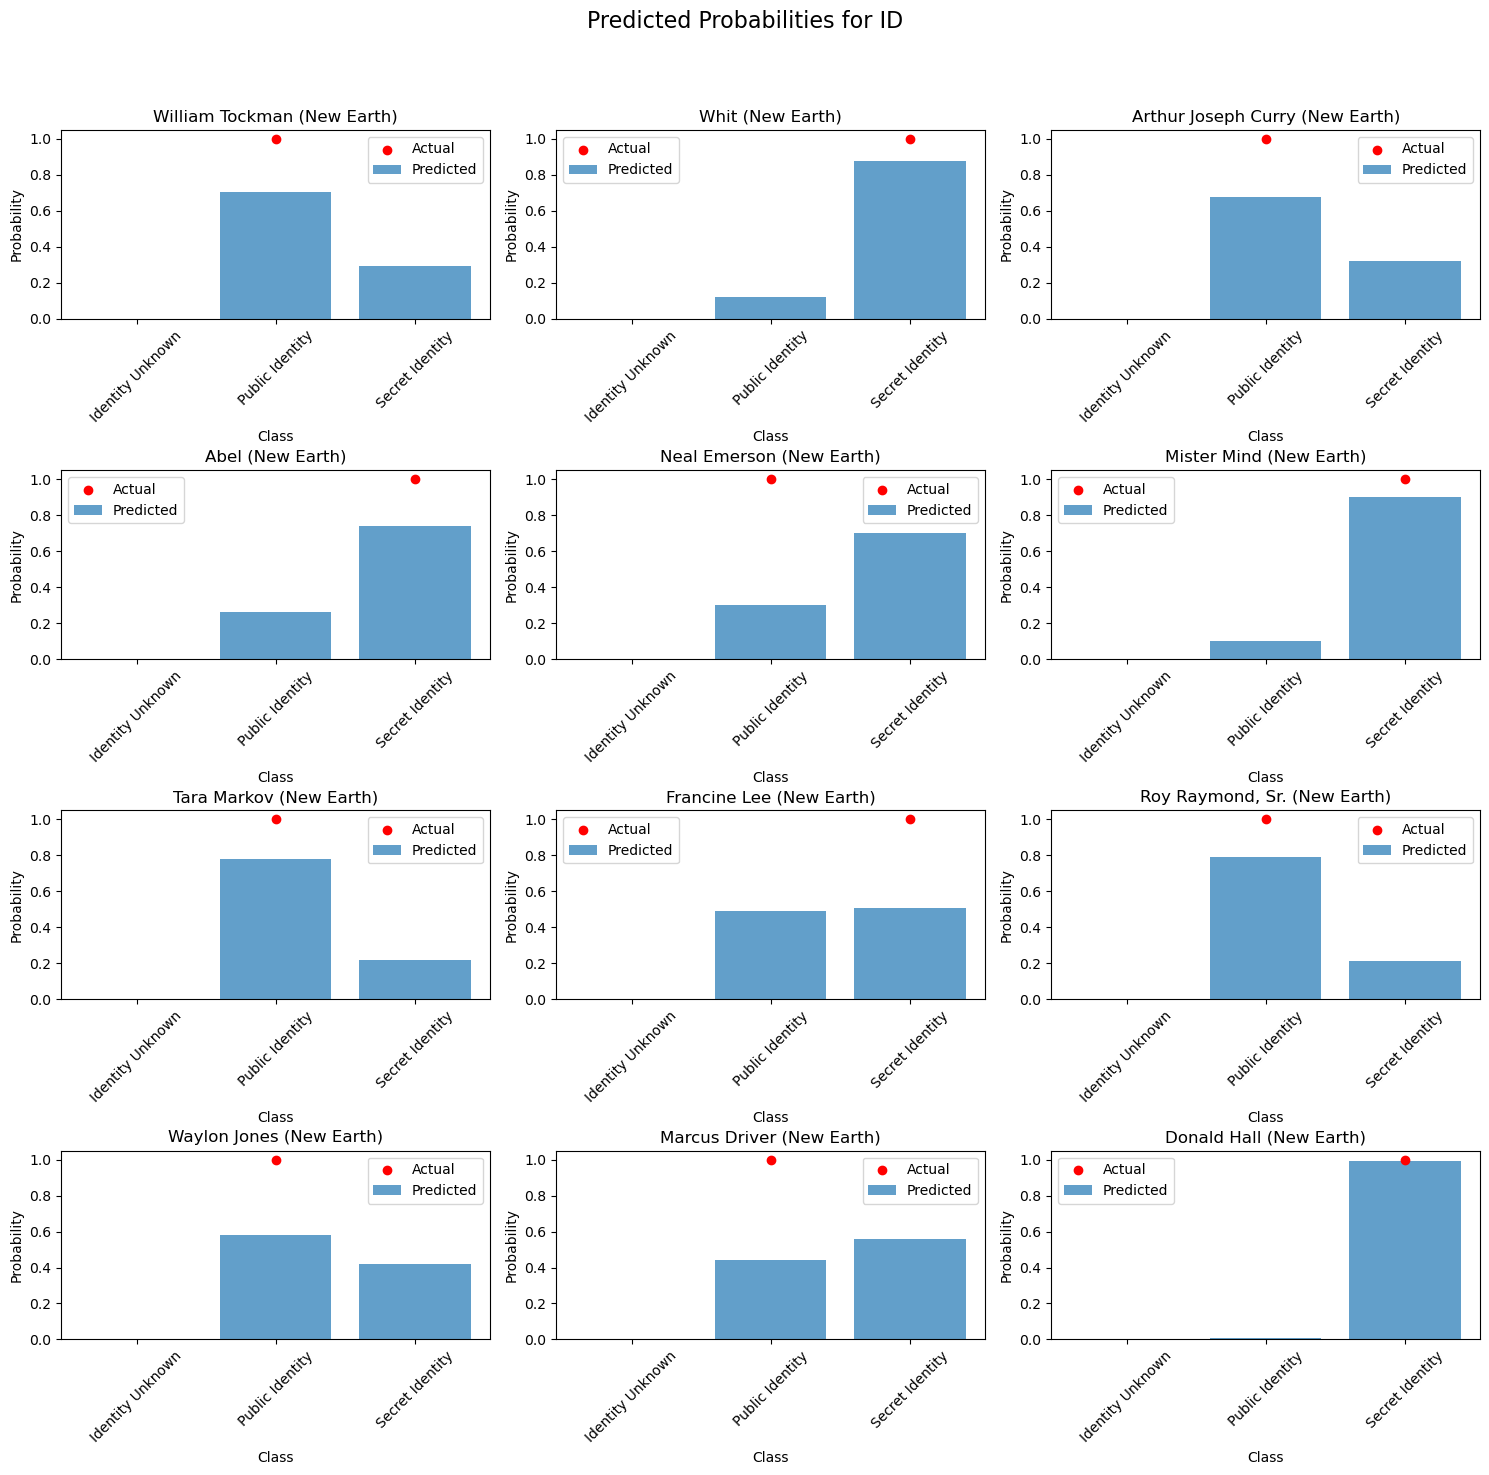

In [30]:
# Loop through each dataset
for rf_model, X_train, y_train, X_test, y_test, target_feature, class_names in rf_models_dc:
    # Select a random subset of instances from the test data
    num_instances = min((int(len(X_test) * 0.1) if len(X_test) > 250 else len(X_test)), 12)
    selected_indices = np.random.choice(len(X_test), num_instances, replace=False)
    X_test_subset = X_test.iloc[selected_indices]
    y_test_subset = y_test[selected_indices]
    
    # Get the predicted probabilities for the selected instances in the test data
    predicted_probabilities = rf_model.predict_proba(X_test_subset)

    # Get the subset of class names corresponding to the number of classes
    subset_class_names = class_names[:predicted_probabilities.shape[1]]

    # Calculate the number of rows and columns for subplots
    num_instances_subset, num_classes = predicted_probabilities.shape
    num_columns = min(num_classes, 5)  # Limit the number of columns to avoid too many subplots
    num_rows = math.ceil(num_instances_subset / num_columns)

    # Create a larger plot with subplots
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 15))
    fig.suptitle(f"Predicted Probabilities for {target_feature}", fontsize=16)

    # Loop through each instance and its corresponding predicted probabilities
    for i, (probs, ax) in enumerate(zip(predicted_probabilities, axes.flatten())):
        character_name = str(dc_names[selected_indices[i]])  # Convert to string
        actual_class = y_test_subset[i]  # Get the actual class value
        
        # Plot the predicted probabilities as a bar chart
        ax.bar(subset_class_names, probs, label="Predicted", alpha=0.7)
        
        # Plot the actual class value as a point on top of the predicted probabilities
        ax.scatter(actual_class, 1, color="red", label="Actual")
        
        ax.set_title(character_name)  # Set character name as the title
        ax.set_xlabel("Class")
        ax.set_ylabel("Probability")
        ax.set_xticks(range(len(subset_class_names)))  # Set tick positions
        ax.set_xticklabels(subset_class_names, rotation=45)  # Set tick labels
        ax.legend()  # Show legend
        
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.savefig(f"""figs/prob_charts/DC_{target_feature}_{selected_indices}_probabilities.png""")
    plt.show()


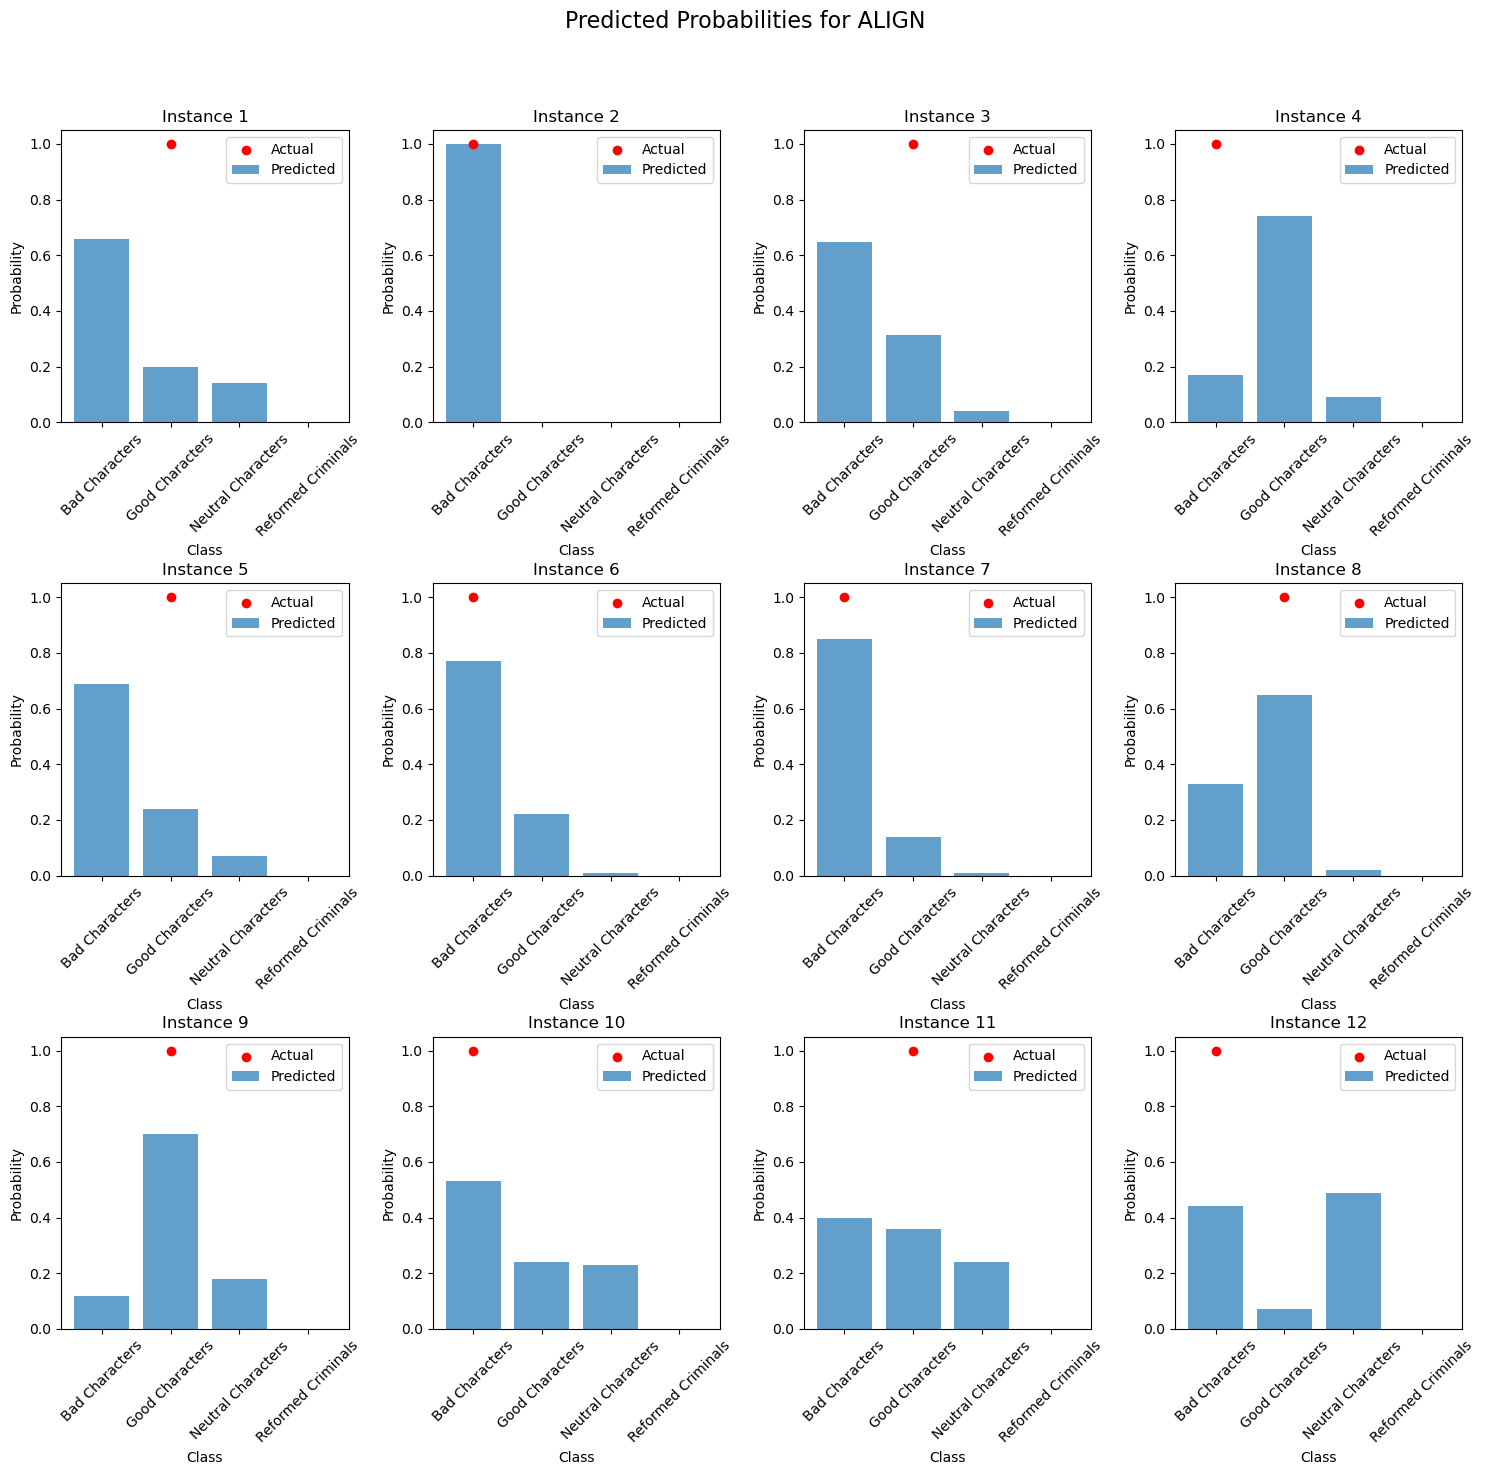

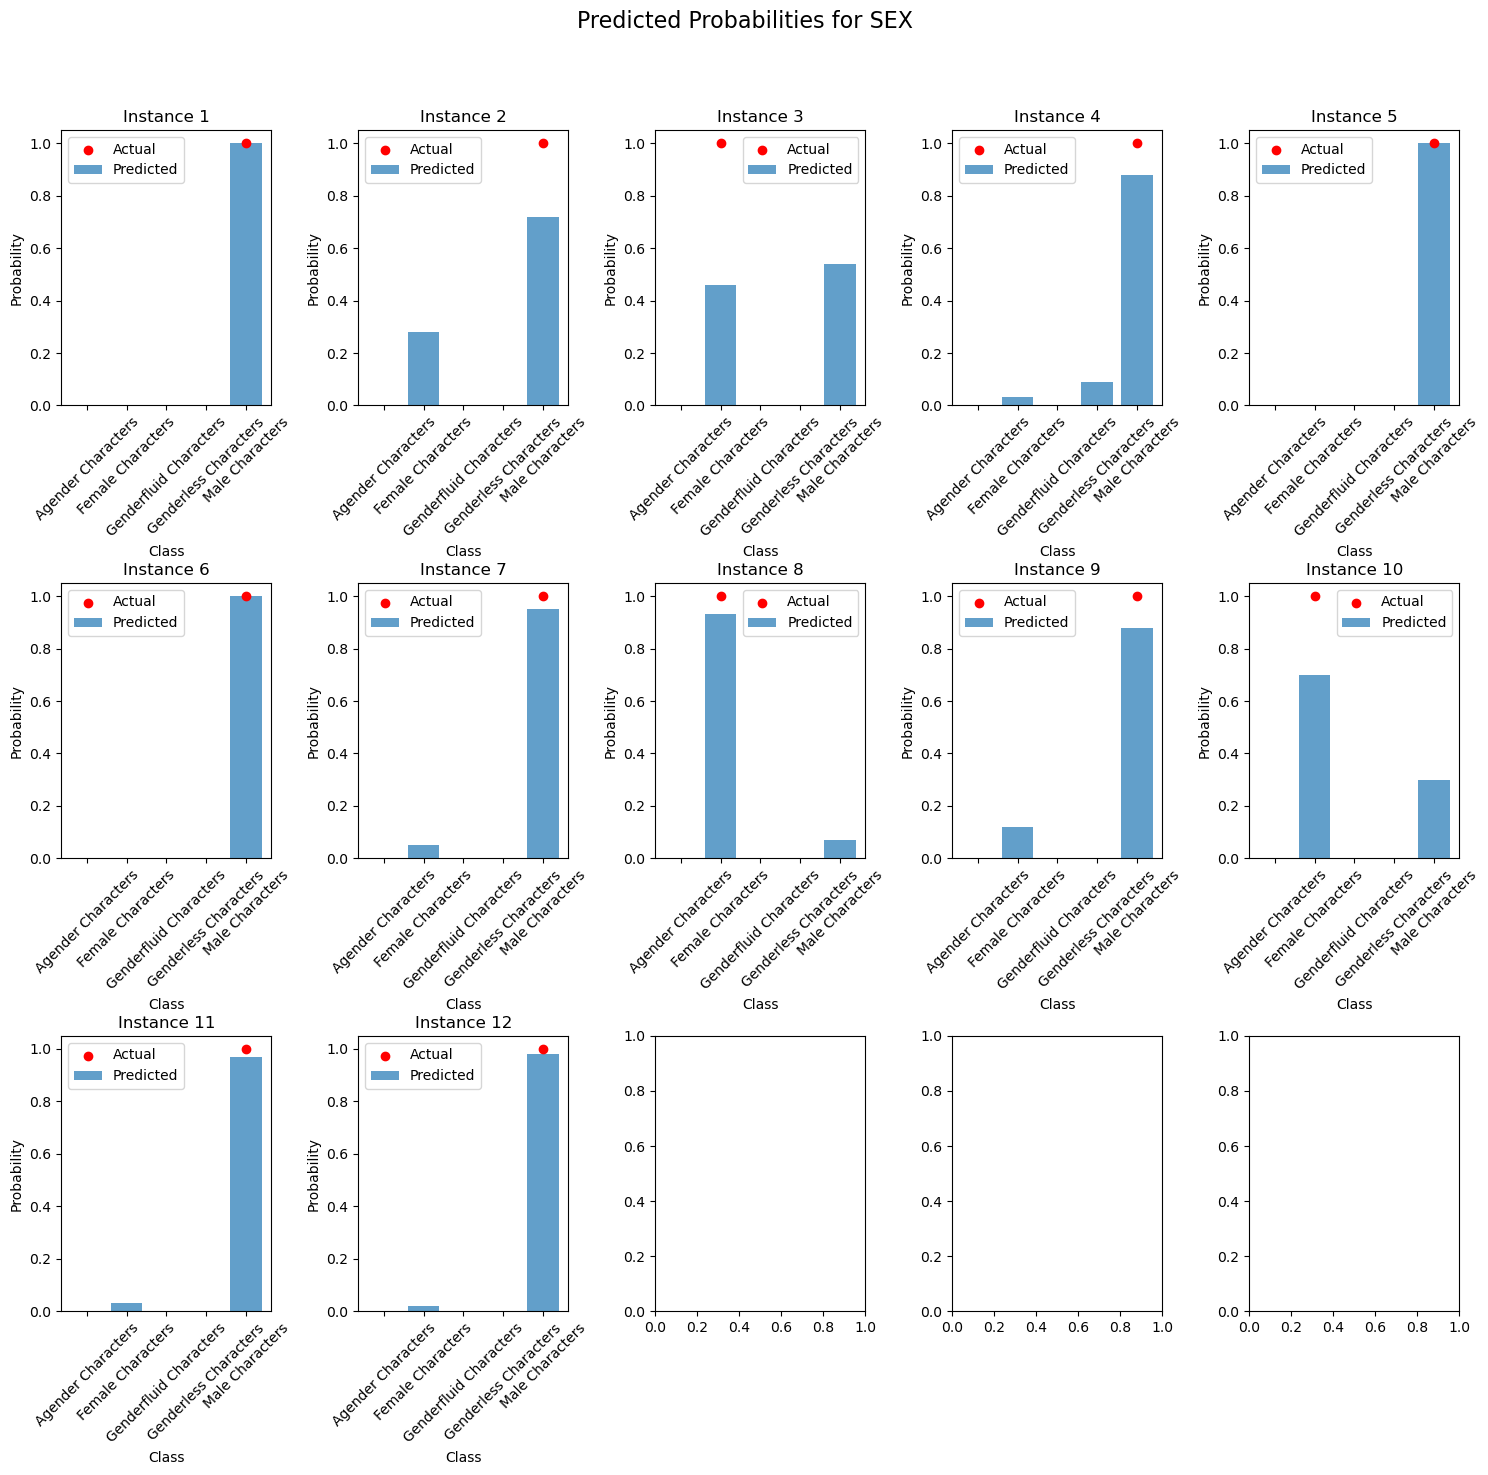

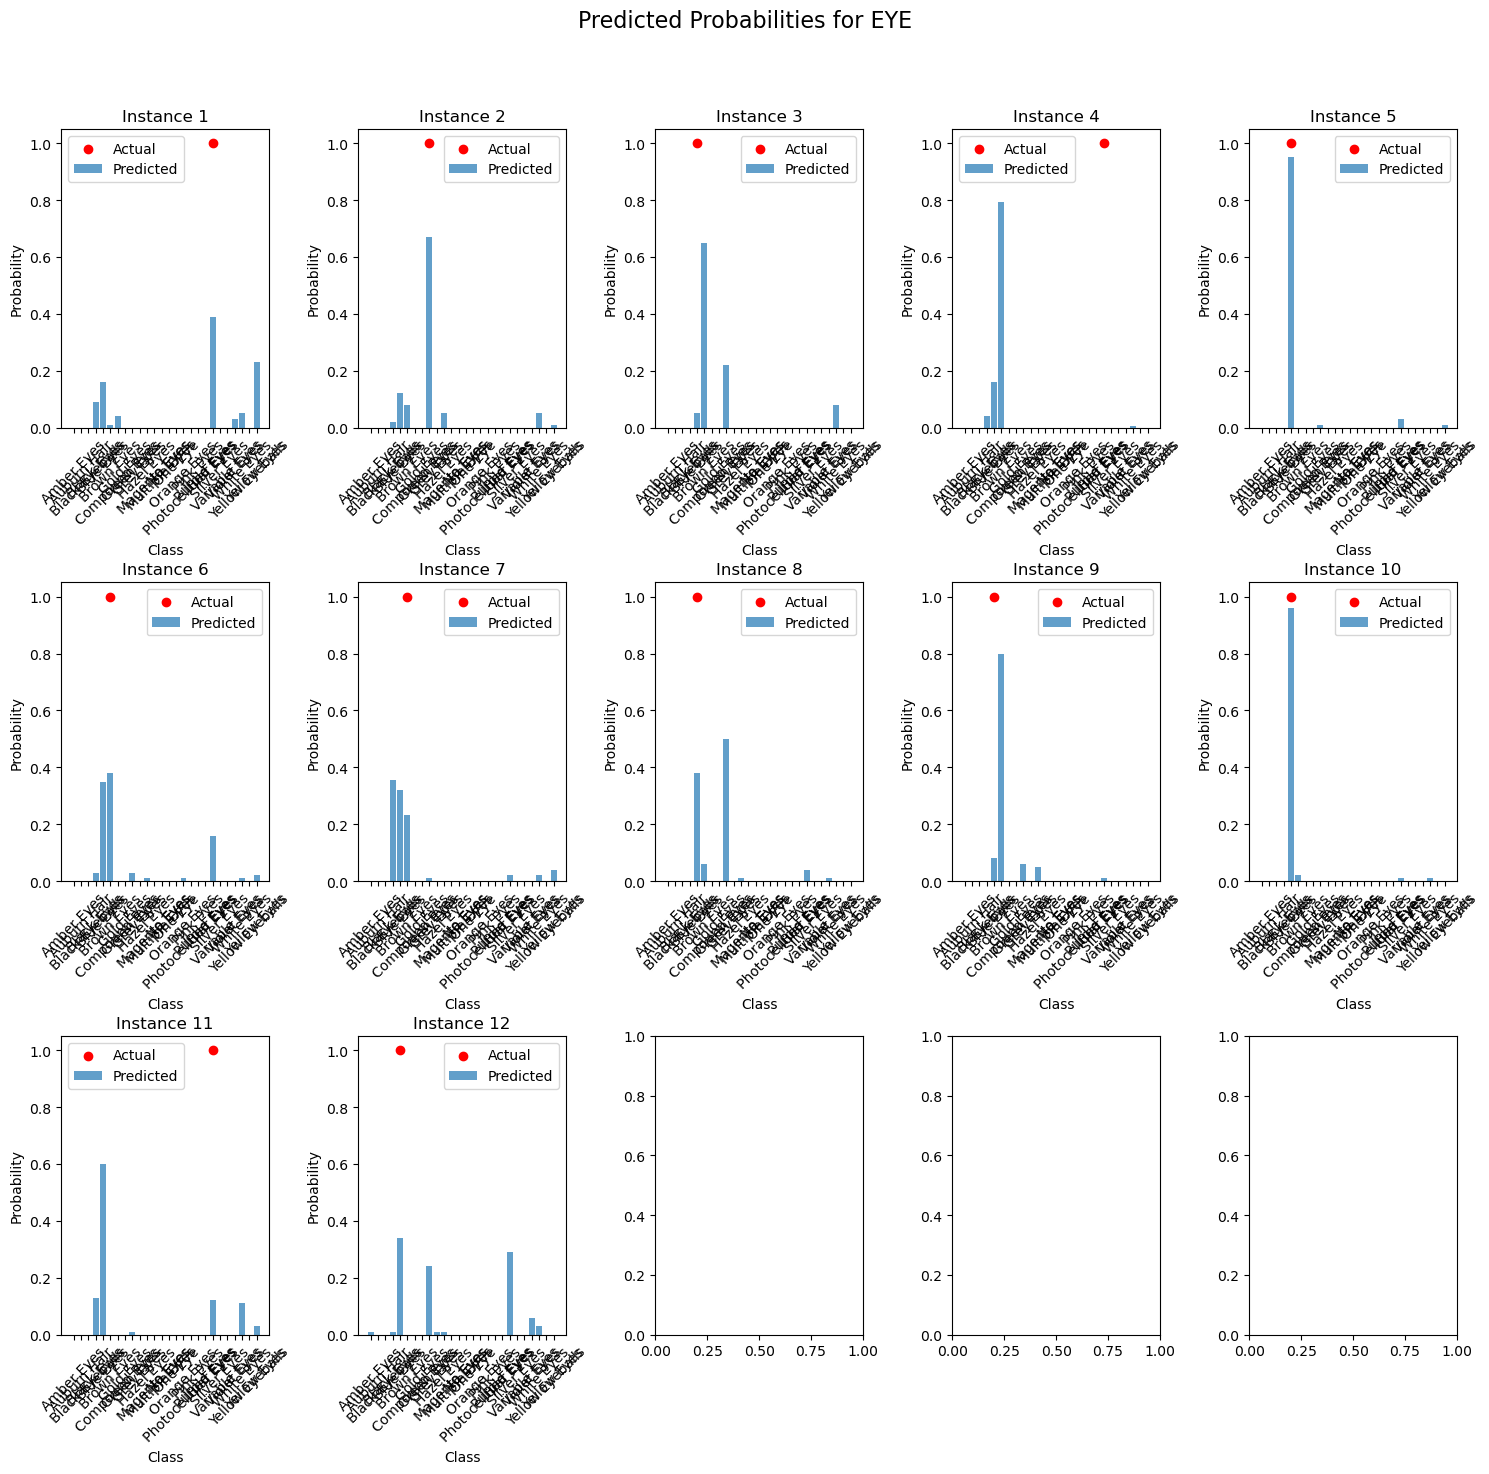

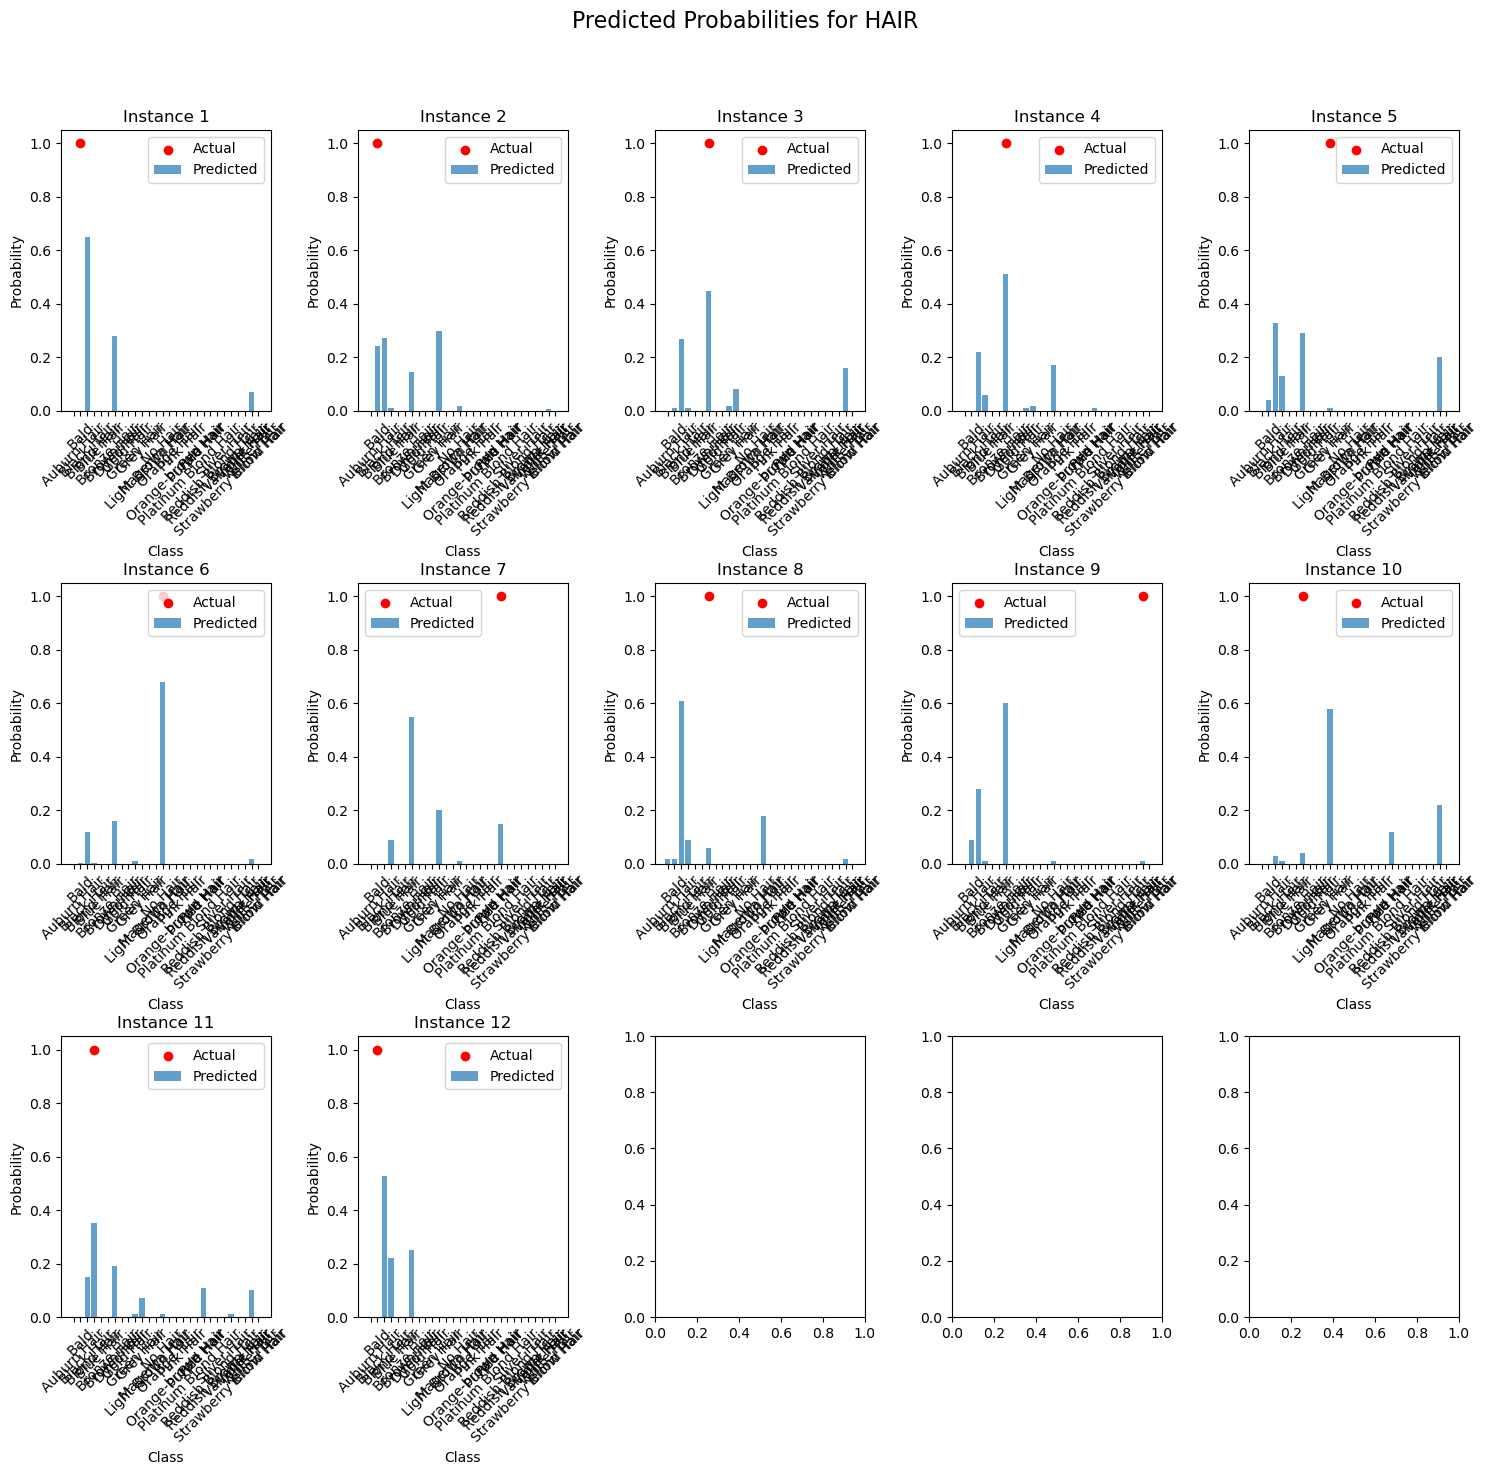

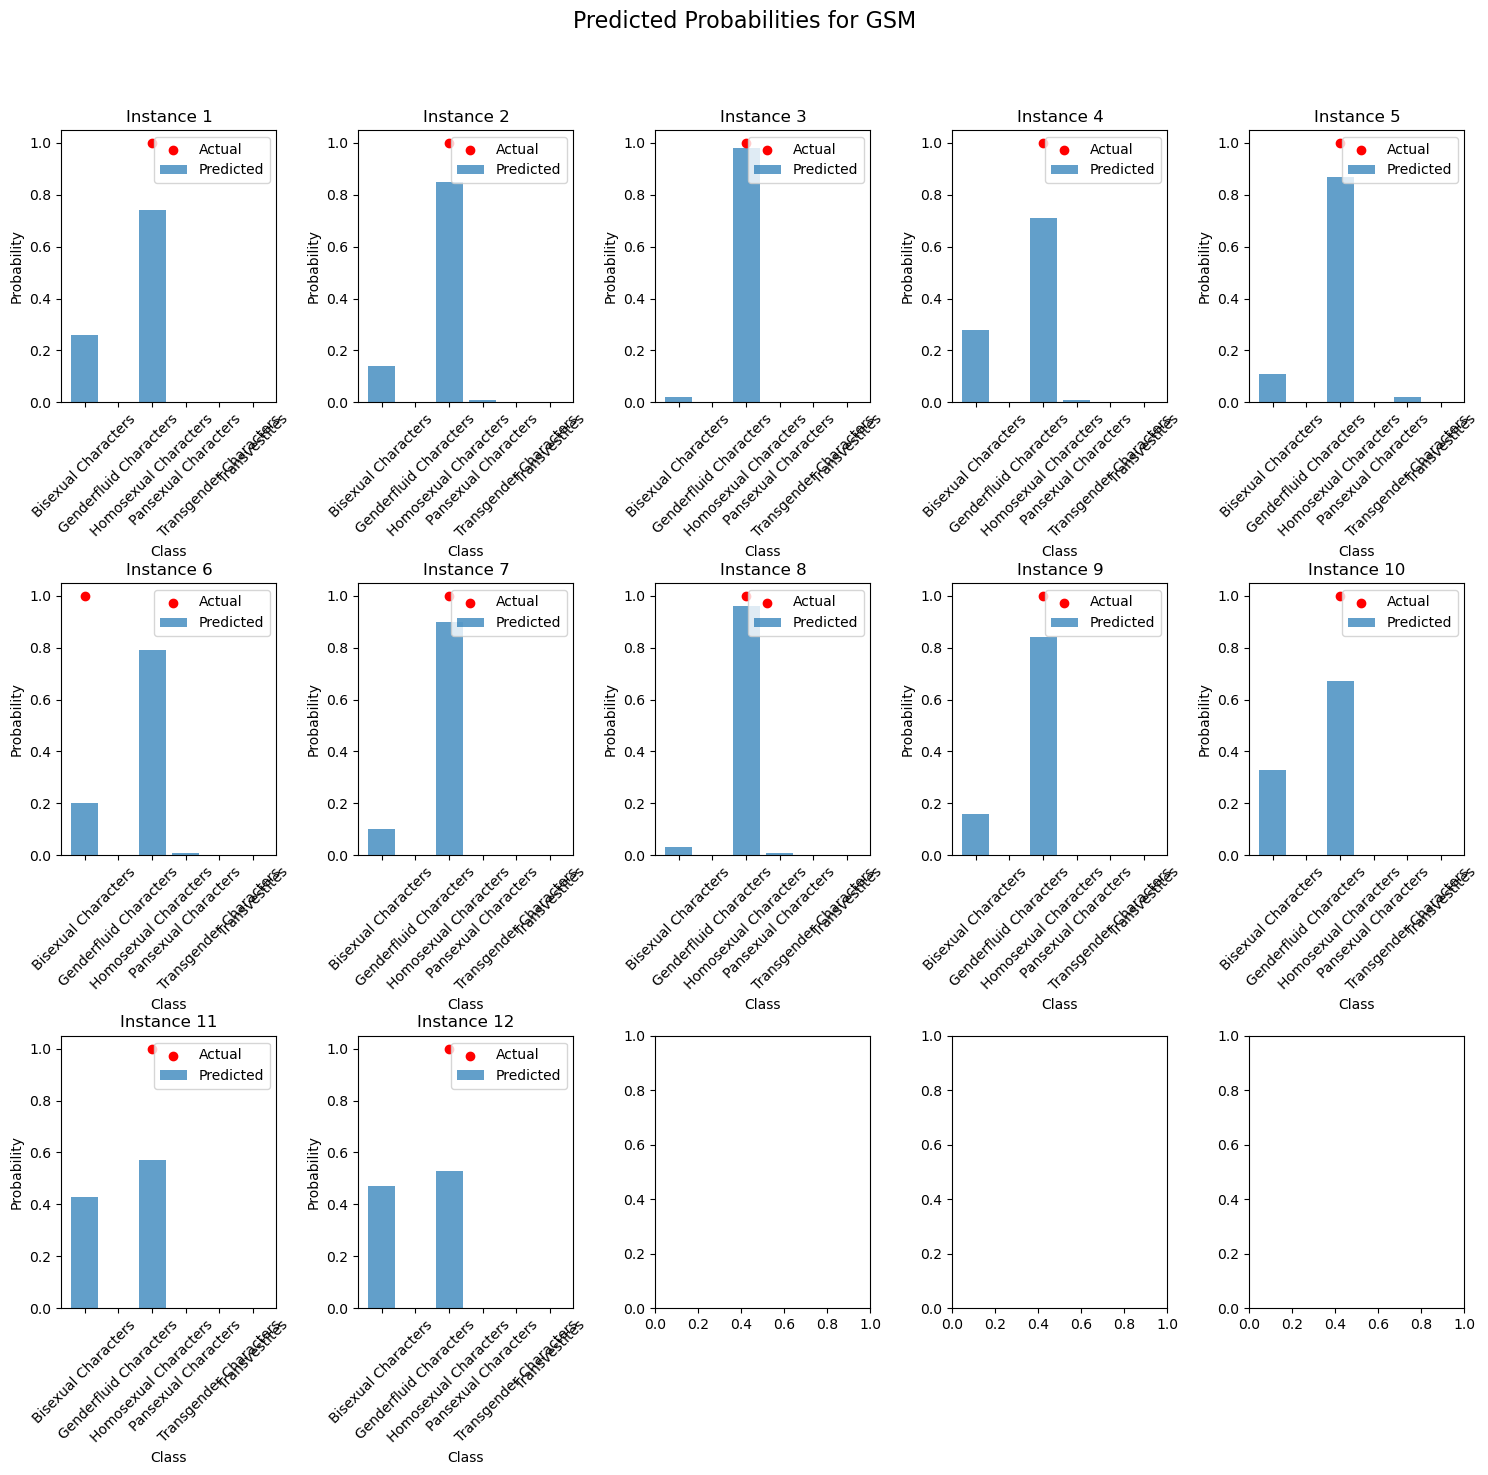

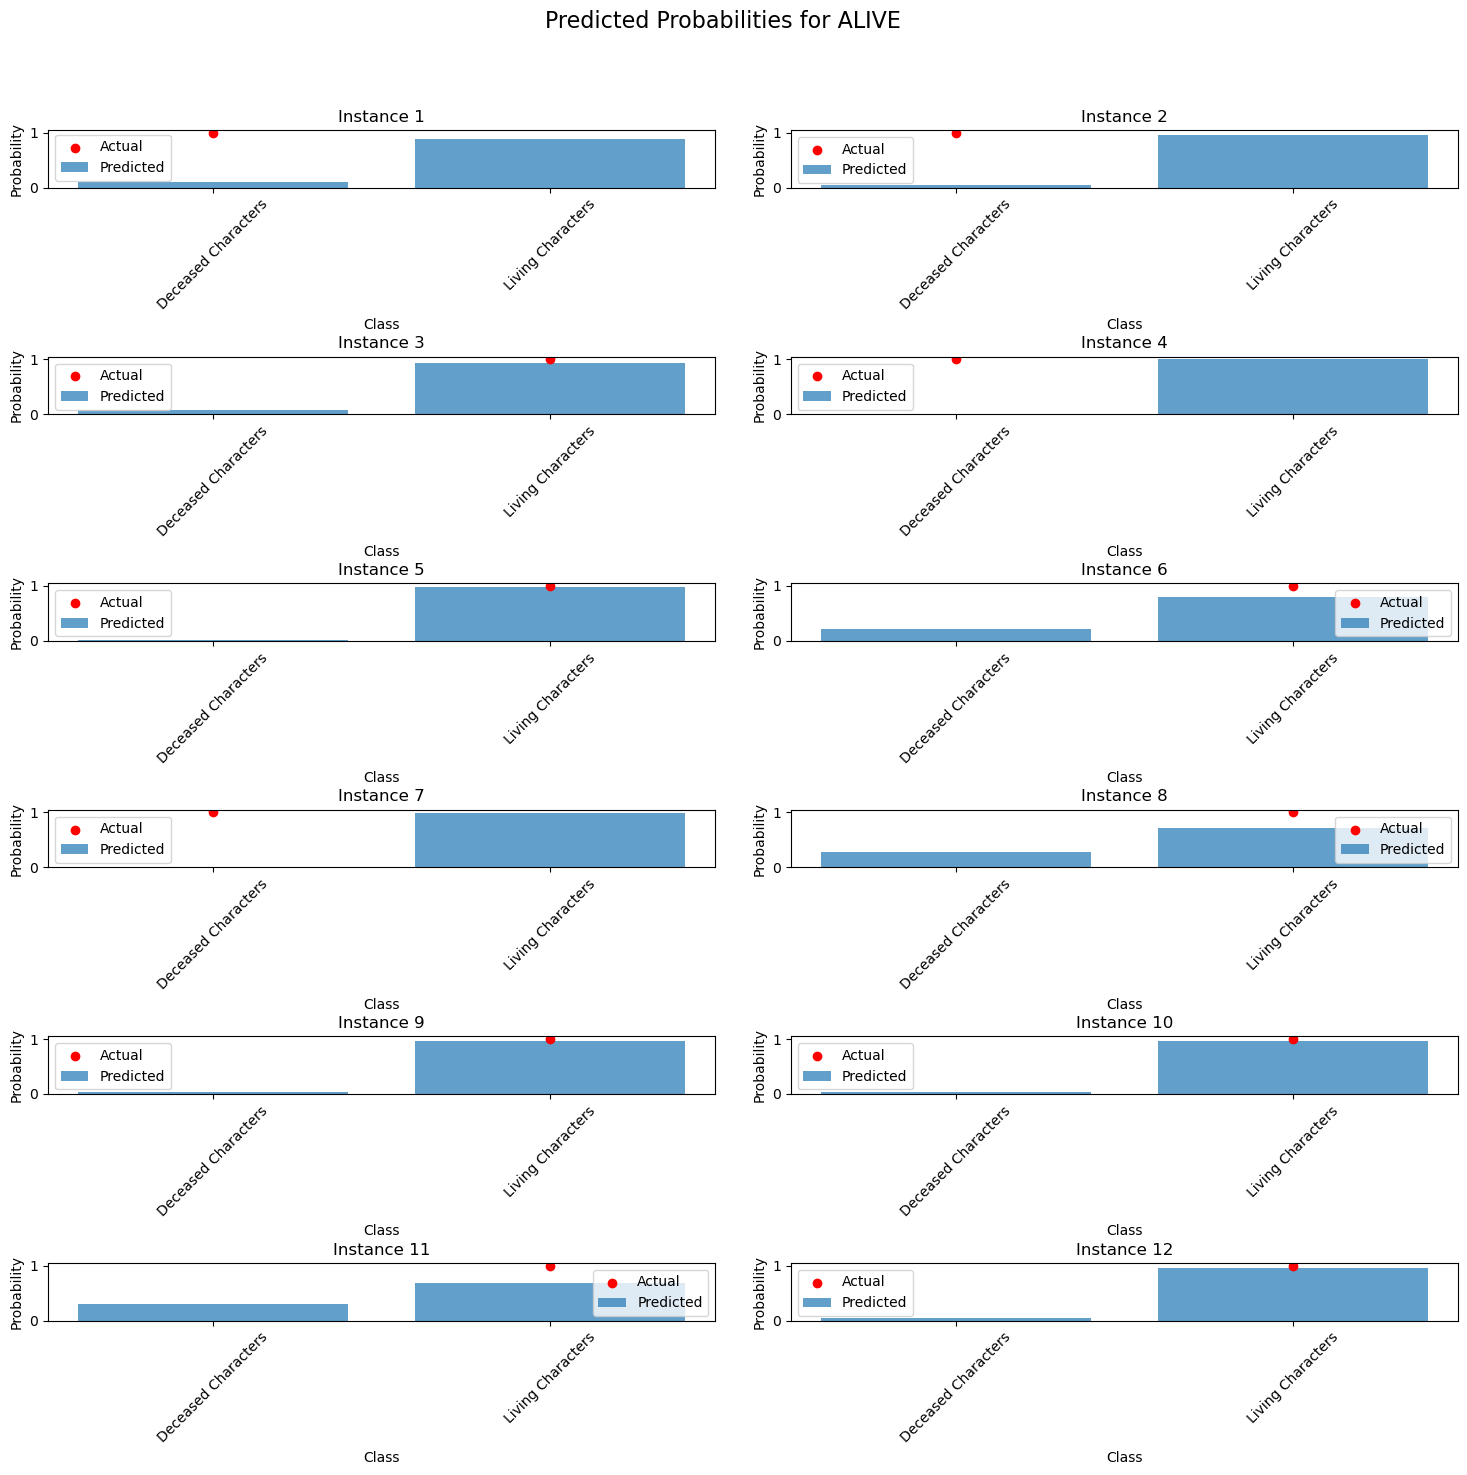

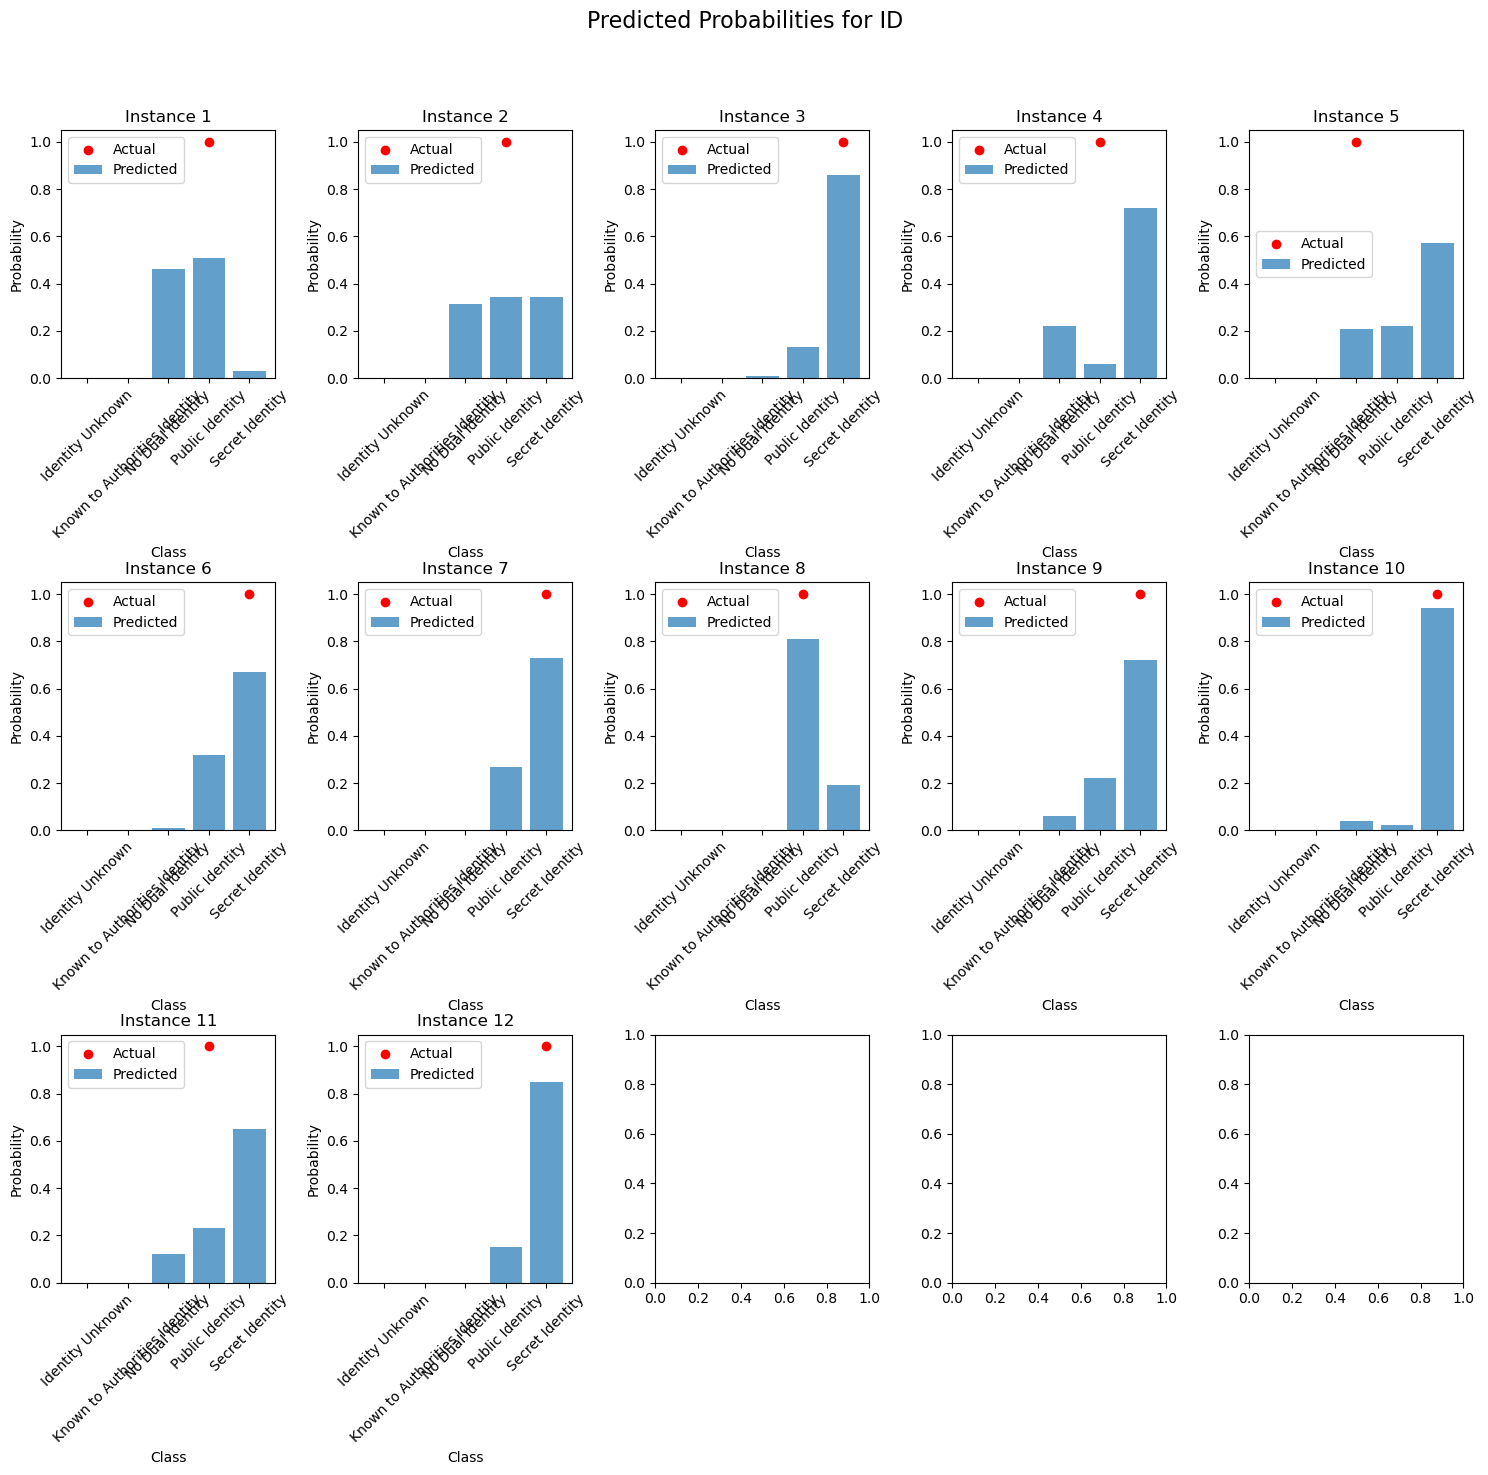

In [32]:
# Loop through each dataset
for rf_model, X_train, y_train, X_test, y_test, target_feature, class_names in rf_models_combined:
    # Select a random subset of instances from the test data
    num_instances = min((int(len(X_test) * 0.1) if len(X_test) > 250 else len(X_test)), 12)
    selected_indices = np.random.choice(len(X_test), num_instances, replace=False)
    X_test_subset = X_test.iloc[selected_indices]
    y_test_subset = y_test[selected_indices]
    
    # Get the predicted probabilities for the selected instances in the test data
    predicted_probabilities = rf_model.predict_proba(X_test_subset)

    # Get the subset of class names corresponding to the number of classes
    subset_class_names = class_names[:predicted_probabilities.shape[1]]

    # Calculate the number of rows and columns for subplots
    num_instances_subset, num_classes = predicted_probabilities.shape
    num_columns = min(num_classes, 5)  # Limit the number of columns to avoid too many subplots
    num_rows = math.ceil(num_instances_subset / num_columns)

    # Create a larger plot with subplots
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 15))
    fig.suptitle(f"Predicted Probabilities for {target_feature}", fontsize=16)

    # Loop through each instance and its corresponding predicted probabilities
    for i, (probs, ax) in enumerate(zip(predicted_probabilities, axes.flatten())):
        actual_class = y_test_subset[i]  # Get the actual class value
        
        # Plot the predicted probabilities as a bar chart
        ax.bar(subset_class_names, probs, label="Predicted", alpha=0.7)
        
        # Plot the actual class value as a point on top of the predicted probabilities
        ax.scatter(actual_class, 1, color="red", label="Actual")
        
        ax.set_title(f"Instance {i+1}")  # Set character name as the title
        ax.set_xlabel("Class")
        ax.set_ylabel("Probability")
        ax.set_xticks(range(len(subset_class_names)))  # Set tick positions
        ax.set_xticklabels(subset_class_names, rotation=45)  # Set tick labels
        ax.legend()  # Show legend
        
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.savefig(f"""figs/prob_charts/Combined_{target_feature}_{selected_indices}_probabilities.png""")
    plt.show()
